In [ ]:
import re
import pandas as pd
import dask as dd
from dask.dataframe import from_pandas
from dask import delayed
import time
from dask.distributed import Client

#if __name__ == '__main__':



start_time = time.time()

#client = Client(n_workers=1)
client = Client(n_workers=1, threads_per_worker=2)
#exit(1);

#file_name = "/home/STUDENTI/lucia.gasperini/storm-frontend-server.log-20200309"
#file_name = "/home/STUDENTI/lucia.gasperini/storm_100k"
file_name = "/Users/lucia/Desktop/storm_100k"

data= pd.read_csv(file_name, names=['timestamp', "threadID" ,'type', 'ProcId' , 'msg'], sep = '\w Thread | -  | \[|\]:', engine = 'python')

# create the new dataframe
#data_by_procid=pd.DataFrame(dict(timestamp=list('timestamp'), threadID=list("threadID"), ProcId=list('ProcId'), msg=list('msg')))
#dataFrame=pd.DataFrame(data)
#dataFrame=pd.DataFrame(columns=['ProcId','timestamp','threadID','type','msg'])
dataFrame=data.loc[:, ['ProcId', 'timestamp',"threadID",'type','msg']]
print(dataFrame)

f=data.ProcId.unique()
# Questo divide un dataframe Pandas in memoria in più parti e costruisce un dask.dataframe da quelle parti su cui
# Dask.dataframe può operare in parallelo.

#ddf = from_pandas(dataFrame, npartitions=2)

# estract the unique list of ProcId
#list=ddf.ProcId.unique().compute()
#print(list)
#ddf.ProcId.unique().compute()



#print(ddf)
#print(ddf.divisions)

#conversione dask DataFrame in pandas DataFrame
#pandas_df=ddf.compute()

#print(pandas_df)





mask=[]
mask.append(r'([0-9a-fA-F]{1,4}:){1,4}(:[0-9a-fA-F]{1,4}){1,2}|')
mask.append(r'([0-9a-fA-F]{1,4}:){7,7}[0-9a-fA-F]{1,4}|')
mask.append(r'([0-9a-fA-F]{1,4}:){1,7}:|')
mask.append(r'([0-9a-fA-F]{1,4}:){1,6}:[0-9a-fA-F]{1,4}|')
mask.append(r'([0-9a-fA-F]{1,4}:){1,5}(:[0-9a-fA-F]{1,4}){1,2}|')
mask.append(r'([0-9a-fA-F]{1,4}:){1,4}(:[0-9a-fA-F]{1,4}){1,3}|')
mask.append(r'([0-9a-fA-F]{1,4}:){1,3}(:[0-9a-fA-F]{1,4}){1,4}|')
mask.append(r'([0-9a-fA-F]{1,4}:){1,2}(:[0-9a-fA-F]{1,4}){1,5}')
mask.append(r'[0-9a-fA-F]{1,4}:((:[0-9a-fA-F]{1,4}){1,6})')
mask.append(r':((:[0-9a-fA-F]{1,4}){1,7}|:)|')
mask.append(r'fe80:(:[0-9a-fA-F]{0,4}){0,4}%[0-9a-zA-Z]{1,}|')
mask.append(r'::(ffff(:0{1,4}){0,1}:){0,1}((25[0-5]|(2[0-4]|1{0,1}[0-9]){0,1}[0-9])\.){3,3}(25[0-5]|(2[0-4]|1{0,1}[0-9]){0,1}[0-9])|')
mask.append(r'([0-9a-fA-F]{1,4}:){1,4}:((25[0-5]|(2[0-4]|1{0,1}[0-9]){0,1}[0-9])\.){3,3}(25[0-5]|(2[0-4]|1{0,1}[0-9]){0,1}[0-9])|')
mask.append(r'((25[0-5]|(2[0-4]|1{0,1}[0-9]){0,1}[0-9])\.){3,3}(25[0-5]|(2[0-4]|1{0,1}[0-9]){0,1}[0-9])')
#mask.append(r'([0-9a-fA-F]{1,4}:){1,4}:')
#mask.append(r'((25[0-5]|(2[0-4]|1{0,1}[0-9]){0,1}[0-9])\.){3,3}')
#mask.append(r'(25[0-5]|(2[0-4]|1{0,1}[0-9]){0,1}[0-9])')

mask.append(r'[fF][eE]80:(:[0-9a-fA-F]{0,4}){0,4}%[0-9a-zA-Z]{1,}')
ipmask="".join(mask)

ipv6_address=re.compile(ipmask)
ipv4_address = re.compile(r'((25[0-5]|(2[0-4]|1{0,1}[0-9]){0,1}[0-9])\.){3,3}(25[0-5]|(2[0-4]|1{0,1}[0-9]){0,1}[0-9])')

specific_substitute = 'IPmask'


# loop over all ProcId
def processo(data, f):
    index=0
    for id in f:
        process_frame=data[data["ProcId"] == id] #reduced dataframe for process id
        ts=process_frame.iloc[0,0] # timestamp string
        th=process_frame.iloc[0,1] # thread
        tp=process_frame.iloc[0,2] # type
        Nrow=len(process_frame.index)
        messages=" "
        messages=process_frame.iloc[0,4]
        for j in range(Nrow): # loop to concatenate all the msg associated to ProcID
            ms=process_frame.iloc[j,4]
            messages=messages+ms
        print(messages)
        messages = re.sub(ipv6_address, specific_substitute, messages)
        messages = re.sub(ipv4_address, specific_substitute, messages)
        print(messages)
        dataFrame.loc[index]=[id,ts,th,tp,messages] #fill the row corresponding to ProcId==id
        #ddf = from_pandas(dataFrame, npartitions=2)
        index=index+1
    return dataFrame
        
#parallelizzazione dell'operazione (viene applicata la funzione a ogni partizione)




#res = ddf.map_partitions(processo, meta=("ProcId", str))
#print(res)


res2 = delayed(processo)(data,f)
res2.compute()

print(res2)

#res3 = processo(data,f)
#print(res3)

#tempo di esecuzione del programma
print("--- %s seconds ---" % (time.time() - start_time))
#client.close() #FORSE DA SPOSTARE PIÙ AVANTI NEL CODICE
dataFrame.to_csv('text2.txt')

                                     ProcId          timestamp  threadID  \
0      c74701c9-20ad-46db-acbb-96de84838c68  03/08 03:45:03.20         4   
1      c74701c9-20ad-46db-acbb-96de84838c68  03/08 03:45:03.27         4   
2      c74701c9-20ad-46db-acbb-96de84838c68  03/08 03:45:03.28         4   
3      68311b06-c66f-4d71-8a53-2e451c0df80b  03/08 03:45:03.69        35   
4      68311b06-c66f-4d71-8a53-2e451c0df80b  03/08 03:45:03.69        35   
...                                     ...                ...       ...   
99995  fd3ea1c6-542e-40a2-811a-6b1df26ef143  03/08 05:09:22.89        44   
99996  fd3ea1c6-542e-40a2-811a-6b1df26ef143  03/08 05:09:22.89        44   
99997  6aa3e8e5-f080-4f10-984a-d991c26844f1  03/08 05:09:23.03        14   
99998  6aa3e8e5-f080-4f10-984a-d991c26844f1  03/08 05:09:23.03        14   
99999  d46dc2d1-4069-4b19-a7b1-1862db176f9f  03/08 05:09:23.26        63   

       type                                                msg  
0      INFO   process_

/Users/lucia/opt/miniconda3/lib/python3.9/site-packages/distributed/worker.py:4606: UserWarning: Large object of size 8.96 MiB detected in task graph: 
  (               timestamp  threadID  type  \
0     ...  dtype=object))
Consider scattering large objects ahead of time
with client.scatter to reduce scheduler burden and 
keep data on workers

    future = client.submit(func, big_data)    # bad

    big_future = client.scatter(big_data)     # good
    future = client.submit(func, big_future)  # good
  warnings.warn(


 process_request : Connection from 2001:1458:201:e3::100:6f4 process_request : Connection from 2001:1458:201:e3::100:6f4 ns1__srmReleaseFiles : Request: Release files. IP: 2001:1458:201:e3::100:6f4. Client DN: /DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=ddmadmin/CN=531497/CN=Robot: ATLAS Data Management. surl(s): srm://storm-fe.cr.cnaf.infn.it/atlas/atlasdatadisk/rucio/data17_13TeV/99/2a/data17_13TeV.00338846.physics_Main.daq.RAW._lb0570._SFO-6._0003.data. token: 78892824-8495-49b4-86e9-6db71bc110e9 Result for request 'Release files' is 'SRM_SUCCESS'
 process_request : Connection from IPmask process_request : Connection from IPmask ns1__srmReleaseFiles : Request: Release files. IP: IPmask. Client DN: /DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=ddmadmin/CN=531497/CN=Robot: ATLAS Data Management. surl(s): srm://storm-fe.cr.cnaf.infn.it/atlas/atlasdatadisk/rucio/data17_13TeV/99/2a/data17_13TeV.00338846.physics_Main.daq.RAW._lb0570._SFO-6._0003.data. token: 78892824-8495-49b4-86e9-6db71bc1

 process_request : Connection from 2001:1458:201:e3::100:dd process_request : Connection from 2001:1458:201:e3::100:dd ns1__srmLs : Request: Ls. IP: 2001:1458:201:e3::100:dd. Client DN: /DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=ddmadmin/CN=531497/CN=Robot: ATLAS Data Management Result for request 'Ls' is 'SRM_SUCCESS' ns1__srmLs : Request: Ls. IP: 2001:1458:201:e3::100:dd. Client DN: /DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=ddmadmin/CN=531497/CN=Robot: ATLAS Data Management Result for request 'Ls' is 'SRM_SUCCESS' Request 'PTG' from Client IP='2001:1458:201:e3::100:dd' Client DN='/DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=ddmadmin/CN=531497/CN=Robot: ATLAS Data Management' # Requested '1' SURL(s): 'srm://storm-fe.cr.cnaf.infn.it/atlas/atlasdatatape/data17_13TeV/RAW/other/data17_13TeV.00338183.physics_Main.daq.RAW/data17_13TeV.00338183.physics_Main.daq.RAW._lb0214._SFO-7._0001.data' Result for request 'PTG' is 'SRM_REQUEST_QUEUED'. # Produced request token: '01e301ea-0b34-4394-add

 process_request : Connection from IPmask process_request : Connection from IPmask ns1__srmLs : Request: Ls. IP: IPmask. Client DN: /DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=ddmadmin/CN=531497/CN=Robot: ATLAS Data Management Result for request 'Ls' is 'SRM_SUCCESS' ns1__srmPing : Request: Ping. IP: IPmask. Client DN: /DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=ddmadmin/CN=531497/CN=Robot: ATLAS Data Management Result for request 'Ping' is 'SRM_SUCCESS'
 process_request : Connection from ::ffff:127.0.0.1 process_request : Connection from ::ffff:127.0.0.1
 process_request : Connection from IPmask process_request : Connection from IPmask
 process_request : Connection from 2001:1458:d00:b::100:312 process_request : Connection from 2001:1458:d00:b::100:312 ns1__srmLs : Request: Ls. IP: 2001:1458:d00:b::100:312. Client DN: /DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=ddmadmin/CN=531497/CN=Robot: ATLAS Data Management Result for request 'Ls' is 'SRM_SUCCESS' ns1__srmLs : Request: Ls. IP: 200

 process_request : Connection from IPmask process_request : Connection from IPmask ns1__srmPing : Request: Ping. IP: IPmask. Client DN: /DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=ddmadmin/CN=531497/CN=Robot: ATLAS Data Management Result for request 'Ping' is 'SRM_SUCCESS' ns1__srmRm : Request: Rm. IP: IPmask. Client DN: /DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=ddmadmin/CN=531497/CN=Robot: ATLAS Data Management. surl(s): srm://storm-fe.cr.cnaf.infn.it/atlas/atlasdatadisk/rucio/tests/48/cf/step14.16569.53289.recon.ESD.98243.74672 Result for request 'Rm' is 'SRM_FAILURE' ns1__srmLs : Request: Ls. IP: IPmask. Client DN: /DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=ddmadmin/CN=531497/CN=Robot: ATLAS Data Management Result for request 'Ls' is 'SRM_SUCCESS' ns1__srmGetSpaceTokens : Request: Get space tokens. IP: IPmask. Client DN: /DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=ddmadmin/CN=531497/CN=Robot: ATLAS Data Management. space token description: ATLASDATADISK Result for request 'Get sp

 process_request : Connection from 2001:1458:d00:14::162 process_request : Connection from 2001:1458:d00:14::162 ns1__srmLs : Request: Ls. IP: 2001:1458:d00:14::162. Client DN: /DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=ddmadmin/CN=531497/CN=Robot: ATLAS Data Management Result for request 'Ls' is 'SRM_SUCCESS' ns1__srmPing : Request: Ping. IP: 2001:1458:d00:14::162. Client DN: /DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=ddmadmin/CN=531497/CN=Robot: ATLAS Data Management Result for request 'Ping' is 'SRM_SUCCESS' ns1__srmLs : Request: Ls. IP: 2001:1458:d00:14::162. Client DN: /DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=ddmadmin/CN=531497/CN=Robot: ATLAS Data Management Result for request 'Ls' is 'SRM_SUCCESS' ns1__srmLs : Request: Ls. IP: 2001:1458:d00:14::162. Client DN: /DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=ddmadmin/CN=531497/CN=Robot: ATLAS Data Management Result for request 'Ls' is 'SRM_SUCCESS' Request 'PTG' from Client IP='2001:1458:d00:14::162' Client DN='/DC=ch/DC=cern/OU

 process_request : Connection from 2001:1458:301:57::100:34 process_request : Connection from 2001:1458:301:57::100:34 ns1__srmLs : Request: Ls. IP: 2001:1458:301:57::100:34. Client DN: /DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=ddmadmin/CN=531497/CN=Robot: ATLAS Data Management Result for request 'Ls' is 'SRM_SUCCESS' ns1__srmPing : Request: Ping. IP: 2001:1458:301:57::100:34. Client DN: /DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=ddmadmin/CN=531497/CN=Robot: ATLAS Data Management Result for request 'Ping' is 'SRM_SUCCESS' ns1__srmLs : Request: Ls. IP: 2001:1458:301:57::100:34. Client DN: /DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=ddmadmin/CN=531497/CN=Robot: ATLAS Data Management Result for request 'Ls' is 'SRM_SUCCESS' ns1__srmLs : Request: Ls. IP: 2001:1458:301:57::100:34. Client DN: /DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=ddmadmin/CN=531497/CN=Robot: ATLAS Data Management Result for request 'Ls' is 'SRM_SUCCESS' Request 'PTG' from Client IP='2001:1458:301:57::100:34' Client 

 process_request : Connection from IPmask process_request : Connection from IPmask ns1__srmLs : Request: Ls. IP: IPmask. Client DN: /DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=ddmadmin/CN=531497/CN=Robot: ATLAS Data Management Result for request 'Ls' is 'SRM_SUCCESS' ns1__srmPing : Request: Ping. IP: IPmask. Client DN: /DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=ddmadmin/CN=531497/CN=Robot: ATLAS Data Management Result for request 'Ping' is 'SRM_SUCCESS' ns1__srmLs : Request: Ls. IP: IPmask. Client DN: /DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=ddmadmin/CN=531497/CN=Robot: ATLAS Data Management Result for request 'Ls' is 'SRM_SUCCESS' ns1__srmLs : Request: Ls. IP: IPmask. Client DN: /DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=ddmadmin/CN=531497/CN=Robot: ATLAS Data Management Result for request 'Ls' is 'SRM_SUCCESS' Request 'PTG' from Client IP='IPmask' Client DN='/DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=ddmadmin/CN=531497/CN=Robot: ATLAS Data Management' # Requested '1' SURL(s): '

 process_request : Connection from 2001:1458:d00:2e::100:32a process_request : Connection from 2001:1458:d00:2e::100:32a ns1__srmLs : Request: Ls. IP: 2001:1458:d00:2e::100:32a. Client DN: /DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=ddmadmin/CN=531497/CN=Robot: ATLAS Data Management Result for request 'Ls' is 'SRM_SUCCESS' ns1__srmPing : Request: Ping. IP: 2001:1458:d00:2e::100:32a. Client DN: /DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=ddmadmin/CN=531497/CN=Robot: ATLAS Data Management Result for request 'Ping' is 'SRM_SUCCESS' ns1__srmLs : Request: Ls. IP: 2001:1458:d00:2e::100:32a. Client DN: /DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=ddmadmin/CN=531497/CN=Robot: ATLAS Data Management Result for request 'Ls' is 'SRM_SUCCESS' ns1__srmLs : Request: Ls. IP: 2001:1458:d00:2e::100:32a. Client DN: /DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=ddmadmin/CN=531497/CN=Robot: ATLAS Data Management Result for request 'Ls' is 'SRM_SUCCESS' Request 'PTG' from Client IP='2001:1458:d00:2e::100:32a' 

 process_request : Connection from 2001:1458:d00:2e::100:32a process_request : Connection from 2001:1458:d00:2e::100:32a ns1__srmRm : Request: Rm. IP: 2001:1458:d00:2e::100:32a. Client DN: /DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=ddmadmin/CN=531497/CN=Robot: ATLAS Data Management. surl(s): srm://storm-fe.cr.cnaf.infn.it/atlas/atlasdatadisk/rucio/data17_13TeV/a5/1b/data17_13TeV.00337705.physics_Main.daq.RAW._lb0454._SFO-2._0001.data Result for request 'Rm' is 'SRM_FAILURE' ns1__srmLs : Request: Ls. IP: 2001:1458:d00:2e::100:32a. Client DN: /DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=ddmadmin/CN=531497/CN=Robot: ATLAS Data Management Result for request 'Ls' is 'SRM_SUCCESS' ns1__srmGetSpaceTokens : Request: Get space tokens. IP: 2001:1458:d00:2e::100:32a. Client DN: /DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=ddmadmin/CN=531497/CN=Robot: ATLAS Data Management. space token description: ATLASDATADISK Result for request 'Get space tokens' is 'SRM_SUCCESS' Request 'PTP' from Client IP='20

 process_request : Connection from IPmask process_request : Connection from IPmask ns1__srmLs : Request: Ls. IP: IPmask. Client DN: /DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=atlpilo1/CN=614260/CN=Robot: ATLAS Pilot1 Result for request 'Ls' is 'SRM_FAILURE' ns1__srmLs : Request: Ls. IP: IPmask. Client DN: /DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=atlpilo1/CN=614260/CN=Robot: ATLAS Pilot1 Result for request 'Ls' is 'SRM_FAILURE' ns1__srmLs : Request: Ls. IP: IPmask. Client DN: /DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=atlpilo1/CN=614260/CN=Robot: ATLAS Pilot1 Result for request 'Ls' is 'SRM_SUCCESS' ns1__srmPing : Request: Ping. IP: IPmask. Client DN: /DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=atlpilo1/CN=614260/CN=Robot: ATLAS Pilot1 Result for request 'Ping' is 'SRM_SUCCESS' ns1__srmGetSpaceTokens : Request: Get space tokens. IP: IPmask. Client DN: /DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=atlpilo1/CN=614260/CN=Robot: ATLAS Pilot1. space token description: ATLASSCRATCHDISK Res

 process_request : Connection from 2001:1458:d00:2c::100:e2 process_request : Connection from 2001:1458:d00:2c::100:e2 ns1__srmRm : Request: Rm. IP: 2001:1458:d00:2c::100:e2. Client DN: /DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=ddmadmin/CN=531497/CN=Robot: ATLAS Data Management. surl(s): srm://storm-fe.cr.cnaf.infn.it/atlas/atlasdatadisk/rucio/data17_13TeV/7b/1b/data17_13TeV.00337705.physics_Main.daq.RAW._lb0451._SFO-6._0005.data Result for request 'Rm' is 'SRM_FAILURE' ns1__srmLs : Request: Ls. IP: 2001:1458:d00:2c::100:e2. Client DN: /DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=ddmadmin/CN=531497/CN=Robot: ATLAS Data Management Result for request 'Ls' is 'SRM_SUCCESS' ns1__srmGetSpaceTokens : Request: Get space tokens. IP: 2001:1458:d00:2c::100:e2. Client DN: /DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=ddmadmin/CN=531497/CN=Robot: ATLAS Data Management. space token description: ATLASDATADISK Result for request 'Get space tokens' is 'SRM_SUCCESS' Request 'PTP' from Client IP='2001:14

 process_request : Connection from ::ffff:131.154.208.127 process_request : Connection from ::ffff:131.154.208.127 ns1__srmLs : Request: Ls. IP: ::ffff:131.154.208.127. Client DN: /DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=atlpilo1/CN=614260/CN=Robot: ATLAS Pilot1 Result for request 'Ls' is 'SRM_FAILURE' ns1__srmLs : Request: Ls. IP: ::ffff:131.154.208.127. Client DN: /DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=atlpilo1/CN=614260/CN=Robot: ATLAS Pilot1 Result for request 'Ls' is 'SRM_FAILURE' ns1__srmLs : Request: Ls. IP: ::ffff:131.154.208.127. Client DN: /DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=atlpilo1/CN=614260/CN=Robot: ATLAS Pilot1 Result for request 'Ls' is 'SRM_SUCCESS' ns1__srmPing : Request: Ping. IP: ::ffff:131.154.208.127. Client DN: /DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=atlpilo1/CN=614260/CN=Robot: ATLAS Pilot1 Result for request 'Ping' is 'SRM_SUCCESS' ns1__srmGetSpaceTokens : Request: Get space tokens. IP: ::ffff:131.154.208.127. Client DN: /DC=ch/DC=cern/OU=Or

 process_request : Connection from IPmask process_request : Connection from IPmask ns1__srmPutDone : Request: Put done. IP: IPmask. Client DN: /DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=ddmadmin/CN=531497/CN=Robot: ATLAS Data Management. surl(s): srm://storm-fe.cr.cnaf.infn.it/atlas/atlasdatadisk/rucio/data17_13TeV/7b/1b/data17_13TeV.00337705.physics_Main.daq.RAW._lb0451._SFO-6._0005.data. token: f966355a-306b-47eb-9cd7-d57a2c95a61c Result for request 'Put done' is 'SRM_SUCCESS' ns1__srmLs : Request: Ls. IP: IPmask. Client DN: /DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=ddmadmin/CN=531497/CN=Robot: ATLAS Data Management Result for request 'Ls' is 'SRM_SUCCESS'
 process_request : Connection from ::ffff:131.154.208.127 process_request : Connection from ::ffff:131.154.208.127 ns1__srmLs : Request: Ls. IP: ::ffff:131.154.208.127. Client DN: /DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=atlpilo1/CN=614260/CN=Robot: ATLAS Pilot1 Result for request 'Ls' is 'SRM_FAILURE'
 process_request : Conn

 process_request : Connection from IPmask process_request : Connection from IPmask ns1__srmLs : Request: Ls. IP: IPmask. Client DN: /DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=ddmadmin/CN=531497/CN=Robot: ATLAS Data Management Result for request 'Ls' is 'SRM_SUCCESS' ns1__srmLs : Request: Ls. IP: IPmask. Client DN: /DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=ddmadmin/CN=531497/CN=Robot: ATLAS Data Management Result for request 'Ls' is 'SRM_SUCCESS' Request 'PTG' from Client IP='IPmask' Client DN='/DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=ddmadmin/CN=531497/CN=Robot: ATLAS Data Management' # Requested '1' SURL(s): 'srm://storm-fe.cr.cnaf.infn.it/atlas/atlasdatadisk/rucio/mc16_13TeV/20/ec/log.20093331._054819.job.log.tgz.1' Result for request 'PTG' is 'SRM_REQUEST_QUEUED'. # Produced request token: 'adaa6747-98e6-4296-b940-536e7bf31602' Request 'PTG status' from Client IP='IPmask' Client DN='/DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=ddmadmin/CN=531497/CN=Robot: ATLAS Data Management'

 process_request : Connection from ::ffff:131.154.208.75 process_request : Connection from ::ffff:131.154.208.75 ns1__srmLs : Request: Ls. IP: ::ffff:131.154.208.75. Client DN: /DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=atlpilo1/CN=614260/CN=Robot: ATLAS Pilot1 Result for request 'Ls' is 'SRM_FAILURE' ns1__srmLs : Request: Ls. IP: ::ffff:131.154.208.75. Client DN: /DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=atlpilo1/CN=614260/CN=Robot: ATLAS Pilot1 Result for request 'Ls' is 'SRM_FAILURE' ns1__srmLs : Request: Ls. IP: ::ffff:131.154.208.75. Client DN: /DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=atlpilo1/CN=614260/CN=Robot: ATLAS Pilot1 Result for request 'Ls' is 'SRM_SUCCESS' ns1__srmPing : Request: Ping. IP: ::ffff:131.154.208.75. Client DN: /DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=atlpilo1/CN=614260/CN=Robot: ATLAS Pilot1 Result for request 'Ping' is 'SRM_SUCCESS' ns1__srmGetSpaceTokens : Request: Get space tokens. IP: ::ffff:131.154.208.75. Client DN: /DC=ch/DC=cern/OU=Organic U

 process_request : Connection from IPmask process_request : Connection from IPmask ns1__srmLs : Request: Ls. IP: IPmask. Client DN: /DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=atlpilo1/CN=614260/CN=Robot: ATLAS Pilot1 Result for request 'Ls' is 'SRM_FAILURE' ns1__srmLs : Request: Ls. IP: IPmask. Client DN: /DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=atlpilo1/CN=614260/CN=Robot: ATLAS Pilot1 Result for request 'Ls' is 'SRM_FAILURE' ns1__srmLs : Request: Ls. IP: IPmask. Client DN: /DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=atlpilo1/CN=614260/CN=Robot: ATLAS Pilot1 Result for request 'Ls' is 'SRM_SUCCESS' ns1__srmPing : Request: Ping. IP: IPmask. Client DN: /DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=atlpilo1/CN=614260/CN=Robot: ATLAS Pilot1 Result for request 'Ping' is 'SRM_SUCCESS' ns1__srmGetSpaceTokens : Request: Get space tokens. IP: IPmask. Client DN: /DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=atlpilo1/CN=614260/CN=Robot: ATLAS Pilot1. space token description: ATLASDATADISK Result

 process_request : Connection from IPmask process_request : Connection from IPmask ns1__srmLs : Request: Ls. IP: IPmask. Client DN: /DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=atlpilo1/CN=614260/CN=Robot: ATLAS Pilot1 Result for request 'Ls' is 'SRM_FAILURE' ns1__srmLs : Request: Ls. IP: IPmask. Client DN: /DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=atlpilo1/CN=614260/CN=Robot: ATLAS Pilot1 Result for request 'Ls' is 'SRM_FAILURE' ns1__srmLs : Request: Ls. IP: IPmask. Client DN: /DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=atlpilo1/CN=614260/CN=Robot: ATLAS Pilot1 Result for request 'Ls' is 'SRM_FAILURE' ns1__srmMkdir : Request: Mkdir. IP: IPmask. Client DN: /DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=atlpilo1/CN=614260/CN=Robot: ATLAS Pilot1. surl(s): srm://storm-fe.cr.cnaf.infn.it/atlas/atlasscratchdisk/rucio/user/kbarends/18/14 Result for request 'Mkdir' is 'SRM_SUCCESS' ns1__srmPing : Request: Ping. IP: IPmask. Client DN: /DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=atlpilo1/CN=61426

 process_request : Connection from IPmask process_request : Connection from IPmask ns1__srmRm : Request: Rm. IP: IPmask. Client DN: /DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=ddmadmin/CN=531497/CN=Robot: ATLAS Data Management. surl(s): srm://storm-fe.cr.cnaf.infn.it/atlas/atlasdatadisk/rucio/data17_13TeV/a5/8c/data17_13TeV.00337705.physics_Main.daq.RAW._lb0455._SFO-1._0004.data Result for request 'Rm' is 'SRM_FAILURE' ns1__srmLs : Request: Ls. IP: IPmask. Client DN: /DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=ddmadmin/CN=531497/CN=Robot: ATLAS Data Management Result for request 'Ls' is 'SRM_SUCCESS' ns1__srmGetSpaceTokens : Request: Get space tokens. IP: IPmask. Client DN: /DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=ddmadmin/CN=531497/CN=Robot: ATLAS Data Management. space token description: ATLASDATADISK Result for request 'Get space tokens' is 'SRM_SUCCESS' Request 'PTP' from Client IP='IPmask' Client DN='/DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=ddmadmin/CN=531497/CN=Robot: ATLAS

 process_request : Connection from IPmask process_request : Connection from IPmask ns1__srmRm : Request: Rm. IP: IPmask. Client DN: /DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=ddmadmin/CN=531497/CN=Robot: ATLAS Data Management. surl(s): srm://storm-fe.cr.cnaf.infn.it/atlas/atlasdatadisk/rucio/data17_13TeV/f6/c3/data17_13TeV.00337705.physics_Main.daq.RAW._lb0454._SFO-4._0003.data Result for request 'Rm' is 'SRM_FAILURE' ns1__srmLs : Request: Ls. IP: IPmask. Client DN: /DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=ddmadmin/CN=531497/CN=Robot: ATLAS Data Management Result for request 'Ls' is 'SRM_SUCCESS' ns1__srmGetSpaceTokens : Request: Get space tokens. IP: IPmask. Client DN: /DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=ddmadmin/CN=531497/CN=Robot: ATLAS Data Management. space token description: ATLASDATADISK Result for request 'Get space tokens' is 'SRM_SUCCESS' Request 'PTP' from Client IP='IPmask' Client DN='/DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=ddmadmin/CN=531497/CN=Robot: ATLAS

 process_request : Connection from IPmask process_request : Connection from IPmask ns1__srmReleaseFiles : Request: Release files. IP: IPmask. Client DN: /DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=ddmadmin/CN=531497/CN=Robot: ATLAS Data Management. surl(s): srm://storm-fe.cr.cnaf.infn.it/atlas/atlasdatadisk/rucio/mc16_13TeV/c6/63/DAOD_EXOT4.20010252._000220.pool.root.1. token: 4b8b3e1f-be9a-41d2-86f2-b2dec27d53d8 Result for request 'Release files' is 'SRM_SUCCESS'
 process_request : Connection from ::ffff:131.154.208.127 process_request : Connection from ::ffff:131.154.208.127 ns1__srmLs : Request: Ls. IP: ::ffff:131.154.208.127. Client DN: /DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=atlpilo1/CN=614260/CN=Robot: ATLAS Pilot1 Result for request 'Ls' is 'SRM_FAILURE'
 process_request : Connection from IPmask process_request : Connection from IPmask ns1__srmLs : Request: Ls. IP: IPmask. Client DN: /DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=atlpilo1/CN=614260/CN=Robot: ATLAS Pilot1 Result

 process_request : Connection from 2001:1458:d00:32::100:40e process_request : Connection from 2001:1458:d00:32::100:40e ns1__srmLs : Request: Ls. IP: 2001:1458:d00:32::100:40e. Client DN: /DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=ddmadmin/CN=531497/CN=Robot: ATLAS Data Management Result for request 'Ls' is 'SRM_SUCCESS' ns1__srmLs : Request: Ls. IP: 2001:1458:d00:32::100:40e. Client DN: /DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=ddmadmin/CN=531497/CN=Robot: ATLAS Data Management Result for request 'Ls' is 'SRM_SUCCESS' Request 'PTG' from Client IP='2001:1458:d00:32::100:40e' Client DN='/DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=ddmadmin/CN=531497/CN=Robot: ATLAS Data Management' # Requested '1' SURL(s): 'srm://storm-fe.cr.cnaf.infn.it/atlas/atlasdatadisk/rucio/mc16_13TeV/08/83/log.20093331._058693.job.log.tgz.1' Result for request 'PTG' is 'SRM_REQUEST_QUEUED'. # Produced request token: '5ece40c3-00b7-4feb-b3e9-35e609691afc' Request 'PTG status' from Client IP='2001:1458:d00:32::1

 process_request : Connection from ::ffff:131.154.208.138 process_request : Connection from ::ffff:131.154.208.138 ns1__srmLs : Request: Ls. IP: ::ffff:131.154.208.138. Client DN: /DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=atlpilo1/CN=614260/CN=Robot: ATLAS Pilot1 Result for request 'Ls' is 'SRM_FAILURE' ns1__srmLs : Request: Ls. IP: ::ffff:131.154.208.138. Client DN: /DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=atlpilo1/CN=614260/CN=Robot: ATLAS Pilot1 Result for request 'Ls' is 'SRM_FAILURE' ns1__srmLs : Request: Ls. IP: ::ffff:131.154.208.138. Client DN: /DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=atlpilo1/CN=614260/CN=Robot: ATLAS Pilot1 Result for request 'Ls' is 'SRM_SUCCESS' ns1__srmPing : Request: Ping. IP: ::ffff:131.154.208.138. Client DN: /DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=atlpilo1/CN=614260/CN=Robot: ATLAS Pilot1 Result for request 'Ping' is 'SRM_SUCCESS' ns1__srmGetSpaceTokens : Request: Get space tokens. IP: ::ffff:131.154.208.138. Client DN: /DC=ch/DC=cern/OU=Or

 process_request : Connection from ::ffff:131.154.208.37 process_request : Connection from ::ffff:131.154.208.37 ns1__srmLs : Request: Ls. IP: ::ffff:131.154.208.37. Client DN: /DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=atlpilo1/CN=614260/CN=Robot: ATLAS Pilot1 Result for request 'Ls' is 'SRM_FAILURE' ns1__srmLs : Request: Ls. IP: ::ffff:131.154.208.37. Client DN: /DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=atlpilo1/CN=614260/CN=Robot: ATLAS Pilot1 Result for request 'Ls' is 'SRM_FAILURE' ns1__srmLs : Request: Ls. IP: ::ffff:131.154.208.37. Client DN: /DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=atlpilo1/CN=614260/CN=Robot: ATLAS Pilot1 Result for request 'Ls' is 'SRM_SUCCESS' ns1__srmPing : Request: Ping. IP: ::ffff:131.154.208.37. Client DN: /DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=atlpilo1/CN=614260/CN=Robot: ATLAS Pilot1 Result for request 'Ping' is 'SRM_SUCCESS' ns1__srmGetSpaceTokens : Request: Get space tokens. IP: ::ffff:131.154.208.37. Client DN: /DC=ch/DC=cern/OU=Organic U

 process_request : Connection from IPmask process_request : Connection from IPmask ns1__srmLs : Request: Ls. IP: IPmask. Client DN: /DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=atlpilo1/CN=614260/CN=Robot: ATLAS Pilot1 Result for request 'Ls' is 'SRM_FAILURE' ns1__srmLs : Request: Ls. IP: IPmask. Client DN: /DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=atlpilo1/CN=614260/CN=Robot: ATLAS Pilot1 Result for request 'Ls' is 'SRM_FAILURE' ns1__srmLs : Request: Ls. IP: IPmask. Client DN: /DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=atlpilo1/CN=614260/CN=Robot: ATLAS Pilot1 Result for request 'Ls' is 'SRM_SUCCESS' ns1__srmPing : Request: Ping. IP: IPmask. Client DN: /DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=atlpilo1/CN=614260/CN=Robot: ATLAS Pilot1 Result for request 'Ping' is 'SRM_SUCCESS' ns1__srmGetSpaceTokens : Request: Get space tokens. IP: IPmask. Client DN: /DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=atlpilo1/CN=614260/CN=Robot: ATLAS Pilot1. space token description: ATLASSCRATCHDISK Res

 process_request : Connection from IPmask process_request : Connection from IPmask ns1__srmLs : Request: Ls. IP: IPmask. Client DN: /DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=ddmadmin/CN=531497/CN=Robot: ATLAS Data Management Result for request 'Ls' is 'SRM_SUCCESS' ns1__srmPing : Request: Ping. IP: IPmask. Client DN: /DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=ddmadmin/CN=531497/CN=Robot: ATLAS Data Management Result for request 'Ping' is 'SRM_SUCCESS'
 process_request : Connection from 2001:1458:d00:2c::100:e2 process_request : Connection from 2001:1458:d00:2c::100:e2 ns1__srmLs : Request: Ls. IP: 2001:1458:d00:2c::100:e2. Client DN: /DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=ddmadmin/CN=531497/CN=Robot: ATLAS Data Management Result for request 'Ls' is 'SRM_SUCCESS' ns1__srmPing : Request: Ping. IP: 2001:1458:d00:2c::100:e2. Client DN: /DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=ddmadmin/CN=531497/CN=Robot: ATLAS Data Management Result for request 'Ping' is 'SRM_SUCCESS'
 process_r

 process_request : Connection from IPmask process_request : Connection from IPmask ns1__srmLs : Request: Ls. IP: IPmask. Client DN: /DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=atlpilo1/CN=614260/CN=Robot: ATLAS Pilot1 Result for request 'Ls' is 'SRM_FAILURE' ns1__srmLs : Request: Ls. IP: IPmask. Client DN: /DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=atlpilo1/CN=614260/CN=Robot: ATLAS Pilot1 Result for request 'Ls' is 'SRM_FAILURE' ns1__srmLs : Request: Ls. IP: IPmask. Client DN: /DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=atlpilo1/CN=614260/CN=Robot: ATLAS Pilot1 Result for request 'Ls' is 'SRM_SUCCESS' ns1__srmPing : Request: Ping. IP: IPmask. Client DN: /DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=atlpilo1/CN=614260/CN=Robot: ATLAS Pilot1 Result for request 'Ping' is 'SRM_SUCCESS' ns1__srmGetSpaceTokens : Request: Get space tokens. IP: IPmask. Client DN: /DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=atlpilo1/CN=614260/CN=Robot: ATLAS Pilot1. space token description: ATLASSCRATCHDISK Res

 process_request : Connection from IPmask process_request : Connection from IPmask ns1__srmRm : Request: Rm. IP: IPmask. Client DN: /DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=ddmadmin/CN=531497/CN=Robot: ATLAS Data Management. surl(s): srm://storm-fe.cr.cnaf.infn.it/atlas/atlasdatadisk/rucio/data17_13TeV/86/f4/data17_13TeV.00337705.physics_Main.daq.RAW._lb0453._SFO-7._0002.data Result for request 'Rm' is 'SRM_FAILURE' ns1__srmLs : Request: Ls. IP: IPmask. Client DN: /DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=ddmadmin/CN=531497/CN=Robot: ATLAS Data Management Result for request 'Ls' is 'SRM_SUCCESS' ns1__srmGetSpaceTokens : Request: Get space tokens. IP: IPmask. Client DN: /DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=ddmadmin/CN=531497/CN=Robot: ATLAS Data Management. space token description: ATLASDATADISK Result for request 'Get space tokens' is 'SRM_SUCCESS' Request 'PTP' from Client IP='IPmask' Client DN='/DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=ddmadmin/CN=531497/CN=Robot: ATLAS

 process_request : Connection from 2001:1458:201:e4::100:7da process_request : Connection from 2001:1458:201:e4::100:7da ns1__srmPing : Request: Ping. IP: 2001:1458:201:e4::100:7da. Client DN: /DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=ddmadmin/CN=531497/CN=Robot: ATLAS Data Management Result for request 'Ping' is 'SRM_SUCCESS' ns1__srmRm : Request: Rm. IP: 2001:1458:201:e4::100:7da. Client DN: /DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=ddmadmin/CN=531497/CN=Robot: ATLAS Data Management. surl(s): srm://storm-fe.cr.cnaf.infn.it/atlas/atlasscratchdisk/rucio/user/fbartels/5d/29/user.fbartels.20740791.EXT0._000002.DAOD_EXOT5.pool.root Result for request 'Rm' is 'SRM_FAILURE' ns1__srmLs : Request: Ls. IP: 2001:1458:201:e4::100:7da. Client DN: /DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=ddmadmin/CN=531497/CN=Robot: ATLAS Data Management Result for request 'Ls' is 'SRM_FAILURE' ns1__srmMkdir : Request: Mkdir. IP: 2001:1458:201:e4::100:7da. Client DN: /DC=ch/DC=cern/OU=Organic Units/OU=Users

 process_request : Connection from ::ffff:131.154.197.210 process_request : Connection from ::ffff:131.154.197.210 ns1__srmLs : Request: Ls. IP: ::ffff:131.154.197.210. Client DN: /DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=atlpilo1/CN=614260/CN=Robot: ATLAS Pilot1 Result for request 'Ls' is 'SRM_FAILURE' ns1__srmLs : Request: Ls. IP: ::ffff:131.154.197.210. Client DN: /DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=atlpilo1/CN=614260/CN=Robot: ATLAS Pilot1 Result for request 'Ls' is 'SRM_FAILURE' ns1__srmLs : Request: Ls. IP: ::ffff:131.154.197.210. Client DN: /DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=atlpilo1/CN=614260/CN=Robot: ATLAS Pilot1 Result for request 'Ls' is 'SRM_SUCCESS' ns1__srmPing : Request: Ping. IP: ::ffff:131.154.197.210. Client DN: /DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=atlpilo1/CN=614260/CN=Robot: ATLAS Pilot1 Result for request 'Ping' is 'SRM_SUCCESS' ns1__srmGetSpaceTokens : Request: Get space tokens. IP: ::ffff:131.154.197.210. Client DN: /DC=ch/DC=cern/OU=Or

 process_request : Connection from IPmask process_request : Connection from IPmask ns1__srmLs : Request: Ls. IP: IPmask. Client DN: /DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=ddmadmin/CN=531497/CN=Robot: ATLAS Data Management Result for request 'Ls' is 'SRM_SUCCESS' ns1__srmPing : Request: Ping. IP: IPmask. Client DN: /DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=ddmadmin/CN=531497/CN=Robot: ATLAS Data Management Result for request 'Ping' is 'SRM_SUCCESS' ns1__srmLs : Request: Ls. IP: IPmask. Client DN: /DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=ddmadmin/CN=531497/CN=Robot: ATLAS Data Management Result for request 'Ls' is 'SRM_SUCCESS' Request 'PTG' from Client IP='IPmask' Client DN='/DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=ddmadmin/CN=531497/CN=Robot: ATLAS Data Management' # Requested '1' SURL(s): 'srm://storm-fe.cr.cnaf.infn.it/atlas/atlasdatadisk/rucio/tests/77/a8/step14.71721.67198.recon.ESD.89588.78471' Result for request 'PTG' is 'SRM_REQUEST_QUEUED'. # Produced request token

 process_request : Connection from ::ffff:131.154.208.74 process_request : Connection from ::ffff:131.154.208.74 ns1__srmLs : Request: Ls. IP: ::ffff:131.154.208.74. Client DN: /DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=atlpilo1/CN=614260/CN=Robot: ATLAS Pilot1 Result for request 'Ls' is 'SRM_FAILURE' ns1__srmLs : Request: Ls. IP: ::ffff:131.154.208.74. Client DN: /DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=atlpilo1/CN=614260/CN=Robot: ATLAS Pilot1 Result for request 'Ls' is 'SRM_FAILURE' ns1__srmLs : Request: Ls. IP: ::ffff:131.154.208.74. Client DN: /DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=atlpilo1/CN=614260/CN=Robot: ATLAS Pilot1 Result for request 'Ls' is 'SRM_SUCCESS' ns1__srmPing : Request: Ping. IP: ::ffff:131.154.208.74. Client DN: /DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=atlpilo1/CN=614260/CN=Robot: ATLAS Pilot1 Result for request 'Ping' is 'SRM_SUCCESS' ns1__srmGetSpaceTokens : Request: Get space tokens. IP: ::ffff:131.154.208.74. Client DN: /DC=ch/DC=cern/OU=Organic U

 process_request : Connection from ::ffff:131.154.197.210 process_request : Connection from ::ffff:131.154.197.210 ns1__srmLs : Request: Ls. IP: ::ffff:131.154.197.210. Client DN: /DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=atlpilo1/CN=614260/CN=Robot: ATLAS Pilot1 Result for request 'Ls' is 'SRM_FAILURE' ns1__srmLs : Request: Ls. IP: ::ffff:131.154.197.210. Client DN: /DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=atlpilo1/CN=614260/CN=Robot: ATLAS Pilot1 Result for request 'Ls' is 'SRM_FAILURE' ns1__srmLs : Request: Ls. IP: ::ffff:131.154.197.210. Client DN: /DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=atlpilo1/CN=614260/CN=Robot: ATLAS Pilot1 Result for request 'Ls' is 'SRM_SUCCESS' ns1__srmPing : Request: Ping. IP: ::ffff:131.154.197.210. Client DN: /DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=atlpilo1/CN=614260/CN=Robot: ATLAS Pilot1 Result for request 'Ping' is 'SRM_SUCCESS' ns1__srmGetSpaceTokens : Request: Get space tokens. IP: ::ffff:131.154.197.210. Client DN: /DC=ch/DC=cern/OU=Or

 process_request : Connection from ::ffff:131.154.208.127 process_request : Connection from ::ffff:131.154.208.127 ns1__srmLs : Request: Ls. IP: ::ffff:131.154.208.127. Client DN: /DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=atlpilo1/CN=614260/CN=Robot: ATLAS Pilot1 Result for request 'Ls' is 'SRM_SUCCESS'
 process_request : Connection from IPmask process_request : Connection from IPmask ns1__srmLs : Request: Ls. IP: IPmask. Client DN: /DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=atlpilo1/CN=614260/CN=Robot: ATLAS Pilot1 Result for request 'Ls' is 'SRM_SUCCESS'
 process_request : Connection from 2001:1458:201:e4::100:7da process_request : Connection from 2001:1458:201:e4::100:7da ns1__srmLs : Request: Ls. IP: 2001:1458:201:e4::100:7da. Client DN: /DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=ddmadmin/CN=531497/CN=Robot: ATLAS Data Management Result for request 'Ls' is 'SRM_SUCCESS'
 process_request : Connection from IPmask process_request : Connection from IPmask ns1__srmLs : Request: Ls. 

 process_request : Connection from IPmask process_request : Connection from IPmask ns1__srmPutDone : Request: Put done. IP: IPmask. Client DN: /DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=ddmadmin/CN=531497/CN=Robot: ATLAS Data Management. surl(s): srm://storm-fe.cr.cnaf.infn.it/atlas/atlasdatadisk/rucio/data17_13TeV/61/dd/data17_13TeV.00338183.physics_Main.daq.RAW._lb0265._SFO-1._0006.data. token: c397cb41-f32d-4765-b1a5-31100d0b8073 Result for request 'Put done' is 'SRM_SUCCESS' ns1__srmLs : Request: Ls. IP: IPmask. Client DN: /DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=ddmadmin/CN=531497/CN=Robot: ATLAS Data Management Result for request 'Ls' is 'SRM_SUCCESS'
 process_request : Connection from 2001:1458:301:58::100:3d process_request : Connection from 2001:1458:301:58::100:3d ns1__srmReleaseFiles : Request: Release files. IP: 2001:1458:301:58::100:3d. Client DN: /DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=ddmadmin/CN=531497/CN=Robot: ATLAS Data Management. surl(s): srm://storm-fe.cr.

 process_request : Connection from ::ffff:131.154.208.128 process_request : Connection from ::ffff:131.154.208.128 ns1__srmLs : Request: Ls. IP: ::ffff:131.154.208.128. Client DN: /DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=atlpilo1/CN=614260/CN=Robot: ATLAS Pilot1 Result for request 'Ls' is 'SRM_FAILURE' ns1__srmLs : Request: Ls. IP: ::ffff:131.154.208.128. Client DN: /DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=atlpilo1/CN=614260/CN=Robot: ATLAS Pilot1 Result for request 'Ls' is 'SRM_FAILURE' ns1__srmLs : Request: Ls. IP: ::ffff:131.154.208.128. Client DN: /DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=atlpilo1/CN=614260/CN=Robot: ATLAS Pilot1 Result for request 'Ls' is 'SRM_SUCCESS' ns1__srmPing : Request: Ping. IP: ::ffff:131.154.208.128. Client DN: /DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=atlpilo1/CN=614260/CN=Robot: ATLAS Pilot1 Result for request 'Ping' is 'SRM_SUCCESS' ns1__srmGetSpaceTokens : Request: Get space tokens. IP: ::ffff:131.154.208.128. Client DN: /DC=ch/DC=cern/OU=Or

 process_request : Connection from IPmask process_request : Connection from IPmask ns1__srmLs : Request: Ls. IP: IPmask. Client DN: /DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=atlpilo1/CN=614260/CN=Robot: ATLAS Pilot1 Result for request 'Ls' is 'SRM_FAILURE' ns1__srmLs : Request: Ls. IP: IPmask. Client DN: /DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=atlpilo1/CN=614260/CN=Robot: ATLAS Pilot1 Result for request 'Ls' is 'SRM_FAILURE' ns1__srmLs : Request: Ls. IP: IPmask. Client DN: /DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=atlpilo1/CN=614260/CN=Robot: ATLAS Pilot1 Result for request 'Ls' is 'SRM_SUCCESS' ns1__srmPing : Request: Ping. IP: IPmask. Client DN: /DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=atlpilo1/CN=614260/CN=Robot: ATLAS Pilot1 Result for request 'Ping' is 'SRM_SUCCESS' ns1__srmGetSpaceTokens : Request: Get space tokens. IP: IPmask. Client DN: /DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=atlpilo1/CN=614260/CN=Robot: ATLAS Pilot1. space token description: ATLASSCRATCHDISK Res

 process_request : Connection from ::ffff:131.154.208.91 process_request : Connection from ::ffff:131.154.208.91 ns1__srmLs : Request: Ls. IP: ::ffff:131.154.208.91. Client DN: /DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=atlpilo1/CN=614260/CN=Robot: ATLAS Pilot1 Result for request 'Ls' is 'SRM_FAILURE' ns1__srmLs : Request: Ls. IP: ::ffff:131.154.208.91. Client DN: /DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=atlpilo1/CN=614260/CN=Robot: ATLAS Pilot1 Result for request 'Ls' is 'SRM_FAILURE' ns1__srmLs : Request: Ls. IP: ::ffff:131.154.208.91. Client DN: /DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=atlpilo1/CN=614260/CN=Robot: ATLAS Pilot1 Result for request 'Ls' is 'SRM_SUCCESS' ns1__srmPing : Request: Ping. IP: ::ffff:131.154.208.91. Client DN: /DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=atlpilo1/CN=614260/CN=Robot: ATLAS Pilot1 Result for request 'Ping' is 'SRM_SUCCESS' ns1__srmGetSpaceTokens : Request: Get space tokens. IP: ::ffff:131.154.208.91. Client DN: /DC=ch/DC=cern/OU=Organic U

 process_request : Connection from IPmask process_request : Connection from IPmask ns1__srmLs : Request: Ls. IP: IPmask. Client DN: /DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=atlpilo1/CN=614260/CN=Robot: ATLAS Pilot1 Result for request 'Ls' is 'SRM_FAILURE' ns1__srmLs : Request: Ls. IP: IPmask. Client DN: /DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=atlpilo1/CN=614260/CN=Robot: ATLAS Pilot1 Result for request 'Ls' is 'SRM_FAILURE' ns1__srmLs : Request: Ls. IP: IPmask. Client DN: /DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=atlpilo1/CN=614260/CN=Robot: ATLAS Pilot1 Result for request 'Ls' is 'SRM_SUCCESS' ns1__srmPing : Request: Ping. IP: IPmask. Client DN: /DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=atlpilo1/CN=614260/CN=Robot: ATLAS Pilot1 Result for request 'Ping' is 'SRM_SUCCESS' ns1__srmGetSpaceTokens : Request: Get space tokens. IP: IPmask. Client DN: /DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=atlpilo1/CN=614260/CN=Robot: ATLAS Pilot1. space token description: ATLASSCRATCHDISK Res

 process_request : Connection from ::ffff:131.154.208.28 process_request : Connection from ::ffff:131.154.208.28 ns1__srmLs : Request: Ls. IP: ::ffff:131.154.208.28. Client DN: /DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=atlpilo1/CN=614260/CN=Robot: ATLAS Pilot1 Result for request 'Ls' is 'SRM_FAILURE' ns1__srmLs : Request: Ls. IP: ::ffff:131.154.208.28. Client DN: /DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=atlpilo1/CN=614260/CN=Robot: ATLAS Pilot1 Result for request 'Ls' is 'SRM_FAILURE' ns1__srmLs : Request: Ls. IP: ::ffff:131.154.208.28. Client DN: /DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=atlpilo1/CN=614260/CN=Robot: ATLAS Pilot1 Result for request 'Ls' is 'SRM_SUCCESS' ns1__srmPing : Request: Ping. IP: ::ffff:131.154.208.28. Client DN: /DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=atlpilo1/CN=614260/CN=Robot: ATLAS Pilot1 Result for request 'Ping' is 'SRM_SUCCESS' ns1__srmGetSpaceTokens : Request: Get space tokens. IP: ::ffff:131.154.208.28. Client DN: /DC=ch/DC=cern/OU=Organic U

 process_request : Connection from ::ffff:131.154.208.74 process_request : Connection from ::ffff:131.154.208.74 ns1__srmLs : Request: Ls. IP: ::ffff:131.154.208.74. Client DN: /DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=atlpilo1/CN=614260/CN=Robot: ATLAS Pilot1 Result for request 'Ls' is 'SRM_FAILURE' ns1__srmLs : Request: Ls. IP: ::ffff:131.154.208.74. Client DN: /DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=atlpilo1/CN=614260/CN=Robot: ATLAS Pilot1 Result for request 'Ls' is 'SRM_FAILURE' ns1__srmLs : Request: Ls. IP: ::ffff:131.154.208.74. Client DN: /DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=atlpilo1/CN=614260/CN=Robot: ATLAS Pilot1 Result for request 'Ls' is 'SRM_SUCCESS' ns1__srmPing : Request: Ping. IP: ::ffff:131.154.208.74. Client DN: /DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=atlpilo1/CN=614260/CN=Robot: ATLAS Pilot1 Result for request 'Ping' is 'SRM_SUCCESS' ns1__srmGetSpaceTokens : Request: Get space tokens. IP: ::ffff:131.154.208.74. Client DN: /DC=ch/DC=cern/OU=Organic U

 process_request : Connection from ::ffff:131.154.208.28 process_request : Connection from ::ffff:131.154.208.28 ns1__srmLs : Request: Ls. IP: ::ffff:131.154.208.28. Client DN: /DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=atlpilo1/CN=614260/CN=Robot: ATLAS Pilot1 Result for request 'Ls' is 'SRM_SUCCESS'
 process_request : Connection from IPmask process_request : Connection from IPmask ns1__srmLs : Request: Ls. IP: IPmask. Client DN: /DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=atlpilo1/CN=614260/CN=Robot: ATLAS Pilot1 Result for request 'Ls' is 'SRM_SUCCESS'
 process_request : Connection from 2001:1458:201:e4::100:7da process_request : Connection from 2001:1458:201:e4::100:7da ns1__srmReleaseFiles : Request: Release files. IP: 2001:1458:201:e4::100:7da. Client DN: /DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=ddmadmin/CN=531497/CN=Robot: ATLAS Data Management. surl(s): srm://storm-fe.cr.cnaf.infn.it/atlas/atlasdatadisk/rucio/tests/a9/a0/step14.63737.47257.recon.ESD.7386.52443. token: e02a1

 process_request : Connection from IPmask process_request : Connection from IPmask ns1__srmPutDone : Request: Put done. IP: IPmask. Client DN: /DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=ddmadmin/CN=531497/CN=Robot: ATLAS Data Management. surl(s): srm://storm-fe.cr.cnaf.infn.it/atlas/atlasdatadisk/rucio/data17_13TeV/a5/1b/data17_13TeV.00337705.physics_Main.daq.RAW._lb0454._SFO-2._0001.data. token: 278b1429-30f5-424a-8874-5cfaf406fdef Result for request 'Put done' is 'SRM_SUCCESS' ns1__srmLs : Request: Ls. IP: IPmask. Client DN: /DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=ddmadmin/CN=531497/CN=Robot: ATLAS Data Management Result for request 'Ls' is 'SRM_SUCCESS'
 process_request : Connection from 2001:1458:d00:2e::100:32a process_request : Connection from 2001:1458:d00:2e::100:32a ns1__srmLs : Request: Ls. IP: 2001:1458:d00:2e::100:32a. Client DN: /DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=ddmadmin/CN=531497/CN=Robot: ATLAS Data Management Result for request 'Ls' is 'SRM_SUCCESS'
 proc

 process_request : Connection from IPmask process_request : Connection from IPmask ns1__srmReleaseFiles : Request: Release files. IP: IPmask. Client DN: /DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=ddmadmin/CN=531497/CN=Robot: ATLAS Data Management. surl(s): srm://storm-fe.cr.cnaf.infn.it/atlas/atlasdatadisk/rucio/data17_13TeV/e1/9b/DRAW_RPVLL.20624657._001753.pool.root.1. token: 7cc992f4-b43d-4510-b98c-a211d91cca64 Result for request 'Release files' is 'SRM_SUCCESS'
 process_request : Connection from ::ffff:131.154.198.18 process_request : Connection from ::ffff:131.154.198.18 ns1__srmLs : Request: Ls. IP: ::ffff:131.154.198.18. Client DN: /DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=atlpilo1/CN=614260/CN=Robot: ATLAS Pilot1 Result for request 'Ls' is 'SRM_FAILURE'
 process_request : Connection from IPmask process_request : Connection from IPmask ns1__srmLs : Request: Ls. IP: IPmask. Client DN: /DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=atlpilo1/CN=614260/CN=Robot: ATLAS Pilot1 Result 

 process_request : Connection from 2001:1458:d00:7::100:ef process_request : Connection from 2001:1458:d00:7::100:ef ns1__srmRm : Request: Rm. IP: 2001:1458:d00:7::100:ef. Client DN: /DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=ddmadmin/CN=531497/CN=Robot: ATLAS Data Management. surl(s): srm://storm-fe.cr.cnaf.infn.it/atlas/atlasdatadisk/rucio/data17_13TeV/88/73/data17_13TeV.00338183.physics_Main.daq.RAW._lb0265._SFO-2._0001.data Result for request 'Rm' is 'SRM_FAILURE' ns1__srmLs : Request: Ls. IP: 2001:1458:d00:7::100:ef. Client DN: /DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=ddmadmin/CN=531497/CN=Robot: ATLAS Data Management Result for request 'Ls' is 'SRM_SUCCESS' ns1__srmGetSpaceTokens : Request: Get space tokens. IP: 2001:1458:d00:7::100:ef. Client DN: /DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=ddmadmin/CN=531497/CN=Robot: ATLAS Data Management. space token description: ATLASDATADISK Result for request 'Get space tokens' is 'SRM_SUCCESS' Request 'PTP' from Client IP='2001:1458:d0

 process_request : Connection from IPmask process_request : Connection from IPmask ns1__srmLs : Request: Ls. IP: IPmask. Client DN: /DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=atlpilo1/CN=614260/CN=Robot: ATLAS Pilot1 Result for request 'Ls' is 'SRM_FAILURE' ns1__srmLs : Request: Ls. IP: IPmask. Client DN: /DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=atlpilo1/CN=614260/CN=Robot: ATLAS Pilot1 Result for request 'Ls' is 'SRM_FAILURE' ns1__srmLs : Request: Ls. IP: IPmask. Client DN: /DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=atlpilo1/CN=614260/CN=Robot: ATLAS Pilot1 Result for request 'Ls' is 'SRM_SUCCESS' ns1__srmPing : Request: Ping. IP: IPmask. Client DN: /DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=atlpilo1/CN=614260/CN=Robot: ATLAS Pilot1 Result for request 'Ping' is 'SRM_SUCCESS' ns1__srmGetSpaceTokens : Request: Get space tokens. IP: IPmask. Client DN: /DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=atlpilo1/CN=614260/CN=Robot: ATLAS Pilot1. space token description: ATLASDATADISK Result

 process_request : Connection from ::ffff:131.154.208.138 process_request : Connection from ::ffff:131.154.208.138 ns1__srmLs : Request: Ls. IP: ::ffff:131.154.208.138. Client DN: /DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=atlpilo1/CN=614260/CN=Robot: ATLAS Pilot1 Result for request 'Ls' is 'SRM_FAILURE' ns1__srmLs : Request: Ls. IP: ::ffff:131.154.208.138. Client DN: /DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=atlpilo1/CN=614260/CN=Robot: ATLAS Pilot1 Result for request 'Ls' is 'SRM_FAILURE' ns1__srmLs : Request: Ls. IP: ::ffff:131.154.208.138. Client DN: /DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=atlpilo1/CN=614260/CN=Robot: ATLAS Pilot1 Result for request 'Ls' is 'SRM_SUCCESS' ns1__srmPing : Request: Ping. IP: ::ffff:131.154.208.138. Client DN: /DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=atlpilo1/CN=614260/CN=Robot: ATLAS Pilot1 Result for request 'Ping' is 'SRM_SUCCESS' ns1__srmGetSpaceTokens : Request: Get space tokens. IP: ::ffff:131.154.208.138. Client DN: /DC=ch/DC=cern/OU=Or

 process_request : Connection from ::ffff:131.154.208.37 process_request : Connection from ::ffff:131.154.208.37 ns1__srmLs : Request: Ls. IP: ::ffff:131.154.208.37. Client DN: /DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=atlpilo1/CN=614260/CN=Robot: ATLAS Pilot1 Result for request 'Ls' is 'SRM_FAILURE' ns1__srmLs : Request: Ls. IP: ::ffff:131.154.208.37. Client DN: /DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=atlpilo1/CN=614260/CN=Robot: ATLAS Pilot1 Result for request 'Ls' is 'SRM_FAILURE' ns1__srmLs : Request: Ls. IP: ::ffff:131.154.208.37. Client DN: /DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=atlpilo1/CN=614260/CN=Robot: ATLAS Pilot1 Result for request 'Ls' is 'SRM_SUCCESS' ns1__srmPing : Request: Ping. IP: ::ffff:131.154.208.37. Client DN: /DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=atlpilo1/CN=614260/CN=Robot: ATLAS Pilot1 Result for request 'Ping' is 'SRM_SUCCESS' ns1__srmGetSpaceTokens : Request: Get space tokens. IP: ::ffff:131.154.208.37. Client DN: /DC=ch/DC=cern/OU=Organic U

 process_request : Connection from ::ffff:131.154.208.88 process_request : Connection from ::ffff:131.154.208.88 ns1__srmLs : Request: Ls. IP: ::ffff:131.154.208.88. Client DN: /DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=atlpilo1/CN=614260/CN=Robot: ATLAS Pilot1 Result for request 'Ls' is 'SRM_FAILURE' ns1__srmLs : Request: Ls. IP: ::ffff:131.154.208.88. Client DN: /DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=atlpilo1/CN=614260/CN=Robot: ATLAS Pilot1 Result for request 'Ls' is 'SRM_FAILURE' ns1__srmLs : Request: Ls. IP: ::ffff:131.154.208.88. Client DN: /DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=atlpilo1/CN=614260/CN=Robot: ATLAS Pilot1 Result for request 'Ls' is 'SRM_SUCCESS' ns1__srmPing : Request: Ping. IP: ::ffff:131.154.208.88. Client DN: /DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=atlpilo1/CN=614260/CN=Robot: ATLAS Pilot1 Result for request 'Ping' is 'SRM_SUCCESS' ns1__srmGetSpaceTokens : Request: Get space tokens. IP: ::ffff:131.154.208.88. Client DN: /DC=ch/DC=cern/OU=Organic U

 process_request : Connection from IPmask process_request : Connection from IPmask ns1__srmLs : Request: Ls. IP: IPmask. Client DN: /DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=atlpilo1/CN=614260/CN=Robot: ATLAS Pilot1 Result for request 'Ls' is 'SRM_SUCCESS'
 process_request : Connection from 2001:1458:201:e3::100:5b4 process_request : Connection from 2001:1458:201:e3::100:5b4 ns1__srmLs : Request: Ls. IP: 2001:1458:201:e3::100:5b4. Client DN: /DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=ddmadmin/CN=531497/CN=Robot: ATLAS Data Management Result for request 'Ls' is 'SRM_SUCCESS' ns1__srmPing : Request: Ping. IP: 2001:1458:201:e3::100:5b4. Client DN: /DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=ddmadmin/CN=531497/CN=Robot: ATLAS Data Management Result for request 'Ping' is 'SRM_SUCCESS' ns1__srmLs : Request: Ls. IP: 2001:1458:201:e3::100:5b4. Client DN: /DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=ddmadmin/CN=531497/CN=Robot: ATLAS Data Management Result for request 'Ls' is 'SRM_SUCCESS' ns

 process_request : Connection from 2001:1458:d00:32::100:40e process_request : Connection from 2001:1458:d00:32::100:40e ns1__srmPing : Request: Ping. IP: 2001:1458:d00:32::100:40e. Client DN: /DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=ddmadmin/CN=531497/CN=Robot: ATLAS Data Management Result for request 'Ping' is 'SRM_SUCCESS' ns1__srmRm : Request: Rm. IP: 2001:1458:d00:32::100:40e. Client DN: /DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=ddmadmin/CN=531497/CN=Robot: ATLAS Data Management. surl(s): srm://storm-fe.cr.cnaf.infn.it/atlas/atlasscratchdisk/rucio/user/asantra/5c/30/user.asantra.20753077._000001.output.root Result for request 'Rm' is 'SRM_FAILURE' ns1__srmLs : Request: Ls. IP: 2001:1458:d00:32::100:40e. Client DN: /DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=ddmadmin/CN=531497/CN=Robot: ATLAS Data Management Result for request 'Ls' is 'SRM_FAILURE' ns1__srmMkdir : Request: Mkdir. IP: 2001:1458:d00:32::100:40e. Client DN: /DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=ddmadmin/CN=

 process_request : Connection from 2001:1458:301:57::100:34 process_request : Connection from 2001:1458:301:57::100:34 Request 'BOL status' from Client IP='2001:1458:301:57::100:34' Client DN='/DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=ddmadmin/CN=531497/CN=Robot: ATLAS Data Management' # Requested token 'e61766b8-c389-4bba-8b90-eecfd5464b87' on '1' SURL(s): 'srm://storm-fe.cr.cnaf.infn.it/atlas/atlasdatatape/data17_13TeV/RAW/other/data17_13TeV.00338183.physics_Main.daq.RAW/data17_13TeV.00338183.physics_Main.daq.RAW._lb0250._SFO-8._0004.data' Result for request 'BOL status' is 'SRM_SUCCESS'
 process_request : Connection from IPmask process_request : Connection from IPmask Request 'BOL status' from Client IP='IPmask' Client DN='/DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=ddmadmin/CN=531497/CN=Robot: ATLAS Data Management' # Requested token 'e61766b8-c389-4bba-8b90-eecfd5464b87' on '1' SURL(s): 'srm://storm-fe.cr.cnaf.infn.it/atlas/atlasdatatape/data17_13TeV/RAW/other/data17_13TeV.00338

 process_request : Connection from 2001:630:58:1800::82f6:b520 process_request : Connection from 2001:630:58:1800::82f6:b520 ns1__srmLs : Request: Ls. IP: 2001:630:58:1800::82f6:b520. Client DN: /DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=ddmadmin/CN=531497/CN=Robot: ATLAS Data Management Result for request 'Ls' is 'SRM_SUCCESS' ns1__srmPing : Request: Ping. IP: 2001:630:58:1800::82f6:b520. Client DN: /DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=ddmadmin/CN=531497/CN=Robot: ATLAS Data Management Result for request 'Ping' is 'SRM_SUCCESS'
 process_request : Connection from IPmask process_request : Connection from IPmask ns1__srmLs : Request: Ls. IP: IPmask. Client DN: /DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=ddmadmin/CN=531497/CN=Robot: ATLAS Data Management Result for request 'Ls' is 'SRM_SUCCESS' ns1__srmPing : Request: Ping. IP: IPmask. Client DN: /DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=ddmadmin/CN=531497/CN=Robot: ATLAS Data Management Result for request 'Ping' is 'SRM_SUCCESS

 process_request : Connection from 2001:630:58:1800::82f6:b516 process_request : Connection from 2001:630:58:1800::82f6:b516 ns1__srmLs : Request: Ls. IP: 2001:630:58:1800::82f6:b516. Client DN: /DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=ddmadmin/CN=531497/CN=Robot: ATLAS Data Management Result for request 'Ls' is 'SRM_SUCCESS' ns1__srmPing : Request: Ping. IP: 2001:630:58:1800::82f6:b516. Client DN: /DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=ddmadmin/CN=531497/CN=Robot: ATLAS Data Management Result for request 'Ping' is 'SRM_SUCCESS' ns1__srmLs : Request: Ls. IP: 2001:630:58:1800::82f6:b516. Client DN: /DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=ddmadmin/CN=531497/CN=Robot: ATLAS Data Management Result for request 'Ls' is 'SRM_SUCCESS' Request 'PTG' from Client IP='2001:630:58:1800::82f6:b516' Client DN='/DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=ddmadmin/CN=531497/CN=Robot: ATLAS Data Management' # Requested '1' SURL(s): 'srm://storm-fe.cr.cnaf.infn.it/atlas/atlasdatadisk/rucio/da

 process_request : Connection from 2001:630:58:1800::82f6:b7ca process_request : Connection from 2001:630:58:1800::82f6:b7ca ns1__srmReleaseFiles : Request: Release files. IP: 2001:630:58:1800::82f6:b7ca. Client DN: /DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=ddmadmin/CN=531497/CN=Robot: ATLAS Data Management. surl(s): srm://storm-fe.cr.cnaf.infn.it/atlas/atlasdatadisk/rucio/data17_13TeV/33/ca/data17_13TeV.00338846.physics_Main.daq.RAW._lb0602._SFO-2._0001.data. token: 19052fcf-eaea-4cd5-8e5c-484cca03640f Result for request 'Release files' is 'SRM_SUCCESS'
 process_request : Connection from IPmask process_request : Connection from IPmask ns1__srmReleaseFiles : Request: Release files. IP: IPmask. Client DN: /DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=ddmadmin/CN=531497/CN=Robot: ATLAS Data Management. surl(s): srm://storm-fe.cr.cnaf.infn.it/atlas/atlasdatadisk/rucio/data17_13TeV/33/ca/data17_13TeV.00338846.physics_Main.daq.RAW._lb0602._SFO-2._0001.data. token: 19052fcf-eaea-4cd5-8e5c-48

 process_request : Connection from 2001:630:58:1800::82f6:b520 process_request : Connection from 2001:630:58:1800::82f6:b520 ns1__srmLs : Request: Ls. IP: 2001:630:58:1800::82f6:b520. Client DN: /DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=ddmadmin/CN=531497/CN=Robot: ATLAS Data Management Result for request 'Ls' is 'SRM_SUCCESS' ns1__srmPing : Request: Ping. IP: 2001:630:58:1800::82f6:b520. Client DN: /DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=ddmadmin/CN=531497/CN=Robot: ATLAS Data Management Result for request 'Ping' is 'SRM_SUCCESS'
 process_request : Connection from IPmask process_request : Connection from IPmask ns1__srmLs : Request: Ls. IP: IPmask. Client DN: /DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=ddmadmin/CN=531497/CN=Robot: ATLAS Data Management Result for request 'Ls' is 'SRM_SUCCESS' ns1__srmPing : Request: Ping. IP: IPmask. Client DN: /DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=ddmadmin/CN=531497/CN=Robot: ATLAS Data Management Result for request 'Ping' is 'SRM_SUCCESS

 process_request : Connection from 2001:630:58:1800::82f6:b520 process_request : Connection from 2001:630:58:1800::82f6:b520 ns1__srmLs : Request: Ls. IP: 2001:630:58:1800::82f6:b520. Client DN: /DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=ddmadmin/CN=531497/CN=Robot: ATLAS Data Management Result for request 'Ls' is 'SRM_SUCCESS' ns1__srmPing : Request: Ping. IP: 2001:630:58:1800::82f6:b520. Client DN: /DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=ddmadmin/CN=531497/CN=Robot: ATLAS Data Management Result for request 'Ping' is 'SRM_SUCCESS' ns1__srmLs : Request: Ls. IP: 2001:630:58:1800::82f6:b520. Client DN: /DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=ddmadmin/CN=531497/CN=Robot: ATLAS Data Management Result for request 'Ls' is 'SRM_SUCCESS' Request 'PTG' from Client IP='2001:630:58:1800::82f6:b520' Client DN='/DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=ddmadmin/CN=531497/CN=Robot: ATLAS Data Management' # Requested '1' SURL(s): 'srm://storm-fe.cr.cnaf.infn.it/atlas/atlasdatadisk/rucio/da

 process_request : Connection from IPmask process_request : Connection from IPmask ns1__srmLs : Request: Ls. IP: IPmask. Client DN: /DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=ddmadmin/CN=531497/CN=Robot: ATLAS Data Management Result for request 'Ls' is 'SRM_SUCCESS' ns1__srmLs : Request: Ls. IP: IPmask. Client DN: /DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=ddmadmin/CN=531497/CN=Robot: ATLAS Data Management Result for request 'Ls' is 'SRM_SUCCESS' Request 'PTG' from Client IP='IPmask' Client DN='/DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=ddmadmin/CN=531497/CN=Robot: ATLAS Data Management' # Requested '1' SURL(s): 'srm://storm-fe.cr.cnaf.infn.it/atlas/atlasdatadisk/rucio/tests/4a/25/step14.15200.66459.recon.ESD.58097.91655' Result for request 'PTG' is 'SRM_REQUEST_QUEUED'. # Produced request token: 'bfa421a1-07b8-49d7-8c27-20e59dc7ea31' Request 'PTG status' from Client IP='IPmask' Client DN='/DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=ddmadmin/CN=531497/CN=Robot: ATLAS Data Management

 process_request : Connection from IPmask process_request : Connection from IPmask ns1__srmReleaseFiles : Request: Release files. IP: IPmask. Client DN: /DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=ddmadmin/CN=531497/CN=Robot: ATLAS Data Management. surl(s): srm://storm-fe.cr.cnaf.infn.it/atlas/atlasscratchdisk/rucio/user/kbarends/3a/25/user.kbarends.20748389.MYSTREAM._005990.root. token: 0354034b-3539-4cce-b2fa-987435066d8f Result for request 'Release files' is 'SRM_SUCCESS'
 process_request : Connection from ::ffff:131.154.194.174 process_request : Connection from ::ffff:131.154.194.174 ns1__srmLs : Request: Ls. IP: ::ffff:131.154.194.174. Client DN: /DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=atlpilo1/CN=614260/CN=Robot: ATLAS Pilot1 Result for request 'Ls' is 'SRM_FAILURE'
 process_request : Connection from IPmask process_request : Connection from IPmask ns1__srmLs : Request: Ls. IP: IPmask. Client DN: /DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=atlpilo1/CN=614260/CN=Robot: ATLAS Pi

 process_request : Connection from ::ffff:131.154.208.100 process_request : Connection from ::ffff:131.154.208.100 ns1__srmLs : Request: Ls. IP: ::ffff:131.154.208.100. Client DN: /DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=atlpilo1/CN=614260/CN=Robot: ATLAS Pilot1 Result for request 'Ls' is 'SRM_FAILURE' ns1__srmLs : Request: Ls. IP: ::ffff:131.154.208.100. Client DN: /DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=atlpilo1/CN=614260/CN=Robot: ATLAS Pilot1 Result for request 'Ls' is 'SRM_FAILURE' ns1__srmLs : Request: Ls. IP: ::ffff:131.154.208.100. Client DN: /DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=atlpilo1/CN=614260/CN=Robot: ATLAS Pilot1 Result for request 'Ls' is 'SRM_SUCCESS' ns1__srmPing : Request: Ping. IP: ::ffff:131.154.208.100. Client DN: /DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=atlpilo1/CN=614260/CN=Robot: ATLAS Pilot1 Result for request 'Ping' is 'SRM_SUCCESS' ns1__srmGetSpaceTokens : Request: Get space tokens. IP: ::ffff:131.154.208.100. Client DN: /DC=ch/DC=cern/OU=Or

 process_request : Connection from ::ffff:131.154.208.100 process_request : Connection from ::ffff:131.154.208.100 ns1__srmLs : Request: Ls. IP: ::ffff:131.154.208.100. Client DN: /DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=atlpilo1/CN=614260/CN=Robot: ATLAS Pilot1 Result for request 'Ls' is 'SRM_FAILURE' ns1__srmLs : Request: Ls. IP: ::ffff:131.154.208.100. Client DN: /DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=atlpilo1/CN=614260/CN=Robot: ATLAS Pilot1 Result for request 'Ls' is 'SRM_FAILURE' ns1__srmLs : Request: Ls. IP: ::ffff:131.154.208.100. Client DN: /DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=atlpilo1/CN=614260/CN=Robot: ATLAS Pilot1 Result for request 'Ls' is 'SRM_SUCCESS' ns1__srmPing : Request: Ping. IP: ::ffff:131.154.208.100. Client DN: /DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=atlpilo1/CN=614260/CN=Robot: ATLAS Pilot1 Result for request 'Ping' is 'SRM_SUCCESS' ns1__srmGetSpaceTokens : Request: Get space tokens. IP: ::ffff:131.154.208.100. Client DN: /DC=ch/DC=cern/OU=Or

 process_request : Connection from ::ffff:131.154.208.117 process_request : Connection from ::ffff:131.154.208.117 ns1__srmLs : Request: Ls. IP: ::ffff:131.154.208.117. Client DN: /DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=atlpilo1/CN=614260/CN=Robot: ATLAS Pilot1 Result for request 'Ls' is 'SRM_FAILURE' ns1__srmLs : Request: Ls. IP: ::ffff:131.154.208.117. Client DN: /DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=atlpilo1/CN=614260/CN=Robot: ATLAS Pilot1 Result for request 'Ls' is 'SRM_FAILURE' ns1__srmLs : Request: Ls. IP: ::ffff:131.154.208.117. Client DN: /DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=atlpilo1/CN=614260/CN=Robot: ATLAS Pilot1 Result for request 'Ls' is 'SRM_SUCCESS' ns1__srmPing : Request: Ping. IP: ::ffff:131.154.208.117. Client DN: /DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=atlpilo1/CN=614260/CN=Robot: ATLAS Pilot1 Result for request 'Ping' is 'SRM_SUCCESS' ns1__srmGetSpaceTokens : Request: Get space tokens. IP: ::ffff:131.154.208.117. Client DN: /DC=ch/DC=cern/OU=Or

 process_request : Connection from 2001:1458:d00:7::100:ef process_request : Connection from 2001:1458:d00:7::100:ef ns1__srmLs : Request: Ls. IP: 2001:1458:d00:7::100:ef. Client DN: /DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=ddmadmin/CN=531497/CN=Robot: ATLAS Data Management Result for request 'Ls' is 'SRM_SUCCESS' ns1__srmPing : Request: Ping. IP: 2001:1458:d00:7::100:ef. Client DN: /DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=ddmadmin/CN=531497/CN=Robot: ATLAS Data Management Result for request 'Ping' is 'SRM_SUCCESS'
 process_request : Connection from IPmask process_request : Connection from IPmask ns1__srmLs : Request: Ls. IP: IPmask. Client DN: /DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=ddmadmin/CN=531497/CN=Robot: ATLAS Data Management Result for request 'Ls' is 'SRM_SUCCESS' ns1__srmPing : Request: Ping. IP: IPmask. Client DN: /DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=ddmadmin/CN=531497/CN=Robot: ATLAS Data Management Result for request 'Ping' is 'SRM_SUCCESS'
 process_reque

 process_request : Connection from IPmask process_request : Connection from IPmask ns1__srmPing : Request: Ping. IP: IPmask. Client DN: /DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=ddmadmin/CN=531497/CN=Robot: ATLAS Data Management Result for request 'Ping' is 'SRM_SUCCESS' ns1__srmGetSpaceTokens : Request: Get space tokens. IP: IPmask. Client DN: /DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=ddmadmin/CN=531497/CN=Robot: ATLAS Data Management. space token description: ATLASDATADISK Result for request 'Get space tokens' is 'SRM_SUCCESS' Request 'PTP' from Client IP='IPmask' Client DN='/DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=ddmadmin/CN=531497/CN=Robot: ATLAS Data Management' # Requested '1' SURL(s): 'srm://storm-fe.cr.cnaf.infn.it/atlas/atlasdatadisk/SAM/testfile-DEL-ATLASDATADISK-1583636089-1e2cda6c84b1.txt' Result for request 'PTP' is 'SRM_REQUEST_QUEUED'. # Produced request token: 'ce23eee0-48e3-4740-96bb-50a25bc1dce7' Request 'PTP status' from Client IP='IPmask' Client DN='/DC=ch/D

 process_request : Connection from IPmask process_request : Connection from IPmask ns1__srmLs : Request: Ls. IP: IPmask. Client DN: /DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=atlpilo1/CN=614260/CN=Robot: ATLAS Pilot1 Result for request 'Ls' is 'SRM_FAILURE' ns1__srmLs : Request: Ls. IP: IPmask. Client DN: /DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=atlpilo1/CN=614260/CN=Robot: ATLAS Pilot1 Result for request 'Ls' is 'SRM_FAILURE' ns1__srmLs : Request: Ls. IP: IPmask. Client DN: /DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=atlpilo1/CN=614260/CN=Robot: ATLAS Pilot1 Result for request 'Ls' is 'SRM_SUCCESS' ns1__srmPing : Request: Ping. IP: IPmask. Client DN: /DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=atlpilo1/CN=614260/CN=Robot: ATLAS Pilot1 Result for request 'Ping' is 'SRM_SUCCESS' ns1__srmGetSpaceTokens : Request: Get space tokens. IP: IPmask. Client DN: /DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=atlpilo1/CN=614260/CN=Robot: ATLAS Pilot1. space token description: ATLASSCRATCHDISK Res

 process_request : Connection from 2001:1458:d00:32::100:40e process_request : Connection from 2001:1458:d00:32::100:40e ns1__srmPing : Request: Ping. IP: 2001:1458:d00:32::100:40e. Client DN: /DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=ddmadmin/CN=531497/CN=Robot: ATLAS Data Management Result for request 'Ping' is 'SRM_SUCCESS' ns1__srmRm : Request: Rm. IP: 2001:1458:d00:32::100:40e. Client DN: /DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=ddmadmin/CN=531497/CN=Robot: ATLAS Data Management. surl(s): srm://storm-fe.cr.cnaf.infn.it/atlas/atlasdatadisk/rucio/mc16_13TeV/b5/6d/AOD.17545288._000037.pool.root.1 Result for request 'Rm' is 'SRM_FAILURE' ns1__srmLs : Request: Ls. IP: 2001:1458:d00:32::100:40e. Client DN: /DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=ddmadmin/CN=531497/CN=Robot: ATLAS Data Management Result for request 'Ls' is 'SRM_SUCCESS' ns1__srmGetSpaceTokens : Request: Get space tokens. IP: 2001:1458:d00:32::100:40e. Client DN: /DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=ddmadm

 process_request : Connection from 2001:1458:301:57::100:34 process_request : Connection from 2001:1458:301:57::100:34 ns1__srmLs : Request: Ls. IP: 2001:1458:301:57::100:34. Client DN: /DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=ddmadmin/CN=531497/CN=Robot: ATLAS Data Management Result for request 'Ls' is 'SRM_SUCCESS' ns1__srmPing : Request: Ping. IP: 2001:1458:301:57::100:34. Client DN: /DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=ddmadmin/CN=531497/CN=Robot: ATLAS Data Management Result for request 'Ping' is 'SRM_SUCCESS'
 process_request : Connection from IPmask process_request : Connection from IPmask ns1__srmLs : Request: Ls. IP: IPmask. Client DN: /DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=ddmadmin/CN=531497/CN=Robot: ATLAS Data Management Result for request 'Ls' is 'SRM_SUCCESS' ns1__srmPing : Request: Ping. IP: IPmask. Client DN: /DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=ddmadmin/CN=531497/CN=Robot: ATLAS Data Management Result for request 'Ping' is 'SRM_SUCCESS'
 process_r

 process_request : Connection from 2001:1458:301:57::100:34 process_request : Connection from 2001:1458:301:57::100:34 ns1__srmLs : Request: Ls. IP: 2001:1458:301:57::100:34. Client DN: /DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=ddmadmin/CN=531497/CN=Robot: ATLAS Data Management Result for request 'Ls' is 'SRM_SUCCESS' ns1__srmLs : Request: Ls. IP: 2001:1458:301:57::100:34. Client DN: /DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=ddmadmin/CN=531497/CN=Robot: ATLAS Data Management Result for request 'Ls' is 'SRM_SUCCESS' Request 'PTG' from Client IP='2001:1458:301:57::100:34' Client DN='/DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=ddmadmin/CN=531497/CN=Robot: ATLAS Data Management' # Requested '1' SURL(s): 'srm://storm-fe.cr.cnaf.infn.it/atlas/atlasdatadisk/rucio/data17_13TeV/6c/32/data17_13TeV.00338846.physics_Main.daq.RAW._lb0514._SFO-4._0002.data' Result for request 'PTG' is 'SRM_REQUEST_QUEUED'. # Produced request token: 'e0a3c373-ec62-4ce1-a6ac-561070f79abd' Request 'PTG status' from

 process_request : Connection from IPmask process_request : Connection from IPmask ns1__srmPing : Request: Ping. IP: IPmask. Client DN: /DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=ddmadmin/CN=531497/CN=Robot: ATLAS Data Management Result for request 'Ping' is 'SRM_SUCCESS' ns1__srmRm : Request: Rm. IP: IPmask. Client DN: /DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=ddmadmin/CN=531497/CN=Robot: ATLAS Data Management. surl(s): srm://storm-fe.cr.cnaf.infn.it/atlas/atlasdatadisk/rucio/mc16_13TeV/06/1f/AOD.17545288._000044.pool.root.1 Result for request 'Rm' is 'SRM_FAILURE' ns1__srmLs : Request: Ls. IP: IPmask. Client DN: /DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=ddmadmin/CN=531497/CN=Robot: ATLAS Data Management Result for request 'Ls' is 'SRM_SUCCESS' ns1__srmGetSpaceTokens : Request: Get space tokens. IP: IPmask. Client DN: /DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=ddmadmin/CN=531497/CN=Robot: ATLAS Data Management. space token description: ATLASDATADISK Result for request 'Get space

 process_request : Connection from IPmask process_request : Connection from IPmask ns1__srmPing : Request: Ping. IP: IPmask. Client DN: /DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=ddmadmin/CN=531497/CN=Robot: ATLAS Data Management Result for request 'Ping' is 'SRM_SUCCESS' ns1__srmRm : Request: Rm. IP: IPmask. Client DN: /DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=ddmadmin/CN=531497/CN=Robot: ATLAS Data Management. surl(s): srm://storm-fe.cr.cnaf.infn.it/atlas/atlasdatadisk/rucio/mc16_13TeV/35/70/AOD.17545288._000048.pool.root.1 Result for request 'Rm' is 'SRM_FAILURE' ns1__srmLs : Request: Ls. IP: IPmask. Client DN: /DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=ddmadmin/CN=531497/CN=Robot: ATLAS Data Management Result for request 'Ls' is 'SRM_SUCCESS' ns1__srmGetSpaceTokens : Request: Get space tokens. IP: IPmask. Client DN: /DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=ddmadmin/CN=531497/CN=Robot: ATLAS Data Management. space token description: ATLASDATADISK Result for request 'Get space

 process_request : Connection from ::ffff:131.154.194.32 process_request : Connection from ::ffff:131.154.194.32 ns1__srmLs : Request: Ls. IP: ::ffff:131.154.194.32. Client DN: /DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=atlpilo1/CN=614260/CN=Robot: ATLAS Pilot1 Result for request 'Ls' is 'SRM_FAILURE' ns1__srmLs : Request: Ls. IP: ::ffff:131.154.194.32. Client DN: /DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=atlpilo1/CN=614260/CN=Robot: ATLAS Pilot1 Result for request 'Ls' is 'SRM_FAILURE' ns1__srmLs : Request: Ls. IP: ::ffff:131.154.194.32. Client DN: /DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=atlpilo1/CN=614260/CN=Robot: ATLAS Pilot1 Result for request 'Ls' is 'SRM_FAILURE' ns1__srmMkdir : Request: Mkdir. IP: ::ffff:131.154.194.32. Client DN: /DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=atlpilo1/CN=614260/CN=Robot: ATLAS Pilot1. surl(s): srm://storm-fe.cr.cnaf.infn.it/atlas/atlasscratchdisk/rucio/user/kbarends/40/d0 Result for request 'Mkdir' is 'SRM_SUCCESS' ns1__srmPing : Request: 

 process_request : Connection from IPmask process_request : Connection from IPmask ns1__srmPing : Request: Ping. IP: IPmask. Client DN: /DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=ddmadmin/CN=531497/CN=Robot: ATLAS Data Management Result for request 'Ping' is 'SRM_SUCCESS' ns1__srmRm : Request: Rm. IP: IPmask. Client DN: /DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=ddmadmin/CN=531497/CN=Robot: ATLAS Data Management. surl(s): srm://storm-fe.cr.cnaf.infn.it/atlas/atlasdatadisk/rucio/mc16_13TeV/45/df/AOD.17545288._000040.pool.root.1 Result for request 'Rm' is 'SRM_FAILURE' ns1__srmLs : Request: Ls. IP: IPmask. Client DN: /DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=ddmadmin/CN=531497/CN=Robot: ATLAS Data Management Result for request 'Ls' is 'SRM_SUCCESS' ns1__srmGetSpaceTokens : Request: Get space tokens. IP: IPmask. Client DN: /DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=ddmadmin/CN=531497/CN=Robot: ATLAS Data Management. space token description: ATLASDATADISK Result for request 'Get space

 process_request : Connection from ::ffff:131.154.194.194 process_request : Connection from ::ffff:131.154.194.194 ns1__srmLs : Request: Ls. IP: ::ffff:131.154.194.194. Client DN: /DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=atlpilo1/CN=614260/CN=Robot: ATLAS Pilot1 Result for request 'Ls' is 'SRM_FAILURE' ns1__srmLs : Request: Ls. IP: ::ffff:131.154.194.194. Client DN: /DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=atlpilo1/CN=614260/CN=Robot: ATLAS Pilot1 Result for request 'Ls' is 'SRM_FAILURE' ns1__srmLs : Request: Ls. IP: ::ffff:131.154.194.194. Client DN: /DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=atlpilo1/CN=614260/CN=Robot: ATLAS Pilot1 Result for request 'Ls' is 'SRM_FAILURE' ns1__srmMkdir : Request: Mkdir. IP: ::ffff:131.154.194.194. Client DN: /DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=atlpilo1/CN=614260/CN=Robot: ATLAS Pilot1. surl(s): srm://storm-fe.cr.cnaf.infn.it/atlas/atlasscratchdisk/rucio/user/kbarends/da/57 Result for request 'Mkdir' is 'SRM_SUCCESS' ns1__srmPing : Req

 process_request : Connection from 2001:1458:201:e3::100:6f4 process_request : Connection from 2001:1458:201:e3::100:6f4 ns1__srmReleaseFiles : Request: Release files. IP: 2001:1458:201:e3::100:6f4. Client DN: /DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=ddmadmin/CN=531497/CN=Robot: ATLAS Data Management. surl(s): srm://storm-fe.cr.cnaf.infn.it/atlas/atlasdatadisk/rucio/tests/b1/ad/step14.32522.94371.recon.ESD.26275.8549. token: 0cd6a741-9b80-4c6e-b488-839069a3f7fd Result for request 'Release files' is 'SRM_SUCCESS'
 process_request : Connection from IPmask process_request : Connection from IPmask ns1__srmReleaseFiles : Request: Release files. IP: IPmask. Client DN: /DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=ddmadmin/CN=531497/CN=Robot: ATLAS Data Management. surl(s): srm://storm-fe.cr.cnaf.infn.it/atlas/atlasdatadisk/rucio/tests/b1/ad/step14.32522.94371.recon.ESD.26275.8549. token: 0cd6a741-9b80-4c6e-b488-839069a3f7fd Result for request 'Release files' is 'SRM_SUCCESS'
 process_reques

 process_request : Connection from ::ffff:131.154.208.144 process_request : Connection from ::ffff:131.154.208.144 ns1__srmLs : Request: Ls. IP: ::ffff:131.154.208.144. Client DN: /DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=atlpilo1/CN=614260/CN=Robot: ATLAS Pilot1 Result for request 'Ls' is 'SRM_SUCCESS'
 process_request : Connection from IPmask process_request : Connection from IPmask ns1__srmLs : Request: Ls. IP: IPmask. Client DN: /DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=atlpilo1/CN=614260/CN=Robot: ATLAS Pilot1 Result for request 'Ls' is 'SRM_SUCCESS'
 process_request : Connection from ::ffff:131.154.208.135 process_request : Connection from ::ffff:131.154.208.135 ns1__srmLs : Request: Ls. IP: ::ffff:131.154.208.135. Client DN: /DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=atlpilo1/CN=614260/CN=Robot: ATLAS Pilot1 Result for request 'Ls' is 'SRM_FAILURE'
 process_request : Connection from IPmask process_request : Connection from IPmask ns1__srmLs : Request: Ls. IP: IPmask. Client

 process_request : Connection from IPmask process_request : Connection from IPmask ns1__srmLs : Request: Ls. IP: IPmask. Client DN: /DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=atlpilo1/CN=614260/CN=Robot: ATLAS Pilot1 Result for request 'Ls' is 'SRM_FAILURE' ns1__srmLs : Request: Ls. IP: IPmask. Client DN: /DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=atlpilo1/CN=614260/CN=Robot: ATLAS Pilot1 Result for request 'Ls' is 'SRM_FAILURE' ns1__srmLs : Request: Ls. IP: IPmask. Client DN: /DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=atlpilo1/CN=614260/CN=Robot: ATLAS Pilot1 Result for request 'Ls' is 'SRM_SUCCESS' ns1__srmPing : Request: Ping. IP: IPmask. Client DN: /DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=atlpilo1/CN=614260/CN=Robot: ATLAS Pilot1 Result for request 'Ping' is 'SRM_SUCCESS' ns1__srmGetSpaceTokens : Request: Get space tokens. IP: IPmask. Client DN: /DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=atlpilo1/CN=614260/CN=Robot: ATLAS Pilot1. space token description: ATLASSCRATCHDISK Res

 process_request : Connection from ::ffff:131.154.208.74 process_request : Connection from ::ffff:131.154.208.74 ns1__srmLs : Request: Ls. IP: ::ffff:131.154.208.74. Client DN: /DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=atlpilo1/CN=614260/CN=Robot: ATLAS Pilot1 Result for request 'Ls' is 'SRM_FAILURE' ns1__srmLs : Request: Ls. IP: ::ffff:131.154.208.74. Client DN: /DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=atlpilo1/CN=614260/CN=Robot: ATLAS Pilot1 Result for request 'Ls' is 'SRM_FAILURE' ns1__srmLs : Request: Ls. IP: ::ffff:131.154.208.74. Client DN: /DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=atlpilo1/CN=614260/CN=Robot: ATLAS Pilot1 Result for request 'Ls' is 'SRM_SUCCESS' ns1__srmPing : Request: Ping. IP: ::ffff:131.154.208.74. Client DN: /DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=atlpilo1/CN=614260/CN=Robot: ATLAS Pilot1 Result for request 'Ping' is 'SRM_SUCCESS' ns1__srmGetSpaceTokens : Request: Get space tokens. IP: ::ffff:131.154.208.74. Client DN: /DC=ch/DC=cern/OU=Organic U

 process_request : Connection from IPmask process_request : Connection from IPmask ns1__srmLs : Request: Ls. IP: IPmask. Client DN: /DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=atlpilo1/CN=614260/CN=Robot: ATLAS Pilot1 Result for request 'Ls' is 'SRM_FAILURE'
 process_request : Connection from 2001:1458:d00:2e::100:32a process_request : Connection from 2001:1458:d00:2e::100:32a ns1__srmPutDone : Request: Put done. IP: 2001:1458:d00:2e::100:32a. Client DN: /DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=ddmadmin/CN=531497/CN=Robot: ATLAS Data Management. surl(s): srm://storm-fe.cr.cnaf.infn.it/atlas/atlasdatadisk/rucio/data17_13TeV/54/27/data17_13TeV.00337705.physics_Main.daq.RAW._lb0454._SFO-1._0003.data. token: 426cb797-80ce-446e-ae1c-dbf32188bb95 Result for request 'Put done' is 'SRM_SUCCESS' ns1__srmLs : Request: Ls. IP: 2001:1458:d00:2e::100:32a. Client DN: /DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=ddmadmin/CN=531497/CN=Robot: ATLAS Data Management Result for request 'Ls' is 'SRM_SUCC

 process_request : Connection from ::ffff:131.154.208.127 process_request : Connection from ::ffff:131.154.208.127 ns1__srmLs : Request: Ls. IP: ::ffff:131.154.208.127. Client DN: /DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=atlpilo1/CN=614260/CN=Robot: ATLAS Pilot1 Result for request 'Ls' is 'SRM_FAILURE' ns1__srmLs : Request: Ls. IP: ::ffff:131.154.208.127. Client DN: /DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=atlpilo1/CN=614260/CN=Robot: ATLAS Pilot1 Result for request 'Ls' is 'SRM_FAILURE' ns1__srmLs : Request: Ls. IP: ::ffff:131.154.208.127. Client DN: /DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=atlpilo1/CN=614260/CN=Robot: ATLAS Pilot1 Result for request 'Ls' is 'SRM_SUCCESS' ns1__srmPing : Request: Ping. IP: ::ffff:131.154.208.127. Client DN: /DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=atlpilo1/CN=614260/CN=Robot: ATLAS Pilot1 Result for request 'Ping' is 'SRM_SUCCESS' ns1__srmGetSpaceTokens : Request: Get space tokens. IP: ::ffff:131.154.208.127. Client DN: /DC=ch/DC=cern/OU=Or

 process_request : Connection from 2001:1458:201:e3::100:1c process_request : Connection from 2001:1458:201:e3::100:1c ns1__srmPutDone : Request: Put done. IP: 2001:1458:201:e3::100:1c. Client DN: /DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=ddmadmin/CN=531497/CN=Robot: ATLAS Data Management. surl(s): srm://storm-fe.cr.cnaf.infn.it/atlas/atlasdatadisk/rucio/mc16_13TeV/a0/b3/AOD.17545288._000107.pool.root.1. token: 35f6fefd-a803-4a06-8a86-b30dfdd45e9b Result for request 'Put done' is 'SRM_SUCCESS' ns1__srmLs : Request: Ls. IP: 2001:1458:201:e3::100:1c. Client DN: /DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=ddmadmin/CN=531497/CN=Robot: ATLAS Data Management Result for request 'Ls' is 'SRM_SUCCESS' ns1__srmLs : Request: Ls. IP: 2001:1458:201:e3::100:1c. Client DN: /DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=ddmadmin/CN=531497/CN=Robot: ATLAS Data Management Result for request 'Ls' is 'SRM_SUCCESS'
 process_request : Connection from IPmask process_request : Connection from IPmask ns1__srmPu

 process_request : Connection from ::ffff:131.154.198.52 process_request : Connection from ::ffff:131.154.198.52 ns1__srmLs : Request: Ls. IP: ::ffff:131.154.198.52. Client DN: /DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=atlpilo1/CN=614260/CN=Robot: ATLAS Pilot1 Result for request 'Ls' is 'SRM_FAILURE' ns1__srmLs : Request: Ls. IP: ::ffff:131.154.198.52. Client DN: /DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=atlpilo1/CN=614260/CN=Robot: ATLAS Pilot1 Result for request 'Ls' is 'SRM_FAILURE' ns1__srmLs : Request: Ls. IP: ::ffff:131.154.198.52. Client DN: /DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=atlpilo1/CN=614260/CN=Robot: ATLAS Pilot1 Result for request 'Ls' is 'SRM_SUCCESS' ns1__srmPing : Request: Ping. IP: ::ffff:131.154.198.52. Client DN: /DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=atlpilo1/CN=614260/CN=Robot: ATLAS Pilot1 Result for request 'Ping' is 'SRM_SUCCESS' ns1__srmGetSpaceTokens : Request: Get space tokens. IP: ::ffff:131.154.198.52. Client DN: /DC=ch/DC=cern/OU=Organic U

 process_request : Connection from 2001:1458:201:e3::100:1c process_request : Connection from 2001:1458:201:e3::100:1c ns1__srmPutDone : Request: Put done. IP: 2001:1458:201:e3::100:1c. Client DN: /DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=ddmadmin/CN=531497/CN=Robot: ATLAS Data Management. surl(s): srm://storm-fe.cr.cnaf.infn.it/atlas/atlasdatadisk/rucio/mc16_13TeV/63/e4/AOD.17545288._000051.pool.root.1. token: dc8b191e-d412-4424-91a6-5838e25fe0d0 Result for request 'Put done' is 'SRM_SUCCESS' ns1__srmLs : Request: Ls. IP: 2001:1458:201:e3::100:1c. Client DN: /DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=ddmadmin/CN=531497/CN=Robot: ATLAS Data Management Result for request 'Ls' is 'SRM_SUCCESS' ns1__srmLs : Request: Ls. IP: 2001:1458:201:e3::100:1c. Client DN: /DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=ddmadmin/CN=531497/CN=Robot: ATLAS Data Management Result for request 'Ls' is 'SRM_SUCCESS'
 process_request : Connection from IPmask process_request : Connection from IPmask ns1__srmPu

 process_request : Connection from IPmask process_request : Connection from IPmask ns1__srmPutDone : Request: Put done. IP: IPmask. Client DN: /DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=ddmadmin/CN=531497/CN=Robot: ATLAS Data Management. surl(s): srm://storm-fe.cr.cnaf.infn.it/atlas/atlasdatadisk/rucio/mc16_13TeV/b4/37/AOD.17545288._000141.pool.root.1. token: a46dbc3a-6dce-4f0f-8f53-701b4c8fc7b1 Result for request 'Put done' is 'SRM_SUCCESS' ns1__srmLs : Request: Ls. IP: IPmask. Client DN: /DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=ddmadmin/CN=531497/CN=Robot: ATLAS Data Management Result for request 'Ls' is 'SRM_SUCCESS' ns1__srmLs : Request: Ls. IP: IPmask. Client DN: /DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=ddmadmin/CN=531497/CN=Robot: ATLAS Data Management Result for request 'Ls' is 'SRM_SUCCESS'
 process_request : Connection from ::ffff:131.154.194.231 process_request : Connection from ::ffff:131.154.194.231 ns1__srmLs : Request: Ls. IP: ::ffff:131.154.194.231. Client DN: /DC

 process_request : Connection from ::ffff:131.154.194.167 process_request : Connection from ::ffff:131.154.194.167 ns1__srmLs : Request: Ls. IP: ::ffff:131.154.194.167. Client DN: /DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=atlpilo1/CN=614260/CN=Robot: ATLAS Pilot1 Result for request 'Ls' is 'SRM_FAILURE' ns1__srmLs : Request: Ls. IP: ::ffff:131.154.194.167. Client DN: /DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=atlpilo1/CN=614260/CN=Robot: ATLAS Pilot1 Result for request 'Ls' is 'SRM_FAILURE' ns1__srmLs : Request: Ls. IP: ::ffff:131.154.194.167. Client DN: /DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=atlpilo1/CN=614260/CN=Robot: ATLAS Pilot1 Result for request 'Ls' is 'SRM_FAILURE' ns1__srmMkdir : Request: Mkdir. IP: ::ffff:131.154.194.167. Client DN: /DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=atlpilo1/CN=614260/CN=Robot: ATLAS Pilot1. surl(s): srm://storm-fe.cr.cnaf.infn.it/atlas/atlasscratchdisk/rucio/user/kbarends/db/5b Result for request 'Mkdir' is 'SRM_SUCCESS' ns1__srmPing : Req

 process_request : Connection from ::ffff:131.154.208.127 process_request : Connection from ::ffff:131.154.208.127 ns1__srmLs : Request: Ls. IP: ::ffff:131.154.208.127. Client DN: /DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=atlpilo1/CN=614260/CN=Robot: ATLAS Pilot1 Result for request 'Ls' is 'SRM_FAILURE' ns1__srmLs : Request: Ls. IP: ::ffff:131.154.208.127. Client DN: /DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=atlpilo1/CN=614260/CN=Robot: ATLAS Pilot1 Result for request 'Ls' is 'SRM_FAILURE' ns1__srmLs : Request: Ls. IP: ::ffff:131.154.208.127. Client DN: /DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=atlpilo1/CN=614260/CN=Robot: ATLAS Pilot1 Result for request 'Ls' is 'SRM_SUCCESS' ns1__srmPing : Request: Ping. IP: ::ffff:131.154.208.127. Client DN: /DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=atlpilo1/CN=614260/CN=Robot: ATLAS Pilot1 Result for request 'Ping' is 'SRM_SUCCESS' ns1__srmGetSpaceTokens : Request: Get space tokens. IP: ::ffff:131.154.208.127. Client DN: /DC=ch/DC=cern/OU=Or

 process_request : Connection from IPmask process_request : Connection from IPmask ns1__srmLs : Request: Ls. IP: IPmask. Client DN: /DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=atlpilo1/CN=614260/CN=Robot: ATLAS Pilot1 Result for request 'Ls' is 'SRM_FAILURE' ns1__srmLs : Request: Ls. IP: IPmask. Client DN: /DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=atlpilo1/CN=614260/CN=Robot: ATLAS Pilot1 Result for request 'Ls' is 'SRM_FAILURE' ns1__srmLs : Request: Ls. IP: IPmask. Client DN: /DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=atlpilo1/CN=614260/CN=Robot: ATLAS Pilot1 Result for request 'Ls' is 'SRM_SUCCESS' ns1__srmPing : Request: Ping. IP: IPmask. Client DN: /DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=atlpilo1/CN=614260/CN=Robot: ATLAS Pilot1 Result for request 'Ping' is 'SRM_SUCCESS' ns1__srmGetSpaceTokens : Request: Get space tokens. IP: IPmask. Client DN: /DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=atlpilo1/CN=614260/CN=Robot: ATLAS Pilot1. space token description: ATLASSCRATCHDISK Res

 process_request : Connection from ::ffff:131.154.208.82 process_request : Connection from ::ffff:131.154.208.82 ns1__srmLs : Request: Ls. IP: ::ffff:131.154.208.82. Client DN: /DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=atlpilo1/CN=614260/CN=Robot: ATLAS Pilot1 Result for request 'Ls' is 'SRM_FAILURE' ns1__srmLs : Request: Ls. IP: ::ffff:131.154.208.82. Client DN: /DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=atlpilo1/CN=614260/CN=Robot: ATLAS Pilot1 Result for request 'Ls' is 'SRM_FAILURE' ns1__srmLs : Request: Ls. IP: ::ffff:131.154.208.82. Client DN: /DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=atlpilo1/CN=614260/CN=Robot: ATLAS Pilot1 Result for request 'Ls' is 'SRM_SUCCESS' ns1__srmPing : Request: Ping. IP: ::ffff:131.154.208.82. Client DN: /DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=atlpilo1/CN=614260/CN=Robot: ATLAS Pilot1 Result for request 'Ping' is 'SRM_SUCCESS' ns1__srmGetSpaceTokens : Request: Get space tokens. IP: ::ffff:131.154.208.82. Client DN: /DC=ch/DC=cern/OU=Organic U

 process_request : Connection from 2001:1458:201:e4::100:7da process_request : Connection from 2001:1458:201:e4::100:7da ns1__srmLs : Request: Ls. IP: 2001:1458:201:e4::100:7da. Client DN: /DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=ddmadmin/CN=531497/CN=Robot: ATLAS Data Management Result for request 'Ls' is 'SRM_SUCCESS' ns1__srmPing : Request: Ping. IP: 2001:1458:201:e4::100:7da. Client DN: /DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=ddmadmin/CN=531497/CN=Robot: ATLAS Data Management Result for request 'Ping' is 'SRM_SUCCESS' ns1__srmLs : Request: Ls. IP: 2001:1458:201:e4::100:7da. Client DN: /DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=ddmadmin/CN=531497/CN=Robot: ATLAS Data Management Result for request 'Ls' is 'SRM_SUCCESS' ns1__srmLs : Request: Ls. IP: 2001:1458:201:e4::100:7da. Client DN: /DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=ddmadmin/CN=531497/CN=Robot: ATLAS Data Management Result for request 'Ls' is 'SRM_SUCCESS' Request 'PTG' from Client IP='2001:1458:201:e4::100:7da' 

 process_request : Connection from ::ffff:131.154.208.6 process_request : Connection from ::ffff:131.154.208.6 ns1__srmLs : Request: Ls. IP: ::ffff:131.154.208.6. Client DN: /DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=atlpilo1/CN=614260/CN=Robot: ATLAS Pilot1 Result for request 'Ls' is 'SRM_FAILURE' ns1__srmLs : Request: Ls. IP: ::ffff:131.154.208.6. Client DN: /DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=atlpilo1/CN=614260/CN=Robot: ATLAS Pilot1 Result for request 'Ls' is 'SRM_FAILURE' ns1__srmLs : Request: Ls. IP: ::ffff:131.154.208.6. Client DN: /DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=atlpilo1/CN=614260/CN=Robot: ATLAS Pilot1 Result for request 'Ls' is 'SRM_SUCCESS' ns1__srmPing : Request: Ping. IP: ::ffff:131.154.208.6. Client DN: /DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=atlpilo1/CN=614260/CN=Robot: ATLAS Pilot1 Result for request 'Ping' is 'SRM_SUCCESS' ns1__srmGetSpaceTokens : Request: Get space tokens. IP: ::ffff:131.154.208.6. Client DN: /DC=ch/DC=cern/OU=Organic Units/OU

 process_request : Connection from ::ffff:131.154.208.127 process_request : Connection from ::ffff:131.154.208.127 ns1__srmLs : Request: Ls. IP: ::ffff:131.154.208.127. Client DN: /DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=atlpilo1/CN=614260/CN=Robot: ATLAS Pilot1 Result for request 'Ls' is 'SRM_FAILURE' ns1__srmLs : Request: Ls. IP: ::ffff:131.154.208.127. Client DN: /DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=atlpilo1/CN=614260/CN=Robot: ATLAS Pilot1 Result for request 'Ls' is 'SRM_FAILURE' ns1__srmLs : Request: Ls. IP: ::ffff:131.154.208.127. Client DN: /DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=atlpilo1/CN=614260/CN=Robot: ATLAS Pilot1 Result for request 'Ls' is 'SRM_SUCCESS' ns1__srmPing : Request: Ping. IP: ::ffff:131.154.208.127. Client DN: /DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=atlpilo1/CN=614260/CN=Robot: ATLAS Pilot1 Result for request 'Ping' is 'SRM_SUCCESS' ns1__srmGetSpaceTokens : Request: Get space tokens. IP: ::ffff:131.154.208.127. Client DN: /DC=ch/DC=cern/OU=Or

 process_request : Connection from 2001:1458:301:58::100:3d process_request : Connection from 2001:1458:301:58::100:3d ns1__srmLs : Request: Ls. IP: 2001:1458:301:58::100:3d. Client DN: /DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=ddmadmin/CN=531497/CN=Robot: ATLAS Data Management Result for request 'Ls' is 'SRM_SUCCESS' ns1__srmLs : Request: Ls. IP: 2001:1458:301:58::100:3d. Client DN: /DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=ddmadmin/CN=531497/CN=Robot: ATLAS Data Management Result for request 'Ls' is 'SRM_SUCCESS' Request 'PTG' from Client IP='2001:1458:301:58::100:3d' Client DN='/DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=ddmadmin/CN=531497/CN=Robot: ATLAS Data Management' # Requested '1' SURL(s): 'srm://storm-fe.cr.cnaf.infn.it/atlas/atlasdatadisk/rucio/data17_13TeV/22/80/data17_13TeV.00338846.physics_Main.daq.RAW._lb0604._SFO-5._0001.data' Result for request 'PTG' is 'SRM_REQUEST_QUEUED'. # Produced request token: 'b6533819-9684-4625-b5cc-1f6afa8ded7e' Request 'PTG status' from

 process_request : Connection from ::ffff:131.154.194.35 process_request : Connection from ::ffff:131.154.194.35 ns1__srmLs : Request: Ls. IP: ::ffff:131.154.194.35. Client DN: /DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=atlpilo1/CN=614260/CN=Robot: ATLAS Pilot1 Result for request 'Ls' is 'SRM_FAILURE' ns1__srmLs : Request: Ls. IP: ::ffff:131.154.194.35. Client DN: /DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=atlpilo1/CN=614260/CN=Robot: ATLAS Pilot1 Result for request 'Ls' is 'SRM_FAILURE' ns1__srmLs : Request: Ls. IP: ::ffff:131.154.194.35. Client DN: /DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=atlpilo1/CN=614260/CN=Robot: ATLAS Pilot1 Result for request 'Ls' is 'SRM_SUCCESS' ns1__srmPing : Request: Ping. IP: ::ffff:131.154.194.35. Client DN: /DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=atlpilo1/CN=614260/CN=Robot: ATLAS Pilot1 Result for request 'Ping' is 'SRM_SUCCESS' ns1__srmGetSpaceTokens : Request: Get space tokens. IP: ::ffff:131.154.194.35. Client DN: /DC=ch/DC=cern/OU=Organic U

 process_request : Connection from IPmask process_request : Connection from IPmask ns1__srmPing : Request: Ping. IP: IPmask. Client DN: /DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=ddmadmin/CN=531497/CN=Robot: ATLAS Data Management Result for request 'Ping' is 'SRM_SUCCESS' ns1__srmGetSpaceTokens : Request: Get space tokens. IP: IPmask. Client DN: /DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=ddmadmin/CN=531497/CN=Robot: ATLAS Data Management. space token description: ATLASDATADISK Result for request 'Get space tokens' is 'SRM_SUCCESS' Request 'PTP' from Client IP='IPmask' Client DN='/DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=ddmadmin/CN=531497/CN=Robot: ATLAS Data Management' # Requested '1' SURL(s): 'srm://storm-fe.cr.cnaf.infn.it/atlas/atlasdatadisk/SAM/testfile-DEL-ATLASDATADISK-1583636408-30d33db4928f.txt' Result for request 'PTP' is 'SRM_REQUEST_QUEUED'. # Produced request token: '7f8a257c-1da3-4556-9778-b891e0600e11' Request 'PTP status' from Client IP='IPmask' Client DN='/DC=ch/D

 process_request : Connection from IPmask process_request : Connection from IPmask ns1__srmLs : Request: Ls. IP: IPmask. Client DN: /DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=atlpilo1/CN=614260/CN=Robot: ATLAS Pilot1 Result for request 'Ls' is 'SRM_FAILURE' ns1__srmLs : Request: Ls. IP: IPmask. Client DN: /DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=atlpilo1/CN=614260/CN=Robot: ATLAS Pilot1 Result for request 'Ls' is 'SRM_FAILURE' ns1__srmLs : Request: Ls. IP: IPmask. Client DN: /DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=atlpilo1/CN=614260/CN=Robot: ATLAS Pilot1 Result for request 'Ls' is 'SRM_SUCCESS' ns1__srmPing : Request: Ping. IP: IPmask. Client DN: /DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=atlpilo1/CN=614260/CN=Robot: ATLAS Pilot1 Result for request 'Ping' is 'SRM_SUCCESS' ns1__srmGetSpaceTokens : Request: Get space tokens. IP: IPmask. Client DN: /DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=atlpilo1/CN=614260/CN=Robot: ATLAS Pilot1. space token description: ATLASSCRATCHDISK Res

 process_request : Connection from IPmask process_request : Connection from IPmask ns1__srmLs : Request: Ls. IP: IPmask. Client DN: /DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=atlpilo1/CN=614260/CN=Robot: ATLAS Pilot1 Result for request 'Ls' is 'SRM_FAILURE' ns1__srmLs : Request: Ls. IP: IPmask. Client DN: /DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=atlpilo1/CN=614260/CN=Robot: ATLAS Pilot1 Result for request 'Ls' is 'SRM_FAILURE' ns1__srmLs : Request: Ls. IP: IPmask. Client DN: /DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=atlpilo1/CN=614260/CN=Robot: ATLAS Pilot1 Result for request 'Ls' is 'SRM_FAILURE' ns1__srmMkdir : Request: Mkdir. IP: IPmask. Client DN: /DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=atlpilo1/CN=614260/CN=Robot: ATLAS Pilot1. surl(s): srm://storm-fe.cr.cnaf.infn.it/atlas/atlasscratchdisk/rucio/user/yokazaki/ea/da Result for request 'Mkdir' is 'SRM_SUCCESS' ns1__srmPing : Request: Ping. IP: IPmask. Client DN: /DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=atlpilo1/CN=61426

 process_request : Connection from ::ffff:131.154.208.24 process_request : Connection from ::ffff:131.154.208.24 ns1__srmLs : Request: Ls. IP: ::ffff:131.154.208.24. Client DN: /DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=atlpilo1/CN=614260/CN=Robot: ATLAS Pilot1 Result for request 'Ls' is 'SRM_FAILURE' ns1__srmLs : Request: Ls. IP: ::ffff:131.154.208.24. Client DN: /DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=atlpilo1/CN=614260/CN=Robot: ATLAS Pilot1 Result for request 'Ls' is 'SRM_FAILURE' ns1__srmLs : Request: Ls. IP: ::ffff:131.154.208.24. Client DN: /DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=atlpilo1/CN=614260/CN=Robot: ATLAS Pilot1 Result for request 'Ls' is 'SRM_SUCCESS' ns1__srmPing : Request: Ping. IP: ::ffff:131.154.208.24. Client DN: /DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=atlpilo1/CN=614260/CN=Robot: ATLAS Pilot1 Result for request 'Ping' is 'SRM_SUCCESS' ns1__srmGetSpaceTokens : Request: Get space tokens. IP: ::ffff:131.154.208.24. Client DN: /DC=ch/DC=cern/OU=Organic U

 process_request : Connection from IPmask process_request : Connection from IPmask ns1__srmPing : Request: Ping. IP: IPmask. Client DN: /DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=ddmadmin/CN=531497/CN=Robot: ATLAS Data Management Result for request 'Ping' is 'SRM_SUCCESS' ns1__srmRm : Request: Rm. IP: IPmask. Client DN: /DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=ddmadmin/CN=531497/CN=Robot: ATLAS Data Management. surl(s): srm://storm-fe.cr.cnaf.infn.it/atlas/atlasdatadisk/rucio/tests/cb/05/step14.94901.13022.recon.ESD.29903.81387 Result for request 'Rm' is 'SRM_FAILURE' ns1__srmLs : Request: Ls. IP: IPmask. Client DN: /DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=ddmadmin/CN=531497/CN=Robot: ATLAS Data Management Result for request 'Ls' is 'SRM_SUCCESS' ns1__srmGetSpaceTokens : Request: Get space tokens. IP: IPmask. Client DN: /DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=ddmadmin/CN=531497/CN=Robot: ATLAS Data Management. space token description: ATLASDATADISK Result for request 'Get sp

 process_request : Connection from IPmask process_request : Connection from IPmask
 process_request : Connection from ::ffff:131.154.194.175 process_request : Connection from ::ffff:131.154.194.175 ns1__srmLs : Request: Ls. IP: ::ffff:131.154.194.175. Client DN: /DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=atlpilo1/CN=614260/CN=Robot: ATLAS Pilot1 Result for request 'Ls' is 'SRM_FAILURE'
 process_request : Connection from IPmask process_request : Connection from IPmask ns1__srmLs : Request: Ls. IP: IPmask. Client DN: /DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=atlpilo1/CN=614260/CN=Robot: ATLAS Pilot1 Result for request 'Ls' is 'SRM_FAILURE'
 process_request : Connection from ::ffff:131.154.194.175 process_request : Connection from ::ffff:131.154.194.175 ns1__srmLs : Request: Ls. IP: ::ffff:131.154.194.175. Client DN: /DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=atlpilo1/CN=614260/CN=Robot: ATLAS Pilot1 Result for request 'Ls' is 'SRM_FAILURE' ns1__srmLs : Request: Ls. IP: ::ffff:131.154

 process_request : Connection from ::ffff:131.154.194.217 process_request : Connection from ::ffff:131.154.194.217 ns1__srmLs : Request: Ls. IP: ::ffff:131.154.194.217. Client DN: /DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=atlpilo1/CN=614260/CN=Robot: ATLAS Pilot1 Result for request 'Ls' is 'SRM_FAILURE'
 process_request : Connection from IPmask process_request : Connection from IPmask ns1__srmLs : Request: Ls. IP: IPmask. Client DN: /DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=atlpilo1/CN=614260/CN=Robot: ATLAS Pilot1 Result for request 'Ls' is 'SRM_FAILURE'
 process_request : Connection from ::ffff:131.154.194.217 process_request : Connection from ::ffff:131.154.194.217 ns1__srmLs : Request: Ls. IP: ::ffff:131.154.194.217. Client DN: /DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=atlpilo1/CN=614260/CN=Robot: ATLAS Pilot1 Result for request 'Ls' is 'SRM_FAILURE' ns1__srmLs : Request: Ls. IP: ::ffff:131.154.194.217. Client DN: /DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=atlpilo1/CN=614260

 process_request : Connection from ::ffff:131.154.208.127 process_request : Connection from ::ffff:131.154.208.127 ns1__srmLs : Request: Ls. IP: ::ffff:131.154.208.127. Client DN: /DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=atlpilo1/CN=614260/CN=Robot: ATLAS Pilot1 Result for request 'Ls' is 'SRM_FAILURE' ns1__srmLs : Request: Ls. IP: ::ffff:131.154.208.127. Client DN: /DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=atlpilo1/CN=614260/CN=Robot: ATLAS Pilot1 Result for request 'Ls' is 'SRM_FAILURE' ns1__srmLs : Request: Ls. IP: ::ffff:131.154.208.127. Client DN: /DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=atlpilo1/CN=614260/CN=Robot: ATLAS Pilot1 Result for request 'Ls' is 'SRM_SUCCESS' ns1__srmPing : Request: Ping. IP: ::ffff:131.154.208.127. Client DN: /DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=atlpilo1/CN=614260/CN=Robot: ATLAS Pilot1 Result for request 'Ping' is 'SRM_SUCCESS' ns1__srmGetSpaceTokens : Request: Get space tokens. IP: ::ffff:131.154.208.127. Client DN: /DC=ch/DC=cern/OU=Or

 process_request : Connection from ::ffff:131.154.194.50 process_request : Connection from ::ffff:131.154.194.50 ns1__srmLs : Request: Ls. IP: ::ffff:131.154.194.50. Client DN: /DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=atlpilo1/CN=614260/CN=Robot: ATLAS Pilot1 Result for request 'Ls' is 'SRM_FAILURE' ns1__srmLs : Request: Ls. IP: ::ffff:131.154.194.50. Client DN: /DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=atlpilo1/CN=614260/CN=Robot: ATLAS Pilot1 Result for request 'Ls' is 'SRM_FAILURE' ns1__srmLs : Request: Ls. IP: ::ffff:131.154.194.50. Client DN: /DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=atlpilo1/CN=614260/CN=Robot: ATLAS Pilot1 Result for request 'Ls' is 'SRM_FAILURE' ns1__srmMkdir : Request: Mkdir. IP: ::ffff:131.154.194.50. Client DN: /DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=atlpilo1/CN=614260/CN=Robot: ATLAS Pilot1. surl(s): srm://storm-fe.cr.cnaf.infn.it/atlas/atlasscratchdisk/rucio/user/kbarends/0e/b3 Result for request 'Mkdir' is 'SRM_SUCCESS' ns1__srmPing : Request: 

 process_request : Connection from 2001:1458:d00:b::100:1bf process_request : Connection from 2001:1458:d00:b::100:1bf ns1__srmLs : Request: Ls. IP: 2001:1458:d00:b::100:1bf. Client DN: /DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=ddmadmin/CN=531497/CN=Robot: ATLAS Data Management Result for request 'Ls' is 'SRM_SUCCESS' ns1__srmPing : Request: Ping. IP: 2001:1458:d00:b::100:1bf. Client DN: /DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=ddmadmin/CN=531497/CN=Robot: ATLAS Data Management Result for request 'Ping' is 'SRM_SUCCESS'
 process_request : Connection from IPmask process_request : Connection from IPmask ns1__srmLs : Request: Ls. IP: IPmask. Client DN: /DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=ddmadmin/CN=531497/CN=Robot: ATLAS Data Management Result for request 'Ls' is 'SRM_SUCCESS' ns1__srmPing : Request: Ping. IP: IPmask. Client DN: /DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=ddmadmin/CN=531497/CN=Robot: ATLAS Data Management Result for request 'Ping' is 'SRM_SUCCESS'
 process_r

 process_request : Connection from IPmask process_request : Connection from IPmask ns1__srmPing : Request: Ping. IP: IPmask. Client DN: /DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=ddmadmin/CN=531497/CN=Robot: ATLAS Data Management Result for request 'Ping' is 'SRM_SUCCESS' ns1__srmRm : Request: Rm. IP: IPmask. Client DN: /DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=ddmadmin/CN=531497/CN=Robot: ATLAS Data Management. surl(s): srm://storm-fe.cr.cnaf.infn.it/atlas/atlasdatadisk/rucio/tests/00/3e/step14.91170.37662.recon.ESD.79606.21214 Result for request 'Rm' is 'SRM_FAILURE' ns1__srmLs : Request: Ls. IP: IPmask. Client DN: /DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=ddmadmin/CN=531497/CN=Robot: ATLAS Data Management Result for request 'Ls' is 'SRM_SUCCESS' ns1__srmGetSpaceTokens : Request: Get space tokens. IP: IPmask. Client DN: /DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=ddmadmin/CN=531497/CN=Robot: ATLAS Data Management. space token description: ATLASDATADISK Result for request 'Get sp

 process_request : Connection from 2620:0:210:1::1c process_request : Connection from 2620:0:210:1::1c ns1__srmLs : Request: Ls. IP: 2620:0:210:1::1c. Client DN: /DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=ddmadmin/CN=531497/CN=Robot: ATLAS Data Management Result for request 'Ls' is 'SRM_SUCCESS' ns1__srmPing : Request: Ping. IP: 2620:0:210:1::1c. Client DN: /DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=ddmadmin/CN=531497/CN=Robot: ATLAS Data Management Result for request 'Ping' is 'SRM_SUCCESS' ns1__srmLs : Request: Ls. IP: 2620:0:210:1::1c. Client DN: /DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=ddmadmin/CN=531497/CN=Robot: ATLAS Data Management Result for request 'Ls' is 'SRM_SUCCESS' Request 'PTG' from Client IP='2620:0:210:1::1c' Client DN='/DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=ddmadmin/CN=531497/CN=Robot: ATLAS Data Management' # Requested '1' SURL(s): 'srm://storm-fe.cr.cnaf.infn.it/atlas/atlasdatadisk/rucio/tests/41/af/step14.7664.39126.recon.ESD.28605.5392' Result for reque

 process_request : Connection from IPmask process_request : Connection from IPmask ns1__srmLs : Request: Ls. IP: IPmask. Client DN: /DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=ddmadmin/CN=531497/CN=Robot: ATLAS Data Management Result for request 'Ls' is 'SRM_SUCCESS' ns1__srmPing : Request: Ping. IP: IPmask. Client DN: /DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=ddmadmin/CN=531497/CN=Robot: ATLAS Data Management Result for request 'Ping' is 'SRM_SUCCESS'
 process_request : Connection from 2001:630:58:1800::82f6:b7ca process_request : Connection from 2001:630:58:1800::82f6:b7ca ns1__srmLs : Request: Ls. IP: 2001:630:58:1800::82f6:b7ca. Client DN: /DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=ddmadmin/CN=531497/CN=Robot: ATLAS Data Management Result for request 'Ls' is 'SRM_SUCCESS' ns1__srmPing : Request: Ping. IP: 2001:630:58:1800::82f6:b7ca. Client DN: /DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=ddmadmin/CN=531497/CN=Robot: ATLAS Data Management Result for request 'Ping' is 'SRM_SUCCESS

 process_request : Connection from IPmask process_request : Connection from IPmask ns1__srmLs : Request: Ls. IP: IPmask. Client DN: /DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=ddmadmin/CN=531497/CN=Robot: ATLAS Data Management Result for request 'Ls' is 'SRM_SUCCESS' ns1__srmPing : Request: Ping. IP: IPmask. Client DN: /DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=ddmadmin/CN=531497/CN=Robot: ATLAS Data Management Result for request 'Ping' is 'SRM_SUCCESS' ns1__srmLs : Request: Ls. IP: IPmask. Client DN: /DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=ddmadmin/CN=531497/CN=Robot: ATLAS Data Management Result for request 'Ls' is 'SRM_SUCCESS' ns1__srmLs : Request: Ls. IP: IPmask. Client DN: /DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=ddmadmin/CN=531497/CN=Robot: ATLAS Data Management Result for request 'Ls' is 'SRM_SUCCESS' Request 'PTG' from Client IP='IPmask' Client DN='/DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=ddmadmin/CN=531497/CN=Robot: ATLAS Data Management' # Requested '1' SURL(s): '

 process_request : Connection from IPmask process_request : Connection from IPmask ns1__srmLs : Request: Ls. IP: IPmask. Client DN: /DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=ddmadmin/CN=531497/CN=Robot: ATLAS Data Management Result for request 'Ls' is 'SRM_SUCCESS' ns1__srmLs : Request: Ls. IP: IPmask. Client DN: /DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=ddmadmin/CN=531497/CN=Robot: ATLAS Data Management Result for request 'Ls' is 'SRM_SUCCESS' Request 'PTG' from Client IP='IPmask' Client DN='/DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=ddmadmin/CN=531497/CN=Robot: ATLAS Data Management' # Requested '1' SURL(s): 'srm://storm-fe.cr.cnaf.infn.it/atlas/atlasdatadisk/rucio/tests/8f/02/step14.2666.78200.recon.ESD.63309.28199' Result for request 'PTG' is 'SRM_REQUEST_QUEUED'. # Produced request token: 'f3e46cba-d0c6-4ee2-949c-f819e2e17b53' Request 'PTG status' from Client IP='IPmask' Client DN='/DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=ddmadmin/CN=531497/CN=Robot: ATLAS Data Management'

 process_request : Connection from IPmask process_request : Connection from IPmask ns1__srmReleaseFiles : Request: Release files. IP: IPmask. Client DN: /DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=ddmadmin/CN=531497/CN=Robot: ATLAS Data Management. surl(s): srm://storm-fe.cr.cnaf.infn.it/atlas/atlasdatadisk/rucio/tests/6a/bf/step14.13893.58872.recon.ESD.45765.32788. token: 95c6eb31-1978-4617-b1d0-cda19509a9ad Result for request 'Release files' is 'SRM_SUCCESS'
 process_request : Connection from 2620:0:210:1::1c process_request : Connection from 2620:0:210:1::1c ns1__srmLs : Request: Ls. IP: 2620:0:210:1::1c. Client DN: /DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=ddmadmin/CN=531497/CN=Robot: ATLAS Data Management Result for request 'Ls' is 'SRM_SUCCESS' ns1__srmPing : Request: Ping. IP: 2620:0:210:1::1c. Client DN: /DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=ddmadmin/CN=531497/CN=Robot: ATLAS Data Management Result for request 'Ping' is 'SRM_SUCCESS'
 process_request : Connection from I

 process_request : Connection from IPmask process_request : Connection from IPmask ns1__srmLs : Request: Ls. IP: IPmask. Client DN: /DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=atlpilo1/CN=614260/CN=Robot: ATLAS Pilot1 Result for request 'Ls' is 'SRM_FAILURE' ns1__srmLs : Request: Ls. IP: IPmask. Client DN: /DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=atlpilo1/CN=614260/CN=Robot: ATLAS Pilot1 Result for request 'Ls' is 'SRM_FAILURE' ns1__srmLs : Request: Ls. IP: IPmask. Client DN: /DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=atlpilo1/CN=614260/CN=Robot: ATLAS Pilot1 Result for request 'Ls' is 'SRM_SUCCESS' ns1__srmPing : Request: Ping. IP: IPmask. Client DN: /DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=atlpilo1/CN=614260/CN=Robot: ATLAS Pilot1 Result for request 'Ping' is 'SRM_SUCCESS' ns1__srmGetSpaceTokens : Request: Get space tokens. IP: IPmask. Client DN: /DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=atlpilo1/CN=614260/CN=Robot: ATLAS Pilot1. space token description: ATLASDATADISK Result

 process_request : Connection from IPmask process_request : Connection from IPmask ns1__srmLs : Request: Ls. IP: IPmask. Client DN: /DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=atlpilo1/CN=614260/CN=Robot: ATLAS Pilot1 Result for request 'Ls' is 'SRM_FAILURE' ns1__srmLs : Request: Ls. IP: IPmask. Client DN: /DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=atlpilo1/CN=614260/CN=Robot: ATLAS Pilot1 Result for request 'Ls' is 'SRM_FAILURE' ns1__srmLs : Request: Ls. IP: IPmask. Client DN: /DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=atlpilo1/CN=614260/CN=Robot: ATLAS Pilot1 Result for request 'Ls' is 'SRM_SUCCESS' ns1__srmPing : Request: Ping. IP: IPmask. Client DN: /DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=atlpilo1/CN=614260/CN=Robot: ATLAS Pilot1 Result for request 'Ping' is 'SRM_SUCCESS' ns1__srmGetSpaceTokens : Request: Get space tokens. IP: IPmask. Client DN: /DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=atlpilo1/CN=614260/CN=Robot: ATLAS Pilot1. space token description: ATLASSCRATCHDISK Res

 process_request : Connection from IPmask process_request : Connection from IPmask ns1__srmLs : Request: Ls. IP: IPmask. Client DN: /DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=ddmadmin/CN=531497/CN=Robot: ATLAS Data Management Result for request 'Ls' is 'SRM_SUCCESS' ns1__srmLs : Request: Ls. IP: IPmask. Client DN: /DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=ddmadmin/CN=531497/CN=Robot: ATLAS Data Management Result for request 'Ls' is 'SRM_SUCCESS' Request 'PTG' from Client IP='IPmask' Client DN='/DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=ddmadmin/CN=531497/CN=Robot: ATLAS Data Management' # Requested '1' SURL(s): 'srm://storm-fe.cr.cnaf.infn.it/atlas/atlasdatadisk/rucio/tests/77/a8/step14.71721.67198.recon.ESD.89588.78471' Result for request 'PTG' is 'SRM_REQUEST_QUEUED'. # Produced request token: '087f4806-7106-4a39-8cc7-f09d311dd3b7' Request 'PTG status' from Client IP='IPmask' Client DN='/DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=ddmadmin/CN=531497/CN=Robot: ATLAS Data Management

 process_request : Connection from 2001:1458:201:e3::100:6f4 process_request : Connection from 2001:1458:201:e3::100:6f4 ns1__srmRm : Request: Rm. IP: 2001:1458:201:e3::100:6f4. Client DN: /DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=ddmadmin/CN=531497/CN=Robot: ATLAS Data Management. surl(s): srm://storm-fe.cr.cnaf.infn.it/atlas/atlasdatadisk/rucio/data17_13TeV/40/9b/data17_13TeV.00337705.physics_Main.daq.RAW._lb0446._SFO-3._0004.data Result for request 'Rm' is 'SRM_FAILURE' ns1__srmLs : Request: Ls. IP: 2001:1458:201:e3::100:6f4. Client DN: /DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=ddmadmin/CN=531497/CN=Robot: ATLAS Data Management Result for request 'Ls' is 'SRM_SUCCESS' ns1__srmGetSpaceTokens : Request: Get space tokens. IP: 2001:1458:201:e3::100:6f4. Client DN: /DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=ddmadmin/CN=531497/CN=Robot: ATLAS Data Management. space token description: ATLASDATADISK Result for request 'Get space tokens' is 'SRM_SUCCESS' Request 'PTP' from Client IP='20

 process_request : Connection from 2001:1458:d00:c::100:94 process_request : Connection from 2001:1458:d00:c::100:94 ns1__srmLs : Request: Ls. IP: 2001:1458:d00:c::100:94. Client DN: /DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=ddmadmin/CN=531497/CN=Robot: ATLAS Data Management Result for request 'Ls' is 'SRM_SUCCESS' ns1__srmLs : Request: Ls. IP: 2001:1458:d00:c::100:94. Client DN: /DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=ddmadmin/CN=531497/CN=Robot: ATLAS Data Management Result for request 'Ls' is 'SRM_SUCCESS' Request 'PTG' from Client IP='2001:1458:d00:c::100:94' Client DN='/DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=ddmadmin/CN=531497/CN=Robot: ATLAS Data Management' # Requested '1' SURL(s): 'srm://storm-fe.cr.cnaf.infn.it/atlas/atlasdatadisk/rucio/data17_13TeV/26/bf/data17_13TeV.00338846.physics_Main.daq.RAW._lb0611._SFO-3._0002.data' Result for request 'PTG' is 'SRM_REQUEST_QUEUED'. # Produced request token: 'a1eb8967-aede-473e-b19b-17042b1b99d1' Request 'PTG status' from Clie

 process_request : Connection from 2001:1458:d00:b::100:1bf process_request : Connection from 2001:1458:d00:b::100:1bf ns1__srmReleaseFiles : Request: Release files. IP: 2001:1458:d00:b::100:1bf. Client DN: /DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=ddmadmin/CN=531497/CN=Robot: ATLAS Data Management. surl(s): srm://storm-fe.cr.cnaf.infn.it/atlas/atlasdatadisk/rucio/mc16_13TeV/10/48/DAOD_HIGG3D1.20751983._000104.pool.root.1. token: 284cd44d-8e70-4581-af80-13cb409aaecf Result for request 'Release files' is 'SRM_SUCCESS'
 process_request : Connection from IPmask process_request : Connection from IPmask ns1__srmReleaseFiles : Request: Release files. IP: IPmask. Client DN: /DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=ddmadmin/CN=531497/CN=Robot: ATLAS Data Management. surl(s): srm://storm-fe.cr.cnaf.infn.it/atlas/atlasdatadisk/rucio/mc16_13TeV/10/48/DAOD_HIGG3D1.20751983._000104.pool.root.1. token: 284cd44d-8e70-4581-af80-13cb409aaecf Result for request 'Release files' is 'SRM_SUCCESS'
 pro

 process_request : Connection from IPmask process_request : Connection from IPmask ns1__srmLs : Request: Ls. IP: IPmask. Client DN: /DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=ddmadmin/CN=531497/CN=Robot: ATLAS Data Management Result for request 'Ls' is 'SRM_SUCCESS' Request 'PTG' from Client IP='IPmask' Client DN='/DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=ddmadmin/CN=531497/CN=Robot: ATLAS Data Management' # Requested '1' SURL(s): 'srm://storm-fe.cr.cnaf.infn.it/atlas/atlasdatadisk/rucio/data17_13TeV/8f/12/data17_13TeV.00338846.physics_Main.daq.RAW._lb0600._SFO-4._0003.data' Result for request 'PTG' is 'SRM_REQUEST_QUEUED'. # Produced request token: 'ed6bcb0e-c010-4eb0-88ab-e828ac692828' Request 'PTG status' from Client IP='IPmask' Client DN='/DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=ddmadmin/CN=531497/CN=Robot: ATLAS Data Management' # Requested token 'ed6bcb0e-c010-4eb0-88ab-e828ac692828' Result for request 'PTG status' is 'SRM_REQUEST_QUEUED' Request 'PTG status' from Client IP

 process_request : Connection from 2001:1458:201:e3::100:5b4 process_request : Connection from 2001:1458:201:e3::100:5b4 ns1__srmLs : Request: Ls. IP: 2001:1458:201:e3::100:5b4. Client DN: /DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=ddmadmin/CN=531497/CN=Robot: ATLAS Data Management Result for request 'Ls' is 'SRM_SUCCESS' ns1__srmPing : Request: Ping. IP: 2001:1458:201:e3::100:5b4. Client DN: /DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=ddmadmin/CN=531497/CN=Robot: ATLAS Data Management Result for request 'Ping' is 'SRM_SUCCESS'
 process_request : Connection from IPmask process_request : Connection from IPmask ns1__srmLs : Request: Ls. IP: IPmask. Client DN: /DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=ddmadmin/CN=531497/CN=Robot: ATLAS Data Management Result for request 'Ls' is 'SRM_SUCCESS' ns1__srmPing : Request: Ping. IP: IPmask. Client DN: /DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=ddmadmin/CN=531497/CN=Robot: ATLAS Data Management Result for request 'Ping' is 'SRM_SUCCESS'
 proce

 process_request : Connection from IPmask process_request : Connection from IPmask ns1__srmRm : Request: Rm. IP: IPmask. Client DN: /DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=ddmadmin/CN=531497/CN=Robot: ATLAS Data Management. surl(s): srm://storm-fe.cr.cnaf.infn.it/atlas/atlasdatadisk/rucio/data17_13TeV/8a/4f/data17_13TeV.00338183.physics_Main.daq.RAW._lb0265._SFO-3._0002.data Result for request 'Rm' is 'SRM_FAILURE' ns1__srmLs : Request: Ls. IP: IPmask. Client DN: /DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=ddmadmin/CN=531497/CN=Robot: ATLAS Data Management Result for request 'Ls' is 'SRM_SUCCESS' ns1__srmGetSpaceTokens : Request: Get space tokens. IP: IPmask. Client DN: /DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=ddmadmin/CN=531497/CN=Robot: ATLAS Data Management. space token description: ATLASDATADISK Result for request 'Get space tokens' is 'SRM_SUCCESS' Request 'PTP' from Client IP='IPmask' Client DN='/DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=ddmadmin/CN=531497/CN=Robot: ATLAS

 process_request : Connection from IPmask process_request : Connection from IPmask ns1__srmRm : Request: Rm. IP: IPmask. Client DN: /DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=ddmadmin/CN=531497/CN=Robot: ATLAS Data Management. surl(s): srm://storm-fe.cr.cnaf.infn.it/atlas/atlasdatadisk/rucio/data17_13TeV/2c/8f/data17_13TeV.00338183.physics_Main.daq.RAW._lb0228._SFO-2._0006.data Result for request 'Rm' is 'SRM_FAILURE' ns1__srmLs : Request: Ls. IP: IPmask. Client DN: /DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=ddmadmin/CN=531497/CN=Robot: ATLAS Data Management Result for request 'Ls' is 'SRM_SUCCESS' ns1__srmGetSpaceTokens : Request: Get space tokens. IP: IPmask. Client DN: /DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=ddmadmin/CN=531497/CN=Robot: ATLAS Data Management. space token description: ATLASDATADISK Result for request 'Get space tokens' is 'SRM_SUCCESS' Request 'PTP' from Client IP='IPmask' Client DN='/DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=ddmadmin/CN=531497/CN=Robot: ATLAS

 process_request : Connection from 2620:0:210:1::1b process_request : Connection from 2620:0:210:1::1b ns1__srmLs : Request: Ls. IP: 2620:0:210:1::1b. Client DN: /DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=ddmadmin/CN=531497/CN=Robot: ATLAS Data Management Result for request 'Ls' is 'SRM_SUCCESS' Request 'PTG' from Client IP='2620:0:210:1::1b' Client DN='/DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=ddmadmin/CN=531497/CN=Robot: ATLAS Data Management' # Requested '1' SURL(s): 'srm://storm-fe.cr.cnaf.infn.it/atlas/atlasscratchdisk/rucio/user/kbarends/48/9f/user.kbarends.20748389.MYSTREAM._005820.root' Result for request 'PTG' is 'SRM_REQUEST_QUEUED'. # Produced request token: 'aaf0e0fd-8587-4221-b7b5-1912879aeb02' Request 'PTG status' from Client IP='2620:0:210:1::1b' Client DN='/DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=ddmadmin/CN=531497/CN=Robot: ATLAS Data Management' # Requested token 'aaf0e0fd-8587-4221-b7b5-1912879aeb02' Result for request 'PTG status' is 'SRM_REQUEST_QUEUED' Reque

 process_request : Connection from ::ffff:131.154.194.231 process_request : Connection from ::ffff:131.154.194.231 ns1__srmLs : Request: Ls. IP: ::ffff:131.154.194.231. Client DN: /DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=atlpilo1/CN=614260/CN=Robot: ATLAS Pilot1 Result for request 'Ls' is 'SRM_FAILURE' ns1__srmLs : Request: Ls. IP: ::ffff:131.154.194.231. Client DN: /DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=atlpilo1/CN=614260/CN=Robot: ATLAS Pilot1 Result for request 'Ls' is 'SRM_FAILURE' ns1__srmLs : Request: Ls. IP: ::ffff:131.154.194.231. Client DN: /DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=atlpilo1/CN=614260/CN=Robot: ATLAS Pilot1 Result for request 'Ls' is 'SRM_SUCCESS' ns1__srmPing : Request: Ping. IP: ::ffff:131.154.194.231. Client DN: /DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=atlpilo1/CN=614260/CN=Robot: ATLAS Pilot1 Result for request 'Ping' is 'SRM_SUCCESS' ns1__srmGetSpaceTokens : Request: Get space tokens. IP: ::ffff:131.154.194.231. Client DN: /DC=ch/DC=cern/OU=Or

 process_request : Connection from IPmask process_request : Connection from IPmask ns1__srmLs : Request: Ls. IP: IPmask. Client DN: /DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=ddmadmin/CN=531497/CN=Robot: ATLAS Data Management Result for request 'Ls' is 'SRM_SUCCESS' ns1__srmLs : Request: Ls. IP: IPmask. Client DN: /DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=ddmadmin/CN=531497/CN=Robot: ATLAS Data Management Result for request 'Ls' is 'SRM_SUCCESS' Request 'PTG' from Client IP='IPmask' Client DN='/DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=ddmadmin/CN=531497/CN=Robot: ATLAS Data Management' # Requested '1' SURL(s): 'srm://storm-fe.cr.cnaf.infn.it/atlas/atlasdatadisk/rucio/tests/98/68/step14.94467.7955.recon.ESD.41590.21320' Result for request 'PTG' is 'SRM_REQUEST_QUEUED'. # Produced request token: 'de35f7aa-c3f3-4d26-9e93-bd74222cc993' Request 'PTG status' from Client IP='IPmask' Client DN='/DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=ddmadmin/CN=531497/CN=Robot: ATLAS Data Management'

 process_request : Connection from 2001:1458:d00:7::100:ef process_request : Connection from 2001:1458:d00:7::100:ef ns1__srmLs : Request: Ls. IP: 2001:1458:d00:7::100:ef. Client DN: /DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=ddmadmin/CN=531497/CN=Robot: ATLAS Data Management Result for request 'Ls' is 'SRM_SUCCESS' ns1__srmGetSpaceTokens : Request: Get space tokens. IP: 2001:1458:d00:7::100:ef. Client DN: /DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=ddmadmin/CN=531497/CN=Robot: ATLAS Data Management. space token description: ATLASMCTAPE Result for request 'Get space tokens' is 'SRM_SUCCESS' Request 'PTP' from Client IP='2001:1458:d00:7::100:ef' Client DN='/DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=ddmadmin/CN=531497/CN=Robot: ATLAS Data Management' # Requested '1' SURL(s): 'srm://storm-fe.cr.cnaf.infn.it/atlas/atlasmctape/mc16_13TeV/HITS/e7791_e7400_a875/mc16_13TeV.411323.PhPy8EG_A14_ttbar_hdamp258p75_SSrOoff_ljets.simul.HITS.e7791_e7400_a875_tid19368005_00/HITS.19368005._005197.pool

 process_request : Connection from 2001:1458:d00:7::100:ef process_request : Connection from 2001:1458:d00:7::100:ef ns1__srmPing : Request: Ping. IP: 2001:1458:d00:7::100:ef. Client DN: /DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=ddmadmin/CN=531497/CN=Robot: ATLAS Data Management Result for request 'Ping' is 'SRM_SUCCESS' ns1__srmRm : Request: Rm. IP: 2001:1458:d00:7::100:ef. Client DN: /DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=ddmadmin/CN=531497/CN=Robot: ATLAS Data Management. surl(s): srm://storm-fe.cr.cnaf.infn.it/atlas/atlasdatadisk/rucio/mc16_13TeV/f2/12/DAOD_HIGG2D4.20752823._000006.pool.root.1 Result for request 'Rm' is 'SRM_FAILURE' ns1__srmLs : Request: Ls. IP: 2001:1458:d00:7::100:ef. Client DN: /DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=ddmadmin/CN=531497/CN=Robot: ATLAS Data Management Result for request 'Ls' is 'SRM_SUCCESS' ns1__srmGetSpaceTokens : Request: Get space tokens. IP: 2001:1458:d00:7::100:ef. Client DN: /DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=ddmadmin/

 process_request : Connection from IPmask process_request : Connection from IPmask ns1__srmRm : Request: Rm. IP: IPmask. Client DN: /DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=ddmadmin/CN=531497/CN=Robot: ATLAS Data Management. surl(s): srm://storm-fe.cr.cnaf.infn.it/atlas/atlasdatadisk/rucio/tests/ed/e4/step14.5102.22820.recon.ESD.83134.96869 Result for request 'Rm' is 'SRM_FAILURE' ns1__srmLs : Request: Ls. IP: IPmask. Client DN: /DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=ddmadmin/CN=531497/CN=Robot: ATLAS Data Management Result for request 'Ls' is 'SRM_SUCCESS' ns1__srmGetSpaceTokens : Request: Get space tokens. IP: IPmask. Client DN: /DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=ddmadmin/CN=531497/CN=Robot: ATLAS Data Management. space token description: ATLASDATADISK Result for request 'Get space tokens' is 'SRM_SUCCESS' Request 'PTP' from Client IP='IPmask' Client DN='/DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=ddmadmin/CN=531497/CN=Robot: ATLAS Data Management' # Requested '1' SU

 process_request : Connection from 2001:1458:201:e3::100:1c process_request : Connection from 2001:1458:201:e3::100:1c ns1__srmPing : Request: Ping. IP: 2001:1458:201:e3::100:1c. Client DN: /DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=ddmadmin/CN=531497/CN=Robot: ATLAS Data Management Result for request 'Ping' is 'SRM_SUCCESS' ns1__srmRm : Request: Rm. IP: 2001:1458:201:e3::100:1c. Client DN: /DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=ddmadmin/CN=531497/CN=Robot: ATLAS Data Management. surl(s): srm://storm-fe.cr.cnaf.infn.it/atlas/atlasdatadisk/rucio/tests/49/77/step14.58053.27814.recon.ESD.78605.73178 Result for request 'Rm' is 'SRM_FAILURE' ns1__srmLs : Request: Ls. IP: 2001:1458:201:e3::100:1c. Client DN: /DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=ddmadmin/CN=531497/CN=Robot: ATLAS Data Management Result for request 'Ls' is 'SRM_SUCCESS' ns1__srmGetSpaceTokens : Request: Get space tokens. IP: 2001:1458:201:e3::100:1c. Client DN: /DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=ddmadmin/

 process_request : Connection from ::ffff:131.154.208.127 process_request : Connection from ::ffff:131.154.208.127 ns1__srmLs : Request: Ls. IP: ::ffff:131.154.208.127. Client DN: /DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=atlpilo1/CN=614260/CN=Robot: ATLAS Pilot1 Result for request 'Ls' is 'SRM_FAILURE' ns1__srmLs : Request: Ls. IP: ::ffff:131.154.208.127. Client DN: /DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=atlpilo1/CN=614260/CN=Robot: ATLAS Pilot1 Result for request 'Ls' is 'SRM_FAILURE' ns1__srmLs : Request: Ls. IP: ::ffff:131.154.208.127. Client DN: /DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=atlpilo1/CN=614260/CN=Robot: ATLAS Pilot1 Result for request 'Ls' is 'SRM_SUCCESS' ns1__srmPing : Request: Ping. IP: ::ffff:131.154.208.127. Client DN: /DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=atlpilo1/CN=614260/CN=Robot: ATLAS Pilot1 Result for request 'Ping' is 'SRM_SUCCESS' ns1__srmGetSpaceTokens : Request: Get space tokens. IP: ::ffff:131.154.208.127. Client DN: /DC=ch/DC=cern/OU=Or

 process_request : Connection from 2001:1458:201:e4::100:42f process_request : Connection from 2001:1458:201:e4::100:42f ns1__srmLs : Request: Ls. IP: 2001:1458:201:e4::100:42f. Client DN: /DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=ddmadmin/CN=531497/CN=Robot: ATLAS Data Management Result for request 'Ls' is 'SRM_SUCCESS' ns1__srmPing : Request: Ping. IP: 2001:1458:201:e4::100:42f. Client DN: /DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=ddmadmin/CN=531497/CN=Robot: ATLAS Data Management Result for request 'Ping' is 'SRM_SUCCESS' ns1__srmLs : Request: Ls. IP: 2001:1458:201:e4::100:42f. Client DN: /DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=ddmadmin/CN=531497/CN=Robot: ATLAS Data Management Result for request 'Ls' is 'SRM_SUCCESS' ns1__srmLs : Request: Ls. IP: 2001:1458:201:e4::100:42f. Client DN: /DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=ddmadmin/CN=531497/CN=Robot: ATLAS Data Management Result for request 'Ls' is 'SRM_SUCCESS' Request 'PTG' from Client IP='2001:1458:201:e4::100:42f' 

 process_request : Connection from IPmask process_request : Connection from IPmask ns1__srmLs : Request: Ls. IP: IPmask. Client DN: /DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=ddmadmin/CN=531497/CN=Robot: ATLAS Data Management Result for request 'Ls' is 'SRM_SUCCESS' ns1__srmPing : Request: Ping. IP: IPmask. Client DN: /DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=ddmadmin/CN=531497/CN=Robot: ATLAS Data Management Result for request 'Ping' is 'SRM_SUCCESS' ns1__srmLs : Request: Ls. IP: IPmask. Client DN: /DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=ddmadmin/CN=531497/CN=Robot: ATLAS Data Management Result for request 'Ls' is 'SRM_SUCCESS' ns1__srmLs : Request: Ls. IP: IPmask. Client DN: /DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=ddmadmin/CN=531497/CN=Robot: ATLAS Data Management Result for request 'Ls' is 'SRM_SUCCESS' Request 'PTG' from Client IP='IPmask' Client DN='/DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=ddmadmin/CN=531497/CN=Robot: ATLAS Data Management' # Requested '1' SURL(s): '

 process_request : Connection from ::ffff:131.154.208.127 process_request : Connection from ::ffff:131.154.208.127 ns1__srmLs : Request: Ls. IP: ::ffff:131.154.208.127. Client DN: /DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=atlpilo1/CN=614260/CN=Robot: ATLAS Pilot1 Result for request 'Ls' is 'SRM_FAILURE' ns1__srmLs : Request: Ls. IP: ::ffff:131.154.208.127. Client DN: /DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=atlpilo1/CN=614260/CN=Robot: ATLAS Pilot1 Result for request 'Ls' is 'SRM_FAILURE' ns1__srmLs : Request: Ls. IP: ::ffff:131.154.208.127. Client DN: /DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=atlpilo1/CN=614260/CN=Robot: ATLAS Pilot1 Result for request 'Ls' is 'SRM_SUCCESS' ns1__srmPing : Request: Ping. IP: ::ffff:131.154.208.127. Client DN: /DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=atlpilo1/CN=614260/CN=Robot: ATLAS Pilot1 Result for request 'Ping' is 'SRM_SUCCESS' ns1__srmGetSpaceTokens : Request: Get space tokens. IP: ::ffff:131.154.208.127. Client DN: /DC=ch/DC=cern/OU=Or

 process_request : Connection from ::ffff:131.154.208.74 process_request : Connection from ::ffff:131.154.208.74 ns1__srmLs : Request: Ls. IP: ::ffff:131.154.208.74. Client DN: /DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=atlpilo1/CN=614260/CN=Robot: ATLAS Pilot1 Result for request 'Ls' is 'SRM_FAILURE' ns1__srmLs : Request: Ls. IP: ::ffff:131.154.208.74. Client DN: /DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=atlpilo1/CN=614260/CN=Robot: ATLAS Pilot1 Result for request 'Ls' is 'SRM_FAILURE' ns1__srmLs : Request: Ls. IP: ::ffff:131.154.208.74. Client DN: /DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=atlpilo1/CN=614260/CN=Robot: ATLAS Pilot1 Result for request 'Ls' is 'SRM_SUCCESS' ns1__srmPing : Request: Ping. IP: ::ffff:131.154.208.74. Client DN: /DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=atlpilo1/CN=614260/CN=Robot: ATLAS Pilot1 Result for request 'Ping' is 'SRM_SUCCESS' ns1__srmGetSpaceTokens : Request: Get space tokens. IP: ::ffff:131.154.208.74. Client DN: /DC=ch/DC=cern/OU=Organic U

 process_request : Connection from IPmask process_request : Connection from IPmask ns1__srmPing : Request: Ping. IP: IPmask. Client DN: /DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=ddmadmin/CN=531497/CN=Robot: ATLAS Data Management Result for request 'Ping' is 'SRM_SUCCESS' ns1__srmRm : Request: Rm. IP: IPmask. Client DN: /DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=ddmadmin/CN=531497/CN=Robot: ATLAS Data Management. surl(s): srm://storm-fe.cr.cnaf.infn.it/atlas/atlasdatadisk/rucio/mc15_13TeV/7b/7a/EVNT.20604294._006495.pool.root.1 Result for request 'Rm' is 'SRM_FAILURE' ns1__srmLs : Request: Ls. IP: IPmask. Client DN: /DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=ddmadmin/CN=531497/CN=Robot: ATLAS Data Management Result for request 'Ls' is 'SRM_SUCCESS' ns1__srmGetSpaceTokens : Request: Get space tokens. IP: IPmask. Client DN: /DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=ddmadmin/CN=531497/CN=Robot: ATLAS Data Management. space token description: ATLASDATADISK Result for request 'Get spac

 process_request : Connection from IPmask process_request : Connection from IPmask ns1__srmLs : Request: Ls. IP: IPmask. Client DN: /DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=ddmadmin/CN=531497/CN=Robot: ATLAS Data Management Result for request 'Ls' is 'SRM_SUCCESS' ns1__srmPing : Request: Ping. IP: IPmask. Client DN: /DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=ddmadmin/CN=531497/CN=Robot: ATLAS Data Management Result for request 'Ping' is 'SRM_SUCCESS'
 process_request : Connection from ::ffff:127.0.0.1 process_request : Connection from ::ffff:127.0.0.1
 process_request : Connection from IPmask process_request : Connection from IPmask
 process_request : Connection from ::ffff:131.154.194.49 process_request : Connection from ::ffff:131.154.194.49 ns1__srmLs : Request: Ls. IP: ::ffff:131.154.194.49. Client DN: /DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=atlpilo1/CN=614260/CN=Robot: ATLAS Pilot1 Result for request 'Ls' is 'SRM_FAILURE'
 process_request : Connection from IPmask process_r

 process_request : Connection from IPmask process_request : Connection from IPmask ns1__srmLs : Request: Ls. IP: IPmask. Client DN: /DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=ddmadmin/CN=531497/CN=Robot: ATLAS Data Management Result for request 'Ls' is 'SRM_SUCCESS' ns1__srmPing : Request: Ping. IP: IPmask. Client DN: /DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=ddmadmin/CN=531497/CN=Robot: ATLAS Data Management Result for request 'Ping' is 'SRM_SUCCESS' ns1__srmLs : Request: Ls. IP: IPmask. Client DN: /DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=ddmadmin/CN=531497/CN=Robot: ATLAS Data Management Result for request 'Ls' is 'SRM_SUCCESS' ns1__srmLs : Request: Ls. IP: IPmask. Client DN: /DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=ddmadmin/CN=531497/CN=Robot: ATLAS Data Management Result for request 'Ls' is 'SRM_SUCCESS' Request 'PTG' from Client IP='IPmask' Client DN='/DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=ddmadmin/CN=531497/CN=Robot: ATLAS Data Management' # Requested '1' SURL(s): '

 process_request : Connection from IPmask process_request : Connection from IPmask ns1__srmRm : Request: Rm. IP: IPmask. Client DN: /DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=ddmadmin/CN=531497/CN=Robot: ATLAS Data Management. surl(s): srm://storm-fe.cr.cnaf.infn.it/atlas/atlasdatadisk/rucio/data17_13TeV/5c/32/data17_13TeV.00338263.physics_Main.daq.RAW._lb0701._SFO-5._0001.data Result for request 'Rm' is 'SRM_FAILURE' ns1__srmLs : Request: Ls. IP: IPmask. Client DN: /DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=ddmadmin/CN=531497/CN=Robot: ATLAS Data Management Result for request 'Ls' is 'SRM_SUCCESS' ns1__srmGetSpaceTokens : Request: Get space tokens. IP: IPmask. Client DN: /DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=ddmadmin/CN=531497/CN=Robot: ATLAS Data Management. space token description: ATLASDATADISK Result for request 'Get space tokens' is 'SRM_SUCCESS' Request 'PTP' from Client IP='IPmask' Client DN='/DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=ddmadmin/CN=531497/CN=Robot: ATLAS

 process_request : Connection from IPmask process_request : Connection from IPmask ns1__srmLs : Request: Ls. IP: IPmask. Client DN: /DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=ddmadmin/CN=531497/CN=Robot: ATLAS Data Management Result for request 'Ls' is 'SRM_SUCCESS' ns1__srmLs : Request: Ls. IP: IPmask. Client DN: /DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=ddmadmin/CN=531497/CN=Robot: ATLAS Data Management Result for request 'Ls' is 'SRM_SUCCESS' Request 'PTG' from Client IP='IPmask' Client DN='/DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=ddmadmin/CN=531497/CN=Robot: ATLAS Data Management' # Requested '1' SURL(s): 'srm://storm-fe.cr.cnaf.infn.it/atlas/atlasdatadisk/rucio/tests/7c/1d/step14.12953.45798.recon.ESD.95864.26812' Result for request 'PTG' is 'SRM_REQUEST_QUEUED'. # Produced request token: 'e5c367e1-daf1-4fbd-8de7-2544d3962133' Request 'PTG status' from Client IP='IPmask' Client DN='/DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=ddmadmin/CN=531497/CN=Robot: ATLAS Data Management

 process_request : Connection from ::ffff:131.154.194.183 process_request : Connection from ::ffff:131.154.194.183 ns1__srmLs : Request: Ls. IP: ::ffff:131.154.194.183. Client DN: /DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=atlpilo1/CN=614260/CN=Robot: ATLAS Pilot1 Result for request 'Ls' is 'SRM_SUCCESS'
 process_request : Connection from IPmask process_request : Connection from IPmask ns1__srmLs : Request: Ls. IP: IPmask. Client DN: /DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=atlpilo1/CN=614260/CN=Robot: ATLAS Pilot1 Result for request 'Ls' is 'SRM_SUCCESS'
 process_request : Connection from 2001:630:58:1800::82f6:b7ca process_request : Connection from 2001:630:58:1800::82f6:b7ca ns1__srmReleaseFiles : Request: Release files. IP: 2001:630:58:1800::82f6:b7ca. Client DN: /DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=ddmadmin/CN=531497/CN=Robot: ATLAS Data Management. surl(s): srm://storm-fe.cr.cnaf.infn.it/atlas/atlasdatadisk/rucio/data17_13TeV/02/c5/data17_13TeV.00338846.physics_Main.da

 process_request : Connection from 2620:0:210:1::1d process_request : Connection from 2620:0:210:1::1d ns1__srmLs : Request: Ls. IP: 2620:0:210:1::1d. Client DN: /DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=ddmadmin/CN=531497/CN=Robot: ATLAS Data Management Result for request 'Ls' is 'SRM_SUCCESS' ns1__srmPing : Request: Ping. IP: 2620:0:210:1::1d. Client DN: /DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=ddmadmin/CN=531497/CN=Robot: ATLAS Data Management Result for request 'Ping' is 'SRM_SUCCESS'
 process_request : Connection from IPmask process_request : Connection from IPmask ns1__srmLs : Request: Ls. IP: IPmask. Client DN: /DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=ddmadmin/CN=531497/CN=Robot: ATLAS Data Management Result for request 'Ls' is 'SRM_SUCCESS' ns1__srmPing : Request: Ping. IP: IPmask. Client DN: /DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=ddmadmin/CN=531497/CN=Robot: ATLAS Data Management Result for request 'Ping' is 'SRM_SUCCESS'
 process_request : Connection from ::ffff:

In [24]:
with client:
    tokens_per_message = [x.lower().split() for x in dataFrame.msg]
    print(tokens_per_message[0])

['process_request', ':', 'connection', 'from', '2001:1458:201:e3::100:6f4']


In [25]:
from sklearn.datasets import fetch_20newsgroups
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer
from sklearn import metrics
from time import time

import dask_ml.feature_extraction.text

#from sklearn.feature_extraction.text import TfidfVectorizer
#import pandas as pd

print("Extracting features from the training dataset using a sparse vectorizer")
t0 = time()

#vectorizer = TfidfVectorizer(max_df=0.8, min_df=0.02, stop_words='english', use_idf=True)

#sklearn serve per recuperare il set di dati dei newsgroup.
#bunch = sklearn.datasets.fetch_20newsgroups()
#df = dd.from_pandas(pd.DataFrame({"text": bunch.data, "target": bunch.target}), npartitions=25)

# trasformazione da stringhe a dato numerico
vect = HashingVectorizer()

print("done in %fs" % (time() - t0))

#X = vectorizer.fit_transform(data_by_procid.msg)
X = vect.fit_transform(dataFrame.msg)
#X.blocks[0].compute()
#vect.get_params()
print(X)

print("\nParametri")
vect.get_params()

Extracting features from the training dataset using a sparse vectorizer
done in 0.000107s
  (0, 51042)	-0.3333333333333333
  (0, 77163)	0.3333333333333333
  (0, 143884)	-0.3333333333333333
  (0, 196675)	0.3333333333333333
  (0, 331884)	-0.3333333333333333
  (0, 429901)	0.3333333333333333
  (0, 642193)	-0.3333333333333333
  (0, 663029)	-0.3333333333333333
  (0, 943745)	-0.3333333333333333
  (1, 25226)	-0.11470786693528087
  (1, 51042)	-0.11470786693528087
  (1, 120354)	-0.11470786693528087
  (1, 120426)	-0.11470786693528087
  (1, 124863)	-0.11470786693528087
  (1, 137282)	-0.11470786693528087
  (1, 196675)	0.11470786693528087
  (1, 219888)	-0.11470786693528087
  (1, 220873)	-0.22941573387056174
  (1, 239475)	0.11470786693528087
  (1, 241374)	-0.11470786693528087
  (1, 245863)	-0.11470786693528087
  (1, 296226)	-0.11470786693528087
  (1, 308947)	0.22941573387056174
  (1, 326804)	0.11470786693528087
  (1, 329790)	0.11470786693528087
  :	:
  (99997, 646425)	0.1414213562373095
  (99997, 745

{'alternate_sign': True,
 'analyzer': 'word',
 'binary': False,
 'decode_error': 'strict',
 'dtype': numpy.float64,
 'encoding': 'utf-8',
 'input': 'content',
 'lowercase': True,
 'n_features': 1048576,
 'ngram_range': (1, 1),
 'norm': 'l2',
 'preprocessor': None,
 'stop_words': None,
 'strip_accents': None,
 'token_pattern': '(?u)\\b\\w\\w+\\b',
 'tokenizer': None}

In [9]:
from dask.distributed import Client, LocalCluster
#from __future__ import print_function
from sklearn.cluster import KMeans

#cluster = LocalCluster()
#print(cluster)
#client = Client(cluster)

#cluster.scale(10)  # Sets the number of workers to 10

#cluster.adapt(minimum=1, maximum=5)  # Permette al cluster di auto scalarsi fino a 4

# run K-Means algorithm: N clusters

#with client:
km = KMeans(n_clusters=5, 
                init='k-means++', 
                max_iter=500, 
                n_init=100,
                verbose=1)
    

print("Clustering sparse data with %s" % km)
km.fit(X)
print()

Clustering sparse data with KMeans(max_iter=500, n_clusters=5, n_init=100, verbose=1)
Initialization complete
Iteration 0, inertia 42671.80887211196
Iteration 1, inertia 24688.839249695215
Iteration 2, inertia 24650.41395578822
Iteration 3, inertia 24650.385697642483
Converged at iteration 3: strict convergence.
Initialization complete
Iteration 0, inertia 41508.88764960681
Iteration 1, inertia 25073.34472968268
Iteration 2, inertia 24290.614568328783
Iteration 3, inertia 24290.365246827758
Converged at iteration 3: strict convergence.
Initialization complete
Iteration 0, inertia 46188.89502891524
Iteration 1, inertia 25799.26255649964
Iteration 2, inertia 25799.23307401135
Converged at iteration 2: strict convergence.
Initialization complete
Iteration 0, inertia 42589.49566886573
Iteration 1, inertia 25796.605765860764
Iteration 2, inertia 25796.595901763772
Converged at iteration 2: strict convergence.
Initialization complete
Iteration 0, inertia 40219.42192977951
Iteration 1, inerti

Iteration 2, inertia 26339.31839651188
Converged at iteration 2: strict convergence.
Initialization complete
Iteration 0, inertia 45272.869051936155
Iteration 1, inertia 27140.01437330965
Iteration 2, inertia 26883.576374922228
Iteration 3, inertia 26880.130283754206
Converged at iteration 3: strict convergence.
Initialization complete
Iteration 0, inertia 48473.19214805716
Iteration 1, inertia 27996.87650237173
Iteration 2, inertia 27996.844411907437
Converged at iteration 2: strict convergence.
Initialization complete
Iteration 0, inertia 36574.11732525427
Iteration 1, inertia 24395.84026970205
Iteration 2, inertia 24290.365246827758
Converged at iteration 2: strict convergence.
Initialization complete
Iteration 0, inertia 44601.76948704979
Iteration 1, inertia 27593.024376183763
Iteration 2, inertia 26493.759796838847
Iteration 3, inertia 26490.63181699376
Iteration 4, inertia 26490.631708425804
Converged at iteration 4: strict convergence.
Initialization complete
Iteration 0, inert

Initialization complete
Iteration 0, inertia 39966.77309976348
Iteration 1, inertia 25491.44041862797
Iteration 2, inertia 25478.5757978989
Iteration 3, inertia 25478.549133743378
Converged at iteration 3: strict convergence.
Initialization complete
Iteration 0, inertia 44730.91837541347
Iteration 1, inertia 25710.801389542077
Iteration 2, inertia 25710.731499123493
Converged at iteration 2: strict convergence.
Initialization complete
Iteration 0, inertia 43080.93952375991
Iteration 1, inertia 25478.62354307311
Iteration 2, inertia 25478.549133743378
Converged at iteration 2: strict convergence.
Initialization complete
Iteration 0, inertia 43211.883897320484
Iteration 1, inertia 26687.468723805112
Iteration 2, inertia 26665.34780894668
Iteration 3, inertia 26665.31754317492
Converged at iteration 3: strict convergence.
Initialization complete
Iteration 0, inertia 52854.63343098608
Iteration 1, inertia 25830.139868373037
Iteration 2, inertia 25578.582574695745
Iteration 3, inertia 25575

/Users/lucia/opt/miniconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


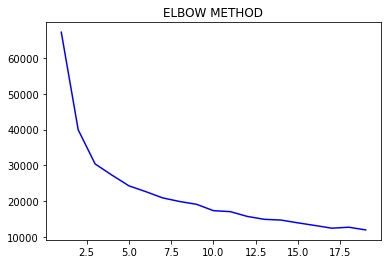

In [7]:
#from sklearn.datasets import make_blobs
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

elbow=[]
for i in range(1, 20):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', random_state = 101)
    kmeans.fit(X)
    elbow.append(kmeans.inertia_)
sns.lineplot(range(1, 20), elbow,color='blue')
plt.rcParams.update({'figure.figsize':(10,7.5), 'figure.dpi':100})
plt.title('ELBOW METHOD')
plt.show()

In [70]:
from __future__ import print_function

from sklearn.datasets import fetch_20newsgroups
from sklearn.decomposition import TruncatedSVD
from dask_ml.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer
from sklearn import metrics

from sklearn.cluster import KMeans, MiniBatchKMeans

import logging
from optparse import OptionParser
import sys
from time import time

import numpy as np

# Extract TF-IDF information
print("Extracting features from the training dataset using a sparse vectorizer")
t0 = time()
#vectorizer = TfidfVectorizer(max_df=0.8, min_df=0.02, stop_words='english',use_idf=True)

def Hashing(dataFrame):
    vectorizer = HashingVectorizer(max_df=0.8, min_df=0.02, stop_words='english',use_idf=True)
    X = vectorizer.fit_transform(dataFrame.msg)
    return X, vectorizer
  
print(X) #se stampato dopo res3 ci mette il doppio del tempo
#print()
#print(vectorizer)
res3 = delayed(Hashing)(dataFrame)
#res3.visualize()
#res3.compute()


#X_train_tfidf, tfidf_vectorizer = Hashing(dataFrame)
#X_test_tfidf = tfidf_vectorizer.transform(dataFrame)
#print(X_test_tfidf)

#vectorizer = HashingVectorizer(max_df=0.8, min_df=0.02, stop_words='english',use_idf=True)

#X = vectorizer.fit_transform(dataFrame.msg)

print("done in %fs" % (time() - t0))
print(res3)

#preprocess(numpy.array(X))
#print("n_samples: %d, n_features: %d" % X.shape)
print()


# Apply LSA for dimensionality reduction to get a lower-dimensional embedding space
#print("Performing dimensionality reduction using LSA")
#t0 = time()

# I risultati del vectorizer sono normalizzati, il che fa sì che KMean si comporti come
# k-medie sferiche per risultati migliori. Poiché i risultati LSA/SVD non sono
# normalizzati, bisogna rifare la normalizzazione.
#svd = TruncatedSVD(25)
#normalizer = Normalizer(copy=False)
#lsa = make_pipeline(svd, normalizer)

#pipe = make_pipeline(
#    Categorizer(),
#    DummyEncoder(),
#    LogisticRegression(solver='lbfgs')
#)

#pipe.fit(X)
#X = lsa.fit_transform(X)

#print("done in %fs" % (time() - t0))

#explained_variance = svd.explained_variance_ratio_.sum()
#print("Explained variance of the SVD step: {}%".format(
#    int(explained_variance * 100)))

#print()

Extracting features from the training dataset using a sparse vectorizer
(dask.array<normal, shape=(100, 20), dtype=float64, chunksize=(50, 20), chunktype=numpy.ndarray>, dask.array<astype, shape=(100,), dtype=int64, chunksize=(50,), chunktype=numpy.ndarray>)
done in 0.000829s
Delayed('Hashing-df137aad-aa2b-4f34-8428-aade36e29656')



In [27]:
from collections import Counter, defaultdict

# print the numerosity of each cluster
print(Counter(km.labels_))

Counter({2: 30889, 1: 23472, 3: 21013, 0: 13596, 4: 11030})


In [29]:
dataFrame["kmean_labels"] = km.labels_

for msg in dataFrame.msg[dataFrame.kmean_labels==0]:
    print(msg, '\n')

 Result for request 'PTP status' is 'SRM_SUCCESS' 

 Result for request 'BOL status' is 'SRM_REQUEST_INPROGRESS' 

 Result for request 'PTG' is 'SRM_REQUEST_QUEUED'. # Produced request token: '46a45197-9e00-4c2b-8b52-2c094ec68fc7' 

 Result for request 'PTG status' is 'SRM_SUCCESS' 

 Result for request 'PTG' is 'SRM_REQUEST_QUEUED'. # Produced request token: '6e797f22-e9d9-48cf-a200-c4bbf1597054' 

 Result for request 'PTG status' is 'SRM_REQUEST_QUEUED' 

 Result for request 'PTG status' is 'SRM_REQUEST_QUEUED' 

 Result for request 'PTG status' is 'SRM_SUCCESS' 

 Result for request 'BOL status' is 'SRM_REQUEST_INPROGRESS' 

 Result for request 'PTP' is 'SRM_REQUEST_QUEUED'. # Produced request token: 'e938b6c9-3bc9-4c52-9120-01f4c2dbb591' 

 Result for request 'PTP status' is 'SRM_REQUEST_QUEUED' 

 Result for request 'PTP status' is 'SRM_REQUEST_INPROGRESS' 

 Result for request 'PTG' is 'SRM_REQUEST_QUEUED'. # Produced request token: '8b72448f-cb57-4de4-b3b2-2e9a400600d6' 

 Resul

 Result for request 'PTP status' is 'SRM_REQUEST_QUEUED' 

 Result for request 'PTP status' is 'SRM_REQUEST_QUEUED' 

 Result for request 'PTP status' is 'SRM_REQUEST_QUEUED' 

 Result for request 'PTP status' is 'SRM_REQUEST_QUEUED' 

 Result for request 'PTP status' is 'SRM_REQUEST_QUEUED' 

 Result for request 'PTP status' is 'SRM_REQUEST_INPROGRESS' 

 Result for request 'PTP status' is 'SRM_SUCCESS' 

 Result for request 'PTP status' is 'SRM_SUCCESS' 

 Result for request 'PTP status' is 'SRM_SUCCESS' 

 Result for request 'PTP' is 'SRM_REQUEST_QUEUED'. # Produced request token: 'd0f35b03-9935-46b8-9f99-cf1eddefa8bd' 

 Result for request 'PTP' is 'SRM_REQUEST_QUEUED'. # Produced request token: '0454cf66-1bfe-4032-8786-761a685930ca' 

 Result for request 'PTP' is 'SRM_REQUEST_QUEUED'. # Produced request token: 'aade9f48-93f7-4769-9fa7-c5edbdf86bea' 

 Result for request 'PTP status' is 'SRM_REQUEST_QUEUED' 

 Result for request 'PTP status' is 'SRM_REQUEST_QUEUED' 

 Result for re

 Result for request 'PTP status' is 'SRM_REQUEST_INPROGRESS' 

 Result for request 'PTP status' is 'SRM_SUCCESS' 

 Result for request 'PTP' is 'SRM_REQUEST_QUEUED'. # Produced request token: '9cdb7e21-2c3c-4e7f-984d-77c5324bd656' 

 Result for request 'PTP status' is 'SRM_REQUEST_QUEUED' 

 Result for request 'PTP status' is 'SRM_REQUEST_QUEUED' 

 Result for request 'PTP status' is 'SRM_SUCCESS' 

 Result for request 'PTP' is 'SRM_REQUEST_QUEUED'. # Produced request token: 'dd38d04f-c41d-4bdf-8dc6-bd4b21d19b80' 

 Result for request 'PTP status' is 'SRM_REQUEST_QUEUED' 

 Result for request 'PTP status' is 'SRM_REQUEST_QUEUED' 

 Result for request 'PTP status' is 'SRM_SUCCESS' 

 Result for request 'PTP' is 'SRM_REQUEST_QUEUED'. # Produced request token: 'a99619c4-fc5a-4ce8-b2dc-e529a17d76b4' 

 Result for request 'PTP' is 'SRM_REQUEST_QUEUED'. # Produced request token: '87fa0b87-ca35-4d59-8440-e52fe9e5dc0d' 

 Result for request 'PTP status' is 'SRM_REQUEST_QUEUED' 

 Result for re

 Result for request 'PTP status' is 'SRM_REQUEST_INPROGRESS' 

 Result for request 'PTG status' is 'SRM_REQUEST_INPROGRESS' 

 Result for request 'PTP' is 'SRM_REQUEST_QUEUED'. # Produced request token: 'b427a6e5-d3d6-473d-8bc7-e5c8e2802434' 

 Result for request 'PTG status' is 'SRM_SUCCESS' 

 Result for request 'PTP status' is 'SRM_SUCCESS' 

 Result for request 'PTG status' is 'SRM_SUCCESS' 

 Result for request 'PTP status' is 'SRM_SUCCESS' 

 Result for request 'PTG status' is 'SRM_SUCCESS' 

 Result for request 'PTP status' is 'SRM_REQUEST_QUEUED' 

 Result for request 'PTG' is 'SRM_REQUEST_QUEUED'. # Produced request token: '793ff3ad-db7b-4d66-b41b-387e52bf144c' 

 Result for request 'PTG status' is 'SRM_SUCCESS' 

 Result for request 'PTP status' is 'SRM_REQUEST_QUEUED' 

 Result for request 'PTG status' is 'SRM_REQUEST_QUEUED' 

 Result for request 'PTG' is 'SRM_REQUEST_QUEUED'. # Produced request token: '9e9fc128-2b24-4d08-8c98-e3c3d20ceda8' 

 Result for request 'PTP' is 'S

 Result for request 'PTP' is 'SRM_REQUEST_QUEUED'. # Produced request token: 'd036aa93-7851-4858-9385-9494547340b5' 

 Result for request 'PTG status' is 'SRM_REQUEST_QUEUED' 

 Result for request 'PTP status' is 'SRM_REQUEST_QUEUED' 

 Result for request 'PTP status' is 'SRM_REQUEST_QUEUED' 

 Result for request 'PTP' is 'SRM_REQUEST_QUEUED'. # Produced request token: '1353b27a-1c41-49fd-812e-3974bb511f42' 

 Result for request 'PTG status' is 'SRM_REQUEST_QUEUED' 

 Result for request 'PTP status' is 'SRM_REQUEST_INPROGRESS' 

 Result for request 'PTP status' is 'SRM_REQUEST_INPROGRESS' 

 Result for request 'PTP status' is 'SRM_REQUEST_INPROGRESS' 

 Result for request 'PTP status' is 'SRM_SUCCESS' 

 Result for request 'PTG status' is 'SRM_SUCCESS' 

 Result for request 'PTP status' is 'SRM_SUCCESS' 

 Result for request 'PTP status' is 'SRM_SUCCESS' 

 Result for request 'PTP' is 'SRM_REQUEST_QUEUED'. # Produced request token: '9a5ccc31-642d-4261-80e7-f3e88b4f7e01' 

 Result for r

 Result for request 'PTG' is 'SRM_REQUEST_QUEUED'. # Produced request token: 'b28bafea-2be7-4567-bcb9-3188a04f924c' 

 Result for request 'PTG' is 'SRM_REQUEST_QUEUED'. # Produced request token: '34429c83-c310-49b2-a23e-0ab0d8496c15' 

 Result for request 'PTG' is 'SRM_REQUEST_QUEUED'. # Produced request token: '550cdb12-5149-475a-bc64-3a1b8caaf5d8' 

 Result for request 'PTG' is 'SRM_REQUEST_QUEUED'. # Produced request token: '13f65a2d-04b9-4e8d-802c-37df8a6bdb4c' 

 Result for request 'PTG' is 'SRM_REQUEST_QUEUED'. # Produced request token: 'e293cfd6-36d9-4b3c-b929-fb8e94571c85' 

 Result for request 'PTG status' is 'SRM_REQUEST_QUEUED' 

 Result for request 'PTG' is 'SRM_REQUEST_QUEUED'. # Produced request token: '091dcb1f-2d67-4c90-92f0-9c5dfc492826' 

 Result for request 'PTP status' is 'SRM_REQUEST_QUEUED' 

 Result for request 'PTG status' is 'SRM_REQUEST_QUEUED' 

 Result for request 'PTG status' is 'SRM_REQUEST_QUEUED' 

 Result for request 'PTG status' is 'SRM_REQUEST_INPROGR

 Result for request 'PTG status' is 'SRM_REQUEST_QUEUED' 

 Result for request 'PTP status' is 'SRM_SUCCESS' 

 Result for request 'PTP status' is 'SRM_SUCCESS' 

 Result for request 'PTP status' is 'SRM_SUCCESS' 

 Result for request 'PTP status' is 'SRM_REQUEST_QUEUED' 

 Result for request 'PTP status' is 'SRM_REQUEST_QUEUED' 

 Result for request 'PTP status' is 'SRM_REQUEST_QUEUED' 

 Result for request 'PTG status' is 'SRM_REQUEST_QUEUED' 

 Result for request 'PTP status' is 'SRM_REQUEST_QUEUED' 

 Result for request 'PTP status' is 'SRM_REQUEST_QUEUED' 

 Result for request 'PTP status' is 'SRM_REQUEST_QUEUED' 

 Result for request 'PTP' is 'SRM_REQUEST_QUEUED'. # Produced request token: 'e9318ccb-ba2c-4fd8-b866-3f03c90a4cba' 

 Result for request 'PTG' is 'SRM_REQUEST_QUEUED'. # Produced request token: '355ee87a-2d76-498d-a639-c05372df5583' 

 Result for request 'PTG status' is 'SRM_SUCCESS' 

 Result for request 'PTP status' is 'SRM_SUCCESS' 

 Result for request 'PTG status'

 Result for request 'PTP status' is 'SRM_REQUEST_INPROGRESS' 

 Result for request 'PTG status' is 'SRM_SUCCESS' 

 Result for request 'PTP status' is 'SRM_REQUEST_QUEUED' 

 Result for request 'PTP status' is 'SRM_REQUEST_QUEUED' 

 Result for request 'PTP' is 'SRM_REQUEST_QUEUED'. # Produced request token: '9cfbcb3a-15e3-4dc4-b4be-afd7f802bbad' 

 Result for request 'PTP status' is 'SRM_SUCCESS' 

 Result for request 'PTP status' is 'SRM_SUCCESS' 

 Result for request 'PTP status' is 'SRM_SUCCESS' 

 Result for request 'PTG' is 'SRM_REQUEST_QUEUED'. # Produced request token: 'ddb58c88-29c4-49c5-bba7-94643edd8d0f' 

 Result for request 'PTG' is 'SRM_REQUEST_QUEUED'. # Produced request token: '75f5ee4d-bc1e-4cad-b37d-a420e683c149' 

 Result for request 'PTG status' is 'SRM_REQUEST_QUEUED' 

 Result for request 'PTG status' is 'SRM_REQUEST_QUEUED' 

 Result for request 'PTG status' is 'SRM_REQUEST_QUEUED' 

 Result for request 'PTG status' is 'SRM_SUCCESS' 

 Result for request 'PTP' is

 Result for request 'PTG' is 'SRM_REQUEST_QUEUED'. # Produced request token: 'fa146f36-b699-4422-9ecf-e0029418ed2d' 

 Result for request 'PTP status' is 'SRM_REQUEST_INPROGRESS' 

 Result for request 'PTP status' is 'SRM_SUCCESS' 

 Result for request 'PTG status' is 'SRM_SUCCESS' 

 Result for request 'PTP status' is 'SRM_SUCCESS' 

 Result for request 'PTP status' is 'SRM_SUCCESS' 

 Result for request 'PTP' is 'SRM_REQUEST_QUEUED'. # Produced request token: 'e53e2a8a-cde3-4268-8bd0-94d0dae8025f' 

 Result for request 'PTP status' is 'SRM_REQUEST_QUEUED' 

 Result for request 'PTP status' is 'SRM_SUCCESS' 

 Result for request 'PTP' is 'SRM_REQUEST_QUEUED'. # Produced request token: 'a89b6d2f-8e61-417f-ad06-43f0bd02053c' 

 Result for request 'PTP status' is 'SRM_REQUEST_QUEUED' 

 Result for request 'PTP status' is 'SRM_SUCCESS' 

 Result for request 'PTP' is 'SRM_REQUEST_QUEUED'. # Produced request token: '6171b89f-186f-4b14-b96a-fbf4ab0ef15d' 

 Result for request 'PTP status' is

 Result for request 'PTG status' is 'SRM_SUCCESS' 

 Result for request 'PTP status' is 'SRM_SUCCESS' 

 Result for request 'PTG status' is 'SRM_SUCCESS' 

 Result for request 'PTP' is 'SRM_REQUEST_QUEUED'. # Produced request token: '575fe1b5-07e5-402a-9b0b-eba86ed9c277' 

 Result for request 'PTG' is 'SRM_REQUEST_QUEUED'. # Produced request token: '720ae65c-58fb-4632-a7b2-4974def52076' 

 Result for request 'PTP status' is 'SRM_REQUEST_QUEUED' 

 Result for request 'PTG' is 'SRM_REQUEST_QUEUED'. # Produced request token: 'c5fb9923-1491-4d24-b871-635186ad8c94' 

 Result for request 'PTG status' is 'SRM_REQUEST_QUEUED' 

 Result for request 'PTG' is 'SRM_REQUEST_QUEUED'. # Produced request token: 'aec0750b-0ad5-4cf4-ad30-25f3fc29fac6' 

 Result for request 'PTP status' is 'SRM_REQUEST_INPROGRESS' 

 Result for request 'PTG status' is 'SRM_SUCCESS' 

 Result for request 'PTG status' is 'SRM_SUCCESS' 

 Result for request 'PTG status' is 'SRM_REQUEST_QUEUED' 

 Result for request 'PTG' is

 Result for request 'PTG status' is 'SRM_REQUEST_QUEUED' 

 Result for request 'PTP status' is 'SRM_REQUEST_QUEUED' 

 Result for request 'PTP status' is 'SRM_SUCCESS' 

 Result for request 'PTG status' is 'SRM_SUCCESS' 

 Result for request 'PTG status' is 'SRM_SUCCESS' 

 Result for request 'PTP status' is 'SRM_SUCCESS' 

 Result for request 'PTG' is 'SRM_REQUEST_QUEUED'. # Produced request token: '0d2ab44f-4548-47da-8826-cc5a77080171' 

 Result for request 'PTG' is 'SRM_REQUEST_QUEUED'. # Produced request token: 'e6f45e5e-6a8b-48dc-ab08-5e3dec2fa87a' 

 Result for request 'PTG status' is 'SRM_REQUEST_QUEUED' 

 Result for request 'PTP' is 'SRM_REQUEST_QUEUED'. # Produced request token: '0ccab70f-baf2-475c-9ce2-45e1292b582a' 

 Result for request 'PTP' is 'SRM_REQUEST_QUEUED'. # Produced request token: '090ee8c8-44bc-4f34-8429-4ab065c80407' 

 Result for request 'PTG status' is 'SRM_SUCCESS' 

 Result for request 'PTG status' is 'SRM_SUCCESS' 

 Result for request 'PTP status' is 'SR


 Result for request 'PTG status' is 'SRM_REQUEST_QUEUED' 

 Result for request 'PTP status' is 'SRM_REQUEST_QUEUED' 

 Result for request 'PTG' is 'SRM_REQUEST_QUEUED'. # Produced request token: '33e2a3af-7d0b-406b-9b13-7a1d2f2e9de8' 

 Result for request 'PTG status' is 'SRM_REQUEST_QUEUED' 

 Result for request 'PTG status' is 'SRM_REQUEST_QUEUED' 

 Result for request 'PTP status' is 'SRM_REQUEST_QUEUED' 

 Result for request 'PTP' is 'SRM_REQUEST_QUEUED'. # Produced request token: 'b6dac6a6-80b2-423c-b201-77e848cc31b1' 

 Result for request 'PTP status' is 'SRM_REQUEST_QUEUED' 

 Result for request 'PTG status' is 'SRM_REQUEST_QUEUED' 

 Result for request 'PTG status' is 'SRM_REQUEST_QUEUED' 

 Result for request 'PTP status' is 'SRM_SUCCESS' 

 Result for request 'PTP status' is 'SRM_SUCCESS' 

 Result for request 'PTP' is 'SRM_REQUEST_QUEUED'. # Produced request token: '08f4dffb-0a12-4e0d-be16-10288ed342c2' 

 Result for request 'PTG status' is 'SRM_SUCCESS' 

 Result for reque


 Result for request 'PTP' is 'SRM_REQUEST_QUEUED'. # Produced request token: '82e94c3b-3a9a-4813-a7ba-72211209e898' 

 Result for request 'PTP status' is 'SRM_REQUEST_QUEUED' 

 Result for request 'PTP' is 'SRM_REQUEST_QUEUED'. # Produced request token: '212855d0-7626-4b3b-b40e-812b50af57c3' 

 Result for request 'PTP status' is 'SRM_REQUEST_QUEUED' 

 Result for request 'PTP status' is 'SRM_REQUEST_INPROGRESS' 

 Result for request 'PTP status' is 'SRM_REQUEST_INPROGRESS' 

 Result for request 'PTP status' is 'SRM_SUCCESS' 

 Result for request 'PTP status' is 'SRM_SUCCESS' 

 Result for request 'PTP status' is 'SRM_SUCCESS' 

 Result for request 'PTG' is 'SRM_REQUEST_QUEUED'. # Produced request token: '992617a5-e5fc-493b-82fc-63d37697e3a3' 

 Result for request 'PTP status' is 'SRM_SUCCESS' 

 Result for request 'PTP' is 'SRM_REQUEST_QUEUED'. # Produced request token: '2aeca623-db7c-416f-8d6d-15dd76dfed76' 

 Result for request 'PTG status' is 'SRM_SUCCESS' 

 Result for request 'PT


 Result for request 'PTG status' is 'SRM_REQUEST_QUEUED' 

 Result for request 'PTG status' is 'SRM_SUCCESS' 

 Result for request 'PTG status' is 'SRM_SUCCESS' 

 Result for request 'PTG status' is 'SRM_SUCCESS' 

 Result for request 'PTG' is 'SRM_REQUEST_QUEUED'. # Produced request token: '0140db23-3bfb-4895-a55a-3f042aaa3cb8' 

 Result for request 'PTG status' is 'SRM_REQUEST_QUEUED' 

 Result for request 'PTG' is 'SRM_REQUEST_QUEUED'. # Produced request token: '3638b554-bd28-4e5a-965d-8e9405ccb4d8' 

 Result for request 'PTG status' is 'SRM_REQUEST_QUEUED' 

 Result for request 'PTG status' is 'SRM_REQUEST_QUEUED' 

 Result for request 'PTG status' is 'SRM_REQUEST_QUEUED' 

 Result for request 'PTG' is 'SRM_REQUEST_QUEUED'. # Produced request token: '71befe62-f3ac-44fe-899d-56ec66a73677' 

 Result for request 'PTG status' is 'SRM_SUCCESS' 

 Result for request 'PTG status' is 'SRM_SUCCESS' 

 Result for request 'PTG status' is 'SRM_SUCCESS' 

 Result for request 'PTG' is 'SRM_REQU

 Result for request 'PTG status' is 'SRM_SUCCESS' 

 Result for request 'PTG status' is 'SRM_REQUEST_QUEUED' 

 Result for request 'PTG status' is 'SRM_REQUEST_INPROGRESS' 

 Result for request 'PTG status' is 'SRM_SUCCESS' 

 Result for request 'PTG' is 'SRM_REQUEST_QUEUED'. # Produced request token: 'e6380108-7439-4c3b-8b20-369c8f6398ed' 

 Result for request 'PTG status' is 'SRM_REQUEST_QUEUED' 

 Result for request 'PTG status' is 'SRM_REQUEST_QUEUED' 

 Result for request 'PTG status' is 'SRM_SUCCESS' 

 Result for request 'PTG' is 'SRM_REQUEST_QUEUED'. # Produced request token: '9acb2e0b-a8e6-49a6-a773-713480d0eae5' 

 Result for request 'PTG status' is 'SRM_REQUEST_QUEUED' 

 Result for request 'PTG status' is 'SRM_REQUEST_QUEUED' 

 Result for request 'PTG status' is 'SRM_SUCCESS' 

 Result for request 'PTG' is 'SRM_REQUEST_QUEUED'. # Produced request token: '32ad90b0-f4cc-4ac3-8496-124ad44306b4' 

 Result for request 'PTG status' is 'SRM_REQUEST_QUEUED' 

 Result for request '

 Result for request 'PTG' is 'SRM_REQUEST_QUEUED'. # Produced request token: '2c977f4e-92b0-4362-afbc-b11c55c1a2e0' 

 Result for request 'PTP status' is 'SRM_SUCCESS' 

 Result for request 'PTP' is 'SRM_REQUEST_QUEUED'. # Produced request token: 'f0247a3f-553f-42cf-9332-a6ec3f56f943' 

 Result for request 'PTG status' is 'SRM_REQUEST_QUEUED' 

 Result for request 'PTP status' is 'SRM_REQUEST_QUEUED' 

 Result for request 'PTG status' is 'SRM_REQUEST_QUEUED' 

 Result for request 'PTP status' is 'SRM_REQUEST_QUEUED' 

 Result for request 'PTG status' is 'SRM_SUCCESS' 

 Result for request 'PTP status' is 'SRM_SUCCESS' 

 Result for request 'PTP' is 'SRM_REQUEST_QUEUED'. # Produced request token: '59dbdf21-a17e-499c-8aab-08edb33cff57' 

 Result for request 'PTP status' is 'SRM_REQUEST_QUEUED' 

 Result for request 'PTP status' is 'SRM_SUCCESS' 

 Result for request 'PTG' is 'SRM_REQUEST_QUEUED'. # Produced request token: '75f0d068-1b27-405f-ad56-1325bee31345' 

 Result for request 'PTG 

In [35]:
import matplotlib.pyplot as plt
from collections import Counter, defaultdict
import numpy as np

t0 = time()

#with client:
label = np.unique(km.labels_)
count = [Counter(km.labels_)[i] for i in label]

for l in label:
    print(dataFrame.msg[dataFrame.kmean_labels==l][0:5], '\n')

print("done in %fs" % (time() - t0))

4      Result for request 'PTP status' is 'SRM_SUCCESS'
17     Result for request 'BOL status' is 'SRM_REQUE...
34     Result for request 'PTG' is 'SRM_REQUEST_QUEU...
36     Result for request 'PTG status' is 'SRM_SUCCESS'
50     Result for request 'PTG' is 'SRM_REQUEST_QUEU...
Name: msg, dtype: object 

1      ns1__srmReleaseFiles : Request: Release files...
15     Request 'BOL status' from Client IP='2001:145...
21     ns1__srmReleaseFiles : Request: Release files...
24     ns1__srmLs : Request: Ls. IP: 2001:1458:201:e...
26     ns1__srmPing : Request: Ping. IP: 2001:1458:2...
Name: msg, dtype: object 

2      Result for request 'Release files' is 'SRM_SU...
6        Result for request 'Put done' is 'SRM_SUCCESS'
8              Result for request 'Ls' is 'SRM_SUCCESS'
10             Result for request 'Ls' is 'SRM_SUCCESS'
12             Result for request 'Ls' is 'SRM_SUCCESS'
Name: msg, dtype: object 

3      Request 'PTP status' from Client IP='::ffff:1...
5      ns1__srmPutDone 

In [33]:
for msg in dataFrame.msg[dataFrame.kmean_labels==0]:
    print(msg, '\n')

 Result for request 'PTP status' is 'SRM_SUCCESS' 

 Result for request 'BOL status' is 'SRM_REQUEST_INPROGRESS' 

 Result for request 'PTG' is 'SRM_REQUEST_QUEUED'. # Produced request token: '46a45197-9e00-4c2b-8b52-2c094ec68fc7' 

 Result for request 'PTG status' is 'SRM_SUCCESS' 

 Result for request 'PTG' is 'SRM_REQUEST_QUEUED'. # Produced request token: '6e797f22-e9d9-48cf-a200-c4bbf1597054' 

 Result for request 'PTG status' is 'SRM_REQUEST_QUEUED' 

 Result for request 'PTG status' is 'SRM_REQUEST_QUEUED' 

 Result for request 'PTG status' is 'SRM_SUCCESS' 

 Result for request 'BOL status' is 'SRM_REQUEST_INPROGRESS' 

 Result for request 'PTP' is 'SRM_REQUEST_QUEUED'. # Produced request token: 'e938b6c9-3bc9-4c52-9120-01f4c2dbb591' 

 Result for request 'PTP status' is 'SRM_REQUEST_QUEUED' 

 Result for request 'PTP status' is 'SRM_REQUEST_INPROGRESS' 

 Result for request 'PTG' is 'SRM_REQUEST_QUEUED'. # Produced request token: '8b72448f-cb57-4de4-b3b2-2e9a400600d6' 

 Resul

 Result for request 'PTP' is 'SRM_REQUEST_QUEUED'. # Produced request token: 'f62c1fea-3d75-4e14-857e-67d626531b0c' 

 Result for request 'PTP status' is 'SRM_REQUEST_QUEUED' 

 Result for request 'PTP status' is 'SRM_SUCCESS' 

 Result for request 'PTG' is 'SRM_REQUEST_QUEUED'. # Produced request token: 'd6d032a2-dd65-4a56-9ed7-05fcc6e4e7c1' 

 Result for request 'PTG' is 'SRM_REQUEST_QUEUED'. # Produced request token: '78bc3cd8-fadb-48b1-99b1-0b19c0149272' 

 Result for request 'PTG status' is 'SRM_SUCCESS' 

 Result for request 'PTG status' is 'SRM_SUCCESS' 

 Result for request 'PTP' is 'SRM_REQUEST_QUEUED'. # Produced request token: '833d9b84-57e3-4f44-86f4-7306f70c6f1e' 

 Result for request 'PTP status' is 'SRM_REQUEST_QUEUED' 

 Result for request 'PTP status' is 'SRM_REQUEST_QUEUED' 

 Result for request 'PTP' is 'SRM_REQUEST_QUEUED'. # Produced request token: '7a86e0de-9466-49c4-aada-a1a10cb189bb' 

 Result for request 'PTP status' is 'SRM_REQUEST_QUEUED' 

 Result for reques


 Result for request 'PTP' is 'SRM_REQUEST_QUEUED'. # Produced request token: 'a480a06a-b6b1-4431-be8a-a55e1f0f607f' 

 Result for request 'PTP status' is 'SRM_REQUEST_QUEUED' 

 Result for request 'PTG status' is 'SRM_REQUEST_QUEUED' 

 Result for request 'PTP status' is 'SRM_SUCCESS' 

 Result for request 'PTP status' is 'SRM_SUCCESS' 

 Result for request 'PTG status' is 'SRM_SUCCESS' 

 Result for request 'PTP' is 'SRM_REQUEST_QUEUED'. # Produced request token: '3a3a04ec-1024-4926-83b9-09da57c48c25' 

 Result for request 'BOL' is 'SRM_REQUEST_QUEUED'. # Produced request token: '380bdbb7-2150-422a-87f9-ff30263912b3' 

 Result for request 'PTP status' is 'SRM_REQUEST_QUEUED' 

 Result for request 'PTP status' is 'SRM_SUCCESS' 

 Result for request 'BOL status' is 'SRM_SUCCESS' 

 Result for request 'PTP' is 'SRM_REQUEST_QUEUED'. # Produced request token: '80e634a0-e6ab-44d4-b26b-83f040f95a3c' 

 Result for request 'PTP status' is 'SRM_REQUEST_QUEUED' 

 Result for request 'PTP status

 Result for request 'PTG status' is 'SRM_REQUEST_QUEUED' 

 Result for request 'PTG status' is 'SRM_REQUEST_QUEUED' 

 Result for request 'PTG status' is 'SRM_SUCCESS' 

 Result for request 'PTG' is 'SRM_REQUEST_QUEUED'. # Produced request token: 'f6186f3d-da1f-4de6-add3-adc6d1f62f4f' 

 Result for request 'PTG status' is 'SRM_REQUEST_QUEUED' 

 Result for request 'PTG status' is 'SRM_REQUEST_QUEUED' 

 Result for request 'PTG status' is 'SRM_SUCCESS' 

 Result for request 'PTG' is 'SRM_REQUEST_QUEUED'. # Produced request token: 'b71ddf02-5759-4309-8250-b2833ad71c8f' 

 Result for request 'PTG status' is 'SRM_REQUEST_QUEUED' 

 Result for request 'PTG status' is 'SRM_SUCCESS' 

 Result for request 'PTG' is 'SRM_REQUEST_QUEUED'. # Produced request token: '0cd7de81-4b5e-4c3a-8186-46b9a27c97b3' 

 Result for request 'PTG' is 'SRM_REQUEST_QUEUED'. # Produced request token: '4f42be77-1c8c-45b2-9069-e018684138be' 

 Result for request 'PTG' is 'SRM_REQUEST_QUEUED'. # Produced request token: 

 Result for request 'PTP status' is 'SRM_REQUEST_INPROGRESS' 

 Result for request 'PTP' is 'SRM_REQUEST_QUEUED'. # Produced request token: '4e41dcac-b4a1-4d44-9c57-5749e48c09d6' 

 Result for request 'PTG status' is 'SRM_SUCCESS' 

 Result for request 'PTP status' is 'SRM_SUCCESS' 

 Result for request 'PTP status' is 'SRM_REQUEST_QUEUED' 

 Result for request 'PTP status' is 'SRM_REQUEST_QUEUED' 

 Result for request 'PTP status' is 'SRM_SUCCESS' 

 Result for request 'PTP' is 'SRM_REQUEST_QUEUED'. # Produced request token: '80725d2a-e139-456c-b724-de810d517284' 

 Result for request 'PTP status' is 'SRM_REQUEST_QUEUED' 

 Result for request 'PTP status' is 'SRM_REQUEST_QUEUED' 

 Result for request 'PTP' is 'SRM_REQUEST_QUEUED'. # Produced request token: '99df7c77-3f93-4018-91aa-8c910c6b17b3' 

 Result for request 'PTP status' is 'SRM_SUCCESS' 

 Result for request 'PTP status' is 'SRM_REQUEST_QUEUED' 

 Result for request 'PTP status' is 'SRM_REQUEST_QUEUED' 

 Result for request '

 Result for request 'PTP status' is 'SRM_REQUEST_QUEUED' 

 Result for request 'PTP status' is 'SRM_REQUEST_QUEUED' 

 Result for request 'PTP' is 'SRM_REQUEST_QUEUED'. # Produced request token: 'd140a718-5ab5-4986-98e9-bcfdab4dbb11' 

 Result for request 'PTP status' is 'SRM_REQUEST_QUEUED' 

 Result for request 'PTP status' is 'SRM_REQUEST_QUEUED' 

 Result for request 'PTP status' is 'SRM_REQUEST_QUEUED' 

 Result for request 'PTP status' is 'SRM_REQUEST_QUEUED' 

 Result for request 'PTP status' is 'SRM_REQUEST_QUEUED' 

 Result for request 'PTG' is 'SRM_REQUEST_QUEUED'. # Produced request token: 'eb398a98-24fd-4456-9a08-e32a9d9b6483' 

 Result for request 'PTP status' is 'SRM_SUCCESS' 

 Result for request 'PTP status' is 'SRM_SUCCESS' 

 Result for request 'PTP status' is 'SRM_SUCCESS' 

 Result for request 'PTP status' is 'SRM_SUCCESS' 

 Result for request 'PTG status' is 'SRM_REQUEST_QUEUED' 

 Result for request 'PTP status' is 'SRM_SUCCESS' 

 Result for request 'PTP' is 'SR

 Result for request 'PTP status' is 'SRM_SUCCESS' 

 Result for request 'PTP status' is 'SRM_SUCCESS' 

 Result for request 'PTG' is 'SRM_REQUEST_QUEUED'. # Produced request token: 'efc16128-b376-45d7-891e-24298e7b49a2' 

 Result for request 'PTP' is 'SRM_REQUEST_QUEUED'. # Produced request token: 'c967a9c6-b5fc-47a0-8ba4-7c8987ec1d9f' 

 Result for request 'PTG status' is 'SRM_REQUEST_INPROGRESS' 

 Result for request 'PTP status' is 'SRM_SUCCESS' 

 Result for request 'PTG status' is 'SRM_SUCCESS' 

 Result for request 'PTP' is 'SRM_REQUEST_QUEUED'. # Produced request token: 'bae39616-6c53-4d92-8052-c712600b8882' 

 Result for request 'PTP' is 'SRM_REQUEST_QUEUED'. # Produced request token: 'e974f204-e634-43c2-8758-1141a102f251' 

 Result for request 'PTP status' is 'SRM_REQUEST_QUEUED' 

 Result for request 'PTP status' is 'SRM_REQUEST_QUEUED' 

 Result for request 'PTP' is 'SRM_REQUEST_QUEUED'. # Produced request token: '17bff35d-9c14-4c2c-9802-0f906e1b1b41' 

 Result for request '

 Result for request 'PTG status' is 'SRM_SUCCESS' 

 Result for request 'PTP status' is 'SRM_REQUEST_QUEUED' 

 Result for request 'PTP status' is 'SRM_SUCCESS' 

 Result for request 'PTP status' is 'SRM_SUCCESS' 

 Result for request 'PTG status' is 'SRM_SUCCESS' 

 Result for request 'PTP status' is 'SRM_REQUEST_QUEUED' 

 Result for request 'PTG' is 'SRM_REQUEST_QUEUED'. # Produced request token: 'f8bb351e-3049-43d3-89b6-dfb2f4b34d1d' 

 Result for request 'PTG status' is 'SRM_REQUEST_QUEUED' 

 Result for request 'PTP' is 'SRM_REQUEST_QUEUED'. # Produced request token: 'cf45b2ec-13c0-43a0-904e-031acc637a1d' 

 Result for request 'PTP status' is 'SRM_REQUEST_INPROGRESS' 

 Result for request 'PTG status' is 'SRM_SUCCESS' 

 Result for request 'PTP status' is 'SRM_REQUEST_QUEUED' 

 Result for request 'PTG' is 'SRM_REQUEST_QUEUED'. # Produced request token: 'fa17e5a9-6770-4082-93d4-f56716c57346' 

 Result for request 'PTP status' is 'SRM_REQUEST_QUEUED' 

 Result for request 'PTG sta

 Result for request 'PTP status' is 'SRM_REQUEST_INPROGRESS' 

 Result for request 'PTP status' is 'SRM_SUCCESS' 

 Result for request 'PTG status' is 'SRM_SUCCESS' 

 Result for request 'PTG status' is 'SRM_SUCCESS' 

 Result for request 'PTP' is 'SRM_REQUEST_QUEUED'. # Produced request token: 'aca8fe3d-123f-4fbb-8606-bc3104dcbebd' 

 Result for request 'PTP' is 'SRM_REQUEST_QUEUED'. # Produced request token: '1a05b325-9f17-4b9c-bd68-42be456a17eb' 

 Result for request 'PTP status' is 'SRM_REQUEST_QUEUED' 

 Result for request 'PTP status' is 'SRM_REQUEST_QUEUED' 

 Result for request 'PTP status' is 'SRM_REQUEST_INPROGRESS' 

 Result for request 'PTP' is 'SRM_REQUEST_QUEUED'. # Produced request token: '140cfe61-e14a-4747-9125-143f6b312a44' 

 Result for request 'PTP status' is 'SRM_SUCCESS' 

 Result for request 'PTP' is 'SRM_REQUEST_QUEUED'. # Produced request token: '7fe27944-91b1-4cf2-a407-d9ae786397ff' 

 Result for request 'PTP status' is 'SRM_REQUEST_QUEUED' 

 Result for reque

 Result for request 'PTG' is 'SRM_REQUEST_QUEUED'. # Produced request token: 'ae47b9f5-e3c9-42fd-ac9f-1dc804cfe1ce' 

 Result for request 'PTG' is 'SRM_REQUEST_QUEUED'. # Produced request token: 'd2fb2939-118e-465f-b0b8-f184e169addd' 

 Result for request 'PTG status' is 'SRM_SUCCESS' 

 Result for request 'PTP' is 'SRM_REQUEST_QUEUED'. # Produced request token: 'fc802d94-b7a0-46c6-b645-cb53482a3bfa' 

 Result for request 'PTG' is 'SRM_REQUEST_QUEUED'. # Produced request token: 'c0f6a4ed-f205-48bc-9c15-9e106b55e116' 

 Result for request 'PTP status' is 'SRM_SUCCESS' 

 Result for request 'PTP' is 'SRM_REQUEST_QUEUED'. # Produced request token: '8a2c7057-99ce-475f-9cbd-7bfe110e406e' 

 Result for request 'PTG status' is 'SRM_REQUEST_QUEUED' 

 Result for request 'PTP status' is 'SRM_REQUEST_QUEUED' 

 Result for request 'PTG status' is 'SRM_REQUEST_QUEUED' 

 Result for request 'PTP status' is 'SRM_REQUEST_QUEUED' 

 Result for request 'PTG status' is 'SRM_REQUEST_QUEUED' 

 Result for

 Result for request 'PTP status' is 'SRM_SUCCESS' 

 Result for request 'PTP' is 'SRM_REQUEST_QUEUED'. # Produced request token: '62482537-70f5-46ea-bad5-951405253b41' 

 Result for request 'PTP status' is 'SRM_SUCCESS' 

 Result for request 'PTP status' is 'SRM_SUCCESS' 

 Result for request 'PTP status' is 'SRM_REQUEST_QUEUED' 

 Result for request 'PTP status' is 'SRM_REQUEST_QUEUED' 

 Result for request 'PTP' is 'SRM_REQUEST_QUEUED'. # Produced request token: '294e404a-acc2-4461-9511-44b114d288f9' 

 Result for request 'PTP status' is 'SRM_SUCCESS' 

 Result for request 'PTP status' is 'SRM_REQUEST_QUEUED' 

 Result for request 'PTP' is 'SRM_REQUEST_QUEUED'. # Produced request token: '8be22112-2057-41a6-9613-db6256ac5ffc' 

 Result for request 'PTP status' is 'SRM_REQUEST_QUEUED' 

 Result for request 'PTP status' is 'SRM_SUCCESS' 

 Result for request 'PTP' is 'SRM_REQUEST_QUEUED'. # Produced request token: '1cf2dbb0-ef23-41e7-b3f9-43a27b2b2f19' 

 Result for request 'PTP' is 'SR


 Result for request 'PTG status' is 'SRM_REQUEST_INPROGRESS' 

 Result for request 'PTP' is 'SRM_REQUEST_QUEUED'. # Produced request token: '28e11a2d-1c51-496a-9e10-a51345c2a835' 

 Result for request 'PTP status' is 'SRM_SUCCESS' 

 Result for request 'PTG' is 'SRM_REQUEST_QUEUED'. # Produced request token: 'd5fd4ec3-5d8e-4135-828a-38d30d3510ba' 

 Result for request 'PTP status' is 'SRM_REQUEST_QUEUED' 

 Result for request 'PTP status' is 'SRM_REQUEST_QUEUED' 

 Result for request 'PTG status' is 'SRM_SUCCESS' 

 Result for request 'PTG status' is 'SRM_REQUEST_QUEUED' 

 Result for request 'PTP' is 'SRM_REQUEST_QUEUED'. # Produced request token: '0f7842c8-3000-4abe-839c-70ea9215ea01' 

 Result for request 'PTP status' is 'SRM_REQUEST_QUEUED' 

 Result for request 'PTG status' is 'SRM_REQUEST_QUEUED' 

 Result for request 'PTG' is 'SRM_REQUEST_QUEUED'. # Produced request token: '0d2e82e2-6b00-4fd6-a84f-39700869c438' 

 Result for request 'PTG' is 'SRM_REQUEST_QUEUED'. # Produced req

 Result for request 'PTP status' is 'SRM_SUCCESS' 

 Result for request 'PTP' is 'SRM_REQUEST_QUEUED'. # Produced request token: 'b08ef793-d5f9-4df4-ba97-132695f3b7a8' 

 Result for request 'PTP status' is 'SRM_REQUEST_INPROGRESS' 

 Result for request 'PTP status' is 'SRM_SUCCESS' 

 Result for request 'PTP' is 'SRM_REQUEST_QUEUED'. # Produced request token: '380720fa-8597-4ee2-bd9d-a2a930e3a7fc' 

 Result for request 'PTP status' is 'SRM_REQUEST_QUEUED' 

 Result for request 'PTG' is 'SRM_REQUEST_QUEUED'. # Produced request token: 'f1cbb0c4-1f3a-411a-80d7-cf84c35aa420' 

 Result for request 'PTP status' is 'SRM_REQUEST_QUEUED' 

 Result for request 'PTG status' is 'SRM_REQUEST_QUEUED' 

 Result for request 'PTG status' is 'SRM_REQUEST_INPROGRESS' 

 Result for request 'PTG' is 'SRM_REQUEST_QUEUED'. # Produced request token: '9238a30a-43cd-4514-ada7-d8e02ab23277' 

 Result for request 'PTP status' is 'SRM_SUCCESS' 

 Result for request 'PTG status' is 'SRM_REQUEST_QUEUED' 

 Result fo

 Result for request 'PTP' is 'SRM_REQUEST_QUEUED'. # Produced request token: '5d15d417-86d7-46d8-a163-2d5bc5913990' 

 Result for request 'PTP status' is 'SRM_SUCCESS' 

 Result for request 'PTP status' is 'SRM_REQUEST_QUEUED' 

 Result for request 'PTG' is 'SRM_REQUEST_QUEUED'. # Produced request token: '28800fe7-adf9-4794-ae62-ccf22d51a4c2' 

 Result for request 'PTP status' is 'SRM_REQUEST_QUEUED' 

 Result for request 'PTP' is 'SRM_REQUEST_QUEUED'. # Produced request token: '3380da5a-b55a-4a29-8b17-8bca4d8cf3ff' 

 Result for request 'PTG status' is 'SRM_REQUEST_QUEUED' 

 Result for request 'PTP' is 'SRM_REQUEST_QUEUED'. # Produced request token: 'b8b966c0-effe-49fb-a3ff-39d308e5600a' 

 Result for request 'PTP status' is 'SRM_REQUEST_QUEUED' 

 Result for request 'PTP status' is 'SRM_REQUEST_INPROGRESS' 

 Result for request 'PTG status' is 'SRM_SUCCESS' 

 Result for request 'PTP status' is 'SRM_SUCCESS' 

 Result for request 'PTP status' is 'SRM_SUCCESS' 

 Result for request '

 Result for request 'PTP status' is 'SRM_SUCCESS' 

 Result for request 'PTP status' is 'SRM_SUCCESS' 

 Result for request 'PTG' is 'SRM_REQUEST_QUEUED'. # Produced request token: '8ec36559-36d0-43ac-b986-4feee420be8f' 

 Result for request 'PTG status' is 'SRM_REQUEST_QUEUED' 

 Result for request 'PTG status' is 'SRM_REQUEST_QUEUED' 

 Result for request 'PTG status' is 'SRM_SUCCESS' 

 Result for request 'PTG status' is 'SRM_SUCCESS' 

 Result for request 'PTG' is 'SRM_REQUEST_QUEUED'. # Produced request token: 'c23cf393-ffb6-45c6-b7c2-3448ce5b7deb' 

 Result for request 'PTG status' is 'SRM_REQUEST_QUEUED' 

 Result for request 'PTG status' is 'SRM_REQUEST_QUEUED' 

 Result for request 'PTP' is 'SRM_REQUEST_QUEUED'. # Produced request token: '8e8a0e0e-7609-43a1-8b8b-ed1869e746c1' 

 Result for request 'PTG status' is 'SRM_SUCCESS' 

 Result for request 'PTG' is 'SRM_REQUEST_QUEUED'. # Produced request token: 'c5f9cd1e-4554-4e4d-8bb1-f757f6457de1' 

 Result for request 'PTP status'

In [71]:
import re

error = [0] * len(label)

for l in label:
    for msg in dataFrame.msg[dataFrame.kmean_labels==l]:
        resultE = re.search('error', msg.lower())
        resultF = re.search('failure', msg.lower())
        resultP = re.search('problem', msg.lower())
        if resultE!=None :
            error[l] += 1
        if resultF!=None:
            error[l] += 1
        if resultP!=None:
            error[l] += 1
            
error

[0, 0, 5228, 0, 0]